# **Comparison of subtypes** 

### Dependencies

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import (shapiro, ttest_ind, mannwhitneyu)
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os


In [144]:
def stage_model(model):

    coef_df = pd.DataFrame(model.summary().tables[1]).reset_index()
    if "Coef." not in coef_df.columns:
            # Make the first row the columns
            coef_df.columns = coef_df.iloc[0].astype(str)
            # Drop the first row
            coef_df = coef_df[1:]
            # Drop the first column
            coef_df = coef_df.drop(columns=["0"])
            # Rename the columns
            coef_df.rename(columns={"": "index", "coef":'Coef.','std err':'Std.Err.', "t":"stat","P>|t|":"pval"}, inplace=True)
            coef_df['Coef.']=coef_df['Coef.'].astype(str)
            coef_df['Std.Err.']=coef_df['Std.Err.'].astype(str)
            coef_df['stat']=coef_df['stat'].astype(str)
            coef_df['pval']=coef_df['pval'].astype(str)
            coef_df['[0.025']=coef_df['[0.025'].astype(str)
            coef_df['0.975]']=coef_df['0.975]'].astype(str)
            coef_df["index"]= coef_df["index"].astype(str)


    else: 
        coef_df.rename(columns={"z":"stat", "P>|z|":"pval"}, inplace=True)
            
            
    # Drop unwanted rows where z values are ''
    coef_df = coef_df.loc[coef_df.stat != ''].copy()    

    # Drop the intercept row as well
    coef_df = coef_df.loc[coef_df["index"].isin(['Intercept']) == False]

    # Convert numeric columns to float
    coef_df['Coef.'] = coef_df['Coef.'].astype(float)
    coef_df['[0.025'] = coef_df['[0.025'].astype(float)
    coef_df['pval']= coef_df['pval'].astype(float)
    
    # Calculate errors
    coef_df['errors'] = coef_df['Coef.'] - coef_df['[0.025']

    return coef_df


def coefplot_gap(results, multiple_models=False, fig_name=None):
    '''
    Creates a coefficient plot with confidence intervals.
    
    Parameters:
    results : statsmodels results object or DataFrame
        If multiple_models=False: statsmodels results object
        If multiple_models=True: DataFrame with columns: index, model, Coef., [0.025, P>|z|
    multiple_models : bool, default False
        Whether to create a plot for multiple models or single model
    
    Returns:
        matplotlib plot
    '''
    # Create/process dataframe based on input type
    if not multiple_models:
        coef_df = pd.DataFrame(results.summary().tables[1]).reset_index()
        coef_df=stage_model(results)

    else:
        coef_df = results.copy()
    
    
    
    # Create significance indicators - make them consistent between both cases
    if multiple_models:
        coef_df['Significance'] = coef_df['pval'].apply(
            lambda x: 'Significant' if x < 0.05 else 'Not Significant'
        )
    else:
        # Changed to match the multiple models case
        coef_df['Significance'] = coef_df['pval'].apply(
            lambda x: 'Significant' if x < 0.05 else 'Not Significant'
        )
    
    # Clean up Treatment variable names
    for var_name in coef_df['index'].unique():
        if "Treatment" in var_name:
            if ":" in var_name:
                var1 = var_name.split("[",1)[1].split("]")[0]
                var2 = var_name.split("[", 2)[-1]
                new_var_name = var1 + ":" + var2
            else:
                new_var_name = var_name.split("[", 1)[1].split("]")[0]
            coef_df['index'] = coef_df['index'].replace(var_name, new_var_name)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(18, 10))
    
    # Define consistent marker styles
    marker_styles = {'Significant': 'X', 'Not Significant': 'o'}
    

    if multiple_models:
        # Get models and calculate positions
        models = coef_df['model'].unique()
        variables = coef_df['index'].unique()
        n_models = len(models)
        space_between = 3.5
        model_spacing = 1.0
        
        # Create position mapping
        positions = {}
        # Sort variables by their average coefficient value (lowest to highest)
        var_means = coef_df.groupby('index')['Coef.'].mean().sort_values()
        sorted_vars = var_means.index
        
        for i, var in enumerate(sorted_vars):
            base_pos = i * (n_models + space_between)
            for j, model in enumerate(models):
                positions[(var, model)] = base_pos + (j * model_spacing)
        
        # Add plot positions
        coef_df['plot_position'] = coef_df.apply(
            lambda row: positions[(row['index'], row['model'])], 
            axis=1
        )
        
        # Set up colors for multiple models
        model_palette = sns.color_palette("husl", n_colors=len(models))
        model_colors = dict(zip(models, model_palette))
        
        # Plot error bars
        for model in models:
            model_data = coef_df[coef_df['model'] == model]
            plt.errorbar(x=model_data['Coef.'],
                        y=model_data['plot_position'],
                        xerr=model_data['errors'],
                        color=model_colors[model],
                        capsize=3,
                        fmt='none',
                        alpha=0.7,
                        zorder=1)
        
        # Plot points
        g = sns.scatterplot(data=coef_df,
                           x='Coef.',
                           y='plot_position',
                           hue='model',
                           style='Significance',
                           markers=marker_styles,
                           palette=model_colors,
                           s=200,
                           zorder=3,
                           ax=ax)
        
        # Set y-ticks
        tick_positions = []
        for i, var in enumerate(sorted_vars):
            base_pos = i * (n_models + space_between)
            middle_pos = base_pos + ((n_models - 1) * model_spacing) / 2
            tick_positions.append(middle_pos)
        
        ax.set_yticks(tick_positions)
        ax.set_yticklabels(sorted_vars)
        
        # Create legends
        g.legend_.remove()
        
        # Model legend
        model_legend = ax.legend(
            title='Models',
            handles=[plt.Line2D([], [], marker='o', color=color, linestyle='None', 
                               markersize=10, label=model)
                    for model, color in model_colors.items()],
            bbox_to_anchor=(1.02, 1),
            loc='upper left'
        )
        
        # Significance legend
        significance_handles = [
            plt.Line2D([], [], marker='X', color='gray', linestyle='None', 
                      markersize=10, label='Significant'),
            plt.Line2D([], [], marker='o', color='gray', linestyle='None', 
                      markersize=10, label='Not Significant')
        ]
        
        ax.add_artist(model_legend)
        ax.legend(handles=significance_handles,
                 title='Significance',
                 bbox_to_anchor=(1.02, 0.6),
                 loc='upper left')
        
    else:
        # Sort the dataframe by coefficient values (lowest to highest)
        coef_df = coef_df.sort_values(by='Coef.', ascending=False)
        
        # Single model plot
        palette = sns.color_palette("Set1")
        color_map = {'Significant': palette[0], 'Not Significant': palette[1]}
        
        # Error bars
        for idx, row in coef_df.iterrows():
            error_color = color_map[row['Significance']]
            plt.errorbar(x=row['Coef.'], 
                        y=row['index'], 
                        xerr=row['errors'],
                        color=error_color, 
                        capsize=3,
                        fmt='none', 
                        zorder=1)
        
        # Scatter plot with consistent markers
        g = sns.scatterplot(y='index',
                           x='Coef.',
                           style='Significance',
                           hue='Significance',
                           markers=marker_styles,
                           palette=color_map,
                           s=200,
                           data=coef_df,
                           zorder=3,
                           ax=ax)
    
    # Common plot elements
    ax.axvline(x=0, linestyle='--', color='red', linewidth=1)
    
    # Set title & labels
    title = 'Coefficients Across Models w/ 95% Confidence Intervals' if multiple_models else 'Coefficients of Features w/ 95% Confidence Intervals'
    plt.title(title, fontsize=30)
    ax.set_ylabel('Variables' if multiple_models else 'Coefficients', fontsize=22)
    ax.set_xlabel('Coefficient Value' if multiple_models else '', fontsize=22)
    
    # Set x-axis limits
    ax.set_xlim(coef_df['Coef.'].min() - max(coef_df['errors']),
                coef_df['Coef.'].max() + max(coef_df['errors']))
    
    plt.tight_layout()

        # Add to the document
    
    if multiple_models:
        print("Multiple models coefficient plot")
        #doc.add_paragraph('Multiple models coefficient plot', style='List Bullet')
    else:
        print("Single model coefficient plot")
         #doc.add_paragraph('Mixed effects model results', style='List Bullet')

    # Save the plot 
    #plt.savefig(f"C:/Users/gabot/OneDrive - McGill University/Desktop/Q1K_neurosubs_2025/results/gap/figures/mixed_effects_model_{fig_name}_{date}.png")

    plt.show()
    return plt.show()
# create a function to check the assumptions of the model
# Function for homoscedasticity

def check_homoscedasticity(model, data, show_text= True, co_vars = None):
    # Check for multicollinearity
    vif = pd.DataFrame()
    vif["variables"] = model.model.exog_names
    # Drop the intercept
    vif["VIF"] = [variance_inflation_factor(model.model.exog, i) for i in range(model.model.exog.shape[1])]
    vif = vif.loc[vif["variables"] != "Intercept"]
        
    homoscedasticity_per_variable = []
    #levene_test = stats.levene(model.fittedvalues, model.resid)

        # Get residuals
    residuals = model.resid
    fitted = model.fittedvalues
    
    # Levene's test for homoscedasticity
    groups = pd.qcut(fitted, q=4)  # Create groups based on fitted values
    levene = stats.levene(*[group_residuals for name, group_residuals in residuals.groupby(groups)])


    if levene[1] < 0.05:
        print("Residuals are not homoscedastic", levene)
    # Do other tests to check for homoscedasticity such as bartlett or White test as well as normality test
    bartlett_test = stats.bartlett(model.fittedvalues, model.resid)
    white_test = statsmodels.stats.diagnostic.het_white(model.resid, model.model.exog)
    shapiro_test = stats.shapiro(model.resid)

    if show_text:
        print(f'Bartlett’s test p-value: {bartlett_test[1]}')
    # White test
        print(f'White test p-value: {white_test[1]}')  
        print(f'Levene’s test p-value for the whole model: {levene[1]}')
    homoscedasticity_per_variable.append({"levene_test_all": levene[1]})
    homoscedasticity_per_variable.append({"white_test": white_test[1]})
    homoscedasticity_per_variable.append({"bartlett_test": bartlett_test[1]})
    homoscedasticity_per_variable.append({"shapiro_test": shapiro_test[1]})
    homoscedasticity_per_variable.append({"multicollinearity": vif["VIF"].max()})               

    for variable in co_vars:
        if variable not in data.columns:
            continue
        residuals = model.resid
        group1 = residuals[data[variable] == data[variable].unique()[0]]
        group2 = residuals[data[variable] == data[variable].unique()[1]]

        stat, p_value = stats.levene(group1, group2)
        if show_text:
            print(f'Levene’s test p-value for variable {variable}: {p_value}')
        homoscedasticity_per_variable.append({variable: p_value.round(5)})
    homoscedasticity_df = pd.DataFrame(homoscedasticity_per_variable)
    homoscedasticity_df = pd.DataFrame([homoscedasticity_df.max()])

    print("Homoscedasticiyy checked")
    return homoscedasticity_df


def check_assumptions(model, data, show_plots=True, show_text= True, covariates = None):
    # Check for normality of residuals
    if show_plots: 
        # Check for normality of residuals
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        # Residuals vs Fitted
        sns.scatterplot(
            x=model.fittedvalues,
            y=model.resid,
            ax=axes[0,0]
        )
        axes[0,0].axhline(y=0, color='r', linestyle='--')
        axes[0,0].set_xlabel('Fitted values')
        axes[0,0].set_ylabel('Residuals')
        axes[0,0].set_title('Residuals vs Fitted')
        
        # QQ Plot
        stats.probplot(model.resid, dist="norm", plot=axes[0,1])
        axes[0,1].set_title('Normal Q-Q Plot')
        
        sns.scatterplot(
            x=model.fittedvalues,
            y=model.resid,
            ax=axes[1,0]
        )
        axes[1,0].set_xlabel('Fitted values')
        axes[1,0].set_ylabel('Residuals')
        axes[1,0].set_title('Homoscedasticity')
        
        # Residuals histogram
        sns.histplot(model.resid, kde=True, ax=axes[1,1])
        axes[1,1].set_title('Residuals Distribution')
        
        plt.tight_layout()
        plt.show()
    if show_text:
        shapiro_test = stats.shapiro(model.resid)
        print(f'Shapiro-Wilk test p-value: {shapiro_test[1]}')

    # Test for homoscedasticity using levens test 
    check_homoscedasticity(model, data,show_text= True, co_vars = covariates)

        
    return "Assumptions checked"

In [145]:
# Function to perform outlier removal using IQR
def handle_outliers_iqr(df, var):
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df[var] >= lower_bound) & (df[var] <= upper_bound)]
    return df_filtered

In [188]:
# Write the date
date= "2025_04_23"
mplus_date = "May_2025"

## **Data setup:** combine LPA classes with HC classes

In [189]:
analysis_type= "5D"

In [190]:
# Lannguage variables 
language_vars = ['receptive_6', 'expressive_6', 'receptive_12',
       'expressive_12', 'receptive_18', 'expressive_18', 'receptive_24',
       'expressive_24', 'receptive_36', 'expressive_36', 'nonverbal_iq_6']

In [191]:
# EEG variables
eeg_vars= ["auditory_con_6","lang_comp_con_6","speech_con_6_left","front_gamma_6", "gamma_lat_6"]

In [192]:
# Clean up column names
clean_column_name_mapping = {
        'expressive_6': 'MSEL 6 months',
    'expressive_12': 'MSEL 12 months',
    'expressive_18': 'MSEL 18 months',
    'expressive_24': 'MSEL 24 months',
    'expressive_36': 'MSEL 36 months',
      'outcome': 'Diagnosis',
    'sex': 'Sex', 
    'site': 'Site',
    'group_type': 'ASD Likelihood',
        'gamma_lat_6': 'Power Lateralization',
    'speech_con_6_left': 'Connectivity Speech',
    'auditory_con_6': 'Connectivity Auditory Network',
    'lang_comp_con_6': 'Connectivity Language',
    'front_gamma_6': 'Frontal Gamma Power', 
    'front_alpha_6': 'Frontal Alpha Power', 
    'stg_lat_6': 'STG Lateralization',
    'lang_lat_6': 'Language Power Lateralization',
    'lpa_class' : 'LPA Class',
    'hc_class' : 'HC Class'

}


####  Load LPA classes

In [193]:
# Load LPA classes
LPA_df = pd.read_csv(f"../../Datasets/mplus/{mplus_date}/{analysis_type}/mplus_5D_3cls_250424.csv", delim_whitespace=True, header=None)
LPA_df.columns = ["auditory_con_6","lang_comp_con_6","speech_con_6_left","front_gamma_6", "gamma_lat_6", "prob_class_1", "prob_class_2","prob_class_3","class"]

# Make sure both neurosubs_df and clinisubs_df have the same number of rows
if len(LPA_df) == len(clinisubs_df):
    print("Both dataframes have the same number of rows")
    # Merge the two dataframes
    
    LPA_df = pd.concat([LPA_df, clinisubs_df], axis=1)

# Select only the columns we need
LPA_df["lpa_class"] = LPA_df["class"].astype(str)

LPA_df= LPA_df[["lpa_class","subject","prob_class_1", "prob_class_2", "prob_class_3"]]


Both dataframes have the same number of rows


In [194]:
LPA_df

lpa_class  subject  prob_class_1  prob_class_2  prob_class_3
0         1.0        2         0.997         0.003         0.000
1         3.0        3         0.003         0.000         0.997
2         3.0        5         0.023         0.000         0.977
3         3.0        6         0.000         0.008         0.992
4         3.0        8         0.040         0.000         0.959
..        ...      ...           ...           ...           ...
139       3.0      915         0.016         0.000         0.983
140       2.0      933         0.000         0.999         0.001
141       3.0      937         0.000         0.000         1.000
142       1.0       51         0.998         0.002         0.000
143       2.0      147         0.000         0.997         0.003

[144 rows x 5 columns]

#### Load language data

In [195]:
mullen_df = pd.read_csv("../../Datasets/behaviour/language_datasets/mullen_profiles_sept_2024.csv")  
mullen_df=mullen_df[language_vars + ["subject"]]
mullen_df

receptive_6  expressive_6  receptive_12  expressive_12  receptive_18  \
0            8.0           9.0          14.0           16.0           NaN   
1            5.0           7.0           9.0           14.0           NaN   
2            7.0           7.0          10.0           12.0           NaN   
3           10.0           7.0          13.0           15.0           NaN   
4            6.0           9.0          10.0           12.0           NaN   
..           ...           ...           ...            ...           ...   
187          4.0           5.0           9.0           14.0           NaN   
188          4.0           6.0          14.0           13.0           NaN   
189          5.0           5.0          13.0           15.0           NaN   
190          8.0           5.0          13.0           10.0          27.0   
191          7.0           6.0           8.0           10.0          13.0   

     expressive_18  receptive_24  expressive_24  receptive_36  expressive_36  \
0              NaN          31.0           28.0          49.0           55.0   
1              NaN           NaN            NaN           NaN            NaN   
2              NaN          25.0           21.0          42.0           53.0   
3              NaN          27.0           17.0          34.0           35.0   
4              NaN          27.0           22.0          28.0           31.0   
..             ...           ...            ...           ...            ...   
187            NaN           NaN            NaN           NaN            NaN   
188            NaN           NaN            NaN           NaN            NaN   
189            NaN          28.0           24.0           NaN            NaN   
190           21.0           NaN            NaN           NaN            NaN   
191           15.0           NaN            NaN           NaN            NaN   

     nonverbal_iq_6  subject  
0               9.0      601  
1              10.0      602  
2              11.0      603  
3              11.5      604  
4               9.0      605  
..              ...      ...  
187             4.5      164  
188             4.5      166  
189             7.0      915  
190             6.5      933  
191             7.5      937  

[192 rows x 12 columns]

#### Load hierachical clustering

In [196]:
hc_df = pd.read_csv(f"../../Datasets/hierarchical/clustering_solutions/2025_04_23/MICE/5D_cluster_solutions_6m_2025_04_23.csv")
# Merge with clinical data
hc_df["hc_class"] = hc_df["cluster3dcom"]

# Select only the columns we need
hc_df = hc_df[["subject", "hc_class"]]


In [197]:
hc_df

subject  hc_class
0          2         0
1          3         1
2          5         1
3          6         1
4          8         1
..       ...       ...
139      915         1
140      933         0
141      937         1
142       51         0
143      147         0

[144 rows x 2 columns]

#### Load demographic data and EEG

In [198]:
clinisubs_df = pd.read_csv(f"../../Datasets/mplus/{mplus_date}/{analysis_type}/full_2025_04_23_5D.csv") 
clinisubs_df

subject group_type outcome sex        site  front_gamma_6  \
0          2        ELA  no-asd   M  washington     -21.420116   
1          3        ELA  no-asd   M  washington     -21.072590   
2          5        TLA     NaN   M  washington     -22.141673   
3          6        ELA  no-asd   M  washington     -21.630370   
4          8        ELA     asd   M  washington     -21.588120   
..       ...        ...     ...  ..         ...            ...   
139      915        TLA  no-asd   M  washington     -20.919022   
140      933        TLA     asd   M  washington     -21.463387   
141      937        TLA  no-asd   M  washington     -21.106285   
142       51        TLA  no-asd   M  washington            NaN   
143      147        TLA  no-asd   F  washington            NaN   

     auditory_con_6  lang_comp_con_6  speech_con_6_left  gamma_lat_6  
0         -1.598480        -1.161137          -1.225266          NaN  
1         -1.829292        -1.516043          -1.659758     0.040530  
2         -1.823852        -1.619339          -1.464546    -0.016544  
3         -1.429544        -1.602488          -1.757113    -0.164802  
4         -1.765373        -1.587519          -1.432471    -0.108383  
..              ...              ...                ...          ...  
139       -1.788839        -1.603515          -1.522898     0.042839  
140       -1.071994        -1.285763          -1.526620    -0.097921  
141       -1.762447        -1.702147          -1.740539          NaN  
142       -1.490023        -1.357769          -1.000501    -0.088992  
143       -1.030670        -1.411843          -1.613702    -0.131578  

[144 rows x 10 columns]

#### Merge all dataframes

In [199]:
# Merge HC class with clinical data
neurosubs_df = hc_df.merge(clinisubs_df, on="subject", how="left")

# Merge with LPA data
neurosubs_df = neurosubs_df.merge(LPA_df, on="subject", how="left")

In [200]:
# Merge with Mullen language data
neurosubs_df = neurosubs_df.merge(mullen_df, on="subject", how="left")

In [201]:
neurosubs_df

subject  hc_class group_type outcome sex        site  front_gamma_6  \
0          2         0        ELA  no-asd   M  washington     -21.420116   
1          3         1        ELA  no-asd   M  washington     -21.072590   
2          5         1        TLA     NaN   M  washington     -22.141673   
3          6         1        ELA  no-asd   M  washington     -21.630370   
4          8         1        ELA     asd   M  washington     -21.588120   
..       ...       ...        ...     ...  ..         ...            ...   
139      915         1        TLA  no-asd   M  washington     -20.919022   
140      933         0        TLA     asd   M  washington     -21.463387   
141      937         1        TLA  no-asd   M  washington     -21.106285   
142       51         0        TLA  no-asd   M  washington            NaN   
143      147         0        TLA  no-asd   F  washington            NaN   

     auditory_con_6  lang_comp_con_6  speech_con_6_left  ...  expressive_6  \
0         -1.598480        -1.161137          -1.225266  ...           5.0   
1         -1.829292        -1.516043          -1.659758  ...           7.0   
2         -1.823852        -1.619339          -1.464546  ...           5.0   
3         -1.429544        -1.602488          -1.757113  ...           4.0   
4         -1.765373        -1.587519          -1.432471  ...           5.0   
..              ...              ...                ...  ...           ...   
139       -1.788839        -1.603515          -1.522898  ...           5.0   
140       -1.071994        -1.285763          -1.526620  ...           5.0   
141       -1.762447        -1.702147          -1.740539  ...           6.0   
142       -1.490023        -1.357769          -1.000501  ...           5.0   
143       -1.030670        -1.411843          -1.613702  ...           6.0   

    receptive_12  expressive_12  receptive_18  expressive_18  receptive_24  \
0           13.0           13.0          22.0           14.0          28.0   
1           14.0           14.0          20.0           18.0          27.0   
2            NaN            NaN           NaN            NaN           NaN   
3           13.0           12.0          20.0           21.0          28.0   
4           11.0            8.0          20.0           21.0          28.0   
..           ...            ...           ...            ...           ...   
139         13.0           15.0           NaN            NaN          28.0   
140         13.0           10.0          27.0           21.0           NaN   
141          8.0           10.0          13.0           15.0           NaN   
142         11.0           12.0          20.0           18.0           NaN   
143         11.0           14.0           NaN            NaN           NaN   

     expressive_24  receptive_36  expressive_36  nonverbal_iq_6  
0             21.0           NaN            NaN             7.0  
1             21.0           NaN            NaN             6.5  
2              NaN           NaN            NaN             5.0  
3             27.0           NaN            NaN             6.0  
4             24.0           NaN            NaN             6.0  
..             ...           ...            ...             ...  
139           24.0           NaN            NaN             7.0  
140            NaN           NaN            NaN             6.5  
141            NaN           NaN            NaN             7.5  
142            NaN           NaN            NaN             8.0  
143            NaN           NaN            NaN             8.0  

[144 rows x 26 columns]

In [202]:
# Save the neurosubs_df and create directory if it doesn't exist
if not os.path.exists("../../Datasets/neurosub_solutions/"):
    os.makedirs("../../Datasets/neurosub_solutions/")
    
neurosubs_df.to_csv(f"../../Datasets/neurosub_solutions/neurosubs_df_{date}_{analysis_type}.csv", index=False)

## **Descriptive statistics**

#### Demographics

In [203]:
# Total number of subjects
total_subjects = len(neurosubs_df)
total_subjects



144

##### Autism Diagnosis 

In [204]:
neurosubs_df["outcome"].value_counts()


no-asd    114
asd        22
Name: outcome, dtype: int64

##### Autism Risk 

In [205]:
neurosubs_df["group_type"].value_counts()

TLA    75
ELA    69
Name: group_type, dtype: int64

##### Site counts

In [206]:
neurosubs_df["site"].value_counts()
# We have a total of 99 in london and 83 in washington

washington    77
london        67
Name: site, dtype: int64

##### Sex differences

In [207]:
neurosubs_df[["sex"]].value_counts()


sex
M      76
F      68
dtype: int64

##### Break down across variables

In [208]:
comprehensive_table=neurosubs_df.groupby(["group_type", "site", "sex"]).outcome.value_counts().reset_index(name='count')
comprehensive_table = comprehensive_table.rename(columns={"group_type": "ASD Likelihood", "site": "Site", "sex":"Sex", "outcome":"Diagnosis"})

# Save as supplementary table
comprehensive_table.to_csv(f"../../Tables/Supplementary/{date}/comprehensive_demographics_table_{date}.csv", index=False)
comprehensive_table

ASD Likelihood        Site Sex Diagnosis  count
0             ELA      london   F    no-asd     16
1             ELA      london   F       asd      2
2             ELA      london   M       asd      9
3             ELA      london   M    no-asd      5
4             ELA  washington   F       asd      6
5             ELA  washington   F    no-asd      6
6             ELA  washington   M    no-asd     21
7             ELA  washington   M       asd      2
8             TLA      london   F    no-asd     19
9             TLA      london   M    no-asd     12
10            TLA  washington   F    no-asd     14
11            TLA  washington   F       asd      1
12            TLA  washington   M    no-asd     21
13            TLA  washington   M       asd      2

#### Participants demographics table

In [218]:
# Total sample size
total_n = len(neurosubs_df)

# Create a dictionary to store all the table data
table_data = {
    "Characteristic": [],
    "n": [],
    "%": []
}

# 1. Diagnostic Status
diag_counts = neurosubs_df['outcome'].value_counts()
table_data["Characteristic"].extend(["Diagnostic Status", "asd", "no-asd"])
table_data["n"].extend(["", diag_counts.get("asd", 0), diag_counts.get("no-asd", 0)])
table_data["%"].extend(["", 
                       round(diag_counts.get("asd", 0)/total_n*100, 1),
                       round(diag_counts.get("no-asd", 0)/total_n*100, 1)])

# 2. ASD Likelihood  
group_counts = neurosubs_df['group_type'].value_counts()
table_data["Characteristic"].extend(["ASD Likelihood", "TLA", "ELA"])
table_data["n"].extend(["", group_counts.get("TLA", 0), group_counts.get("ELA", 0)])
table_data["%"].extend(["", 
                       round(group_counts.get("TLA", 0)/total_n*100, 1),
                       round(group_counts.get("ELA", 0)/total_n*100, 1)])

# 3. Site
site_counts = neurosubs_df['site'].value_counts()
table_data["Characteristic"].extend(["Site", "london", "washington"])
table_data["n"].extend(["", site_counts.get("london", 0), site_counts.get("washington", 0)])
table_data["%"].extend(["", 
                       round(site_counts.get("london", 0)/total_n*100, 1),
                       round(site_counts.get("washington", 0)/total_n*100, 1)])

# 4. Sex
sex_counts = neurosubs_df['sex'].value_counts()
table_data["Characteristic"].extend(["Sex", "M", "F"])
table_data["n"].extend(["", sex_counts.get("M", 0), sex_counts.get("F", 0)])
table_data["%"].extend(["", 
                       round(sex_counts.get("M", 0)/total_n*100, 1),
                       round(sex_counts.get("F", 0)/total_n*100, 1)])

# Create the dataframe
table_df = pd.DataFrame(table_data)

# Rename the values in the characteristic column
table_df["Characteristic"] = table_df["Characteristic"].replace({
    "asd": "ASD",
    "no-asd": "No ASD",
    "TLA": "Typical",
    "ELA": "Elevated",
    "london": "London",
    "washington": "Washington",
    "M": "Male",
    "F": "Female"
})

# Save the table as a CSV file and check if the directory exists
if not os.path.exists(f"../../Tables/Main/{date}/"):
    os.makedirs(f"../../Tables/Main/{date}/")

table_df.to_csv(f"../../Tables/Main/{date}/demographics_table_{date}.csv", index=False)
table_df


Characteristic    n     %
0   Diagnostic Status           
1                 ASD   22  15.3
2              No ASD  114  79.2
3      ASD Likelihood           
4             Typical   75  52.1
5            Elevated   69  47.9
6                Site           
7              London   67  46.5
8          Washington   77  53.5
9                 Sex           
10               Male   76  52.8
11             Female   68  47.2

In [210]:
table_df

Characteristic    n     %
0   Diagnostic Status           
1                 asd   22  15.3
2              no-asd  114  79.2
3      ASD Likelihood           
4                 TLA   75  52.1
5                 ELA   69  47.9
6                Site           
7              london   67  46.5
8          washington   77  53.5
9                 Sex           
10                  M   76  52.8
11                  F   68  47.2

### Create plotting df with clean column names

In [236]:
plotting_df = neurosubs_df.copy()
# Rename the columns based on the mapping
plotting_df.rename(columns=clean_column_name_mapping, inplace=True)

# Rename the group values
plotting_df["LPA Class"] = plotting_df["LPA Class"].replace({"1.0": "A", "2.0": "B", "3.0": "C"})
plotting_df["HC Class"] = plotting_df["HC Class"].replace({0: "b", 1: "c", 2: "a"})

# Order the LPA classes
plotting_df["LPA Class"] = pd.Categorical(plotting_df["LPA Class"], categories=["A", "B", "C"], ordered=True)
# Order the HC classes
plotting_df["HC Class"] = pd.Categorical(plotting_df["HC Class"], categories=["a", "b", "c"], ordered=True)


In [245]:
# Select palette colors for the plot
palette = sns.color_palette("viridis", n_colors=3)  # Set1 has 3 colors

### **EEG Feature Distribution**

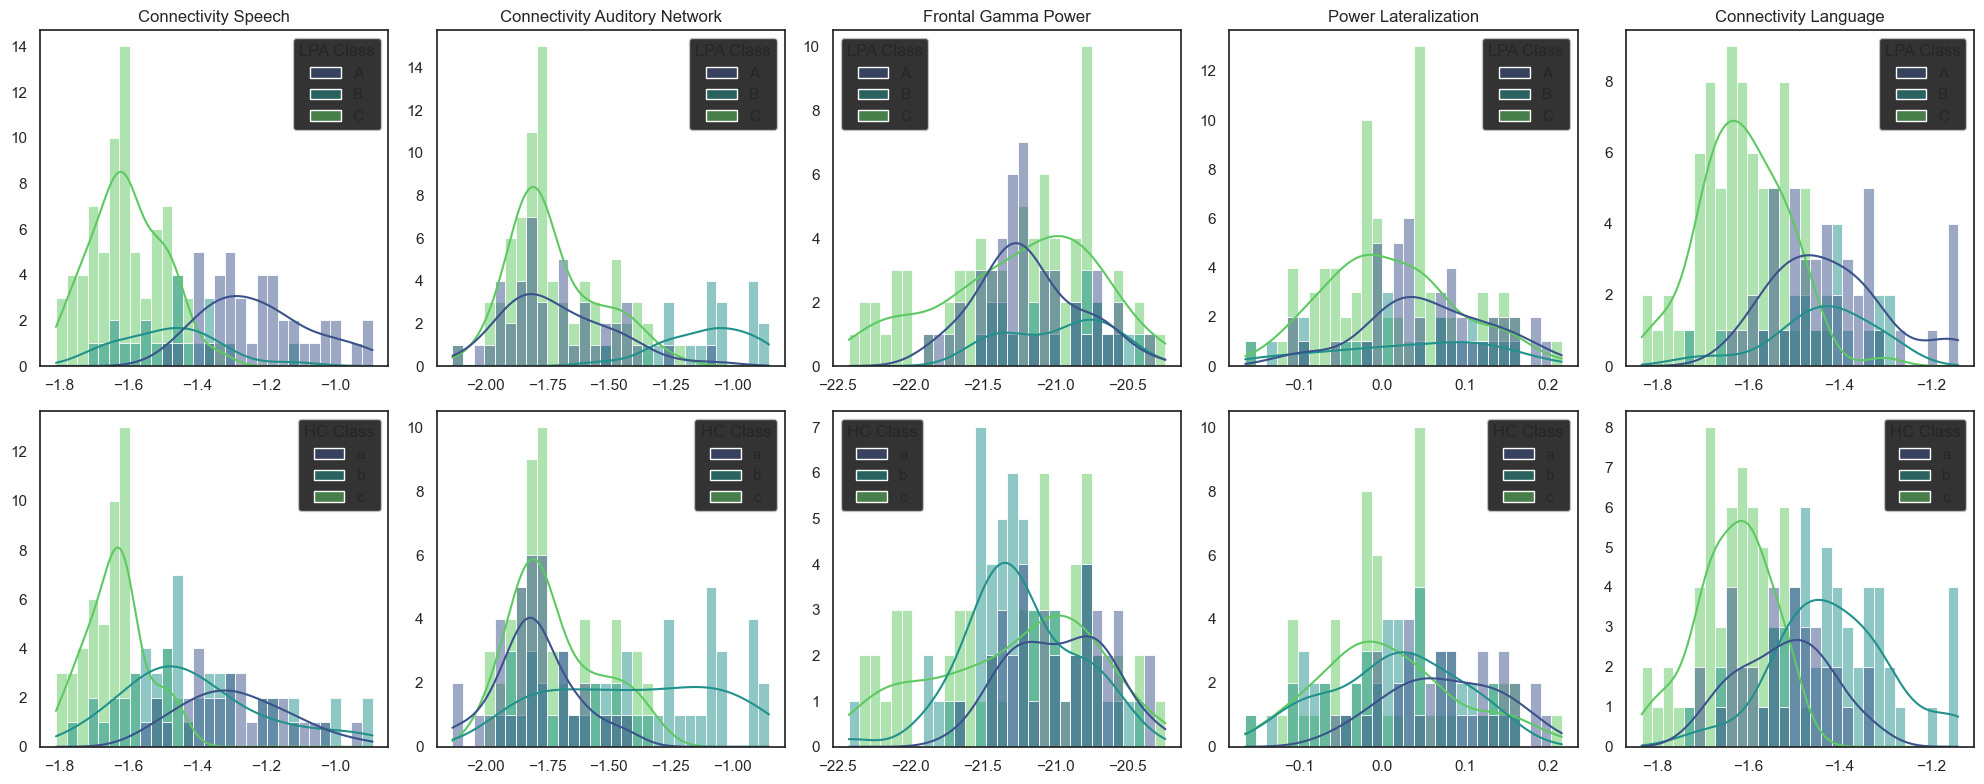

In [251]:
# Plot hitogram of each variable in eeg vars

# Create 4 subplots
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

sns.histplot(data=plotting_df, x="Connectivity Speech", hue="LPA Class", kde=True, palette=palette, bins=30, alpha=0.5, ax=axs[0, 0])
sns.histplot(data=plotting_df, x="Connectivity Speech", hue="HC Class", kde=True, palette=palette, bins=30, alpha=0.5, ax=axs[1, 0])
axs[0, 0].set_title("Connectivity Speech")
axs[1, 0].set_title("")
axs[0, 0].set_xlabel("")
axs[1, 0].set_xlabel("")
axs[0, 0].set_ylabel("")
axs[1, 0].set_ylabel("")
sns.histplot(data=plotting_df, x="Connectivity Auditory Network", hue="LPA Class", kde=True, palette=palette, bins=30, alpha=0.5, ax=axs[0, 1])
sns.histplot(data=plotting_df, x="Connectivity Auditory Network", hue="HC Class", kde=True, palette=palette, bins=30, alpha=0.5, ax=axs[1, 1])
axs[0, 1].set_title("Connectivity Auditory Network")
axs[1, 1].set_title("")
axs[0, 1].set_xlabel("")
axs[1, 1].set_xlabel("")
axs[0, 1].set_ylabel("")
axs[1, 1].set_ylabel("")
sns.histplot(data=plotting_df, x="Frontal Gamma Power", hue="LPA Class", kde=True, palette=palette, bins=30, alpha=0.5, ax=axs[0, 2])
sns.histplot(data=plotting_df, x="Frontal Gamma Power", hue="HC Class", kde=True, palette=palette, bins=30, alpha=0.5, ax=axs[1, 2])
axs[0, 2].set_title("Frontal Gamma Power")
axs[1, 2].set_title("")
axs[0, 2].set_xlabel("")
axs[1, 2].set_xlabel("")
axs[0, 2].set_ylabel("")
axs[1, 2].set_ylabel("")
sns.histplot(data=plotting_df, x="Power Lateralization", hue="LPA Class", kde=True, palette=palette, bins=30, alpha=0.5, ax=axs[0, 3])
sns.histplot(data=plotting_df, x="Power Lateralization", hue="HC Class", kde=True, palette=palette, bins=30, alpha=0.5, ax=axs[1, 3])
axs[0, 3].set_title("Power Lateralization")
axs[1, 3].set_title("")
axs[0, 3].set_xlabel("")
axs[1, 3].set_xlabel("")
axs[0, 3].set_ylabel("")
axs[1, 3].set_ylabel("")
sns.histplot(data=plotting_df, x="Connectivity Language", hue="LPA Class", kde=True, palette=palette, bins=30, alpha=0.5, ax=axs[0, 4])
sns.histplot(data=plotting_df, x="Connectivity Language", hue="HC Class", kde=True, palette=palette, bins=30, alpha=0.5, ax=axs[1, 4])
axs[0, 4].set_title("Connectivity Language")
axs[1, 4].set_title("")
axs[0, 4].set_xlabel("")
axs[1, 4].set_xlabel("")
axs[0, 4].set_ylabel("")
axs[1, 4].set_ylabel("")
plt.tight_layout()

# Save the plot
if not os.path.exists(f"../../Figures/{date}/"):
    os.makedirs(f"../../Figures/{date}/")

plt.savefig(f"../../Figures/{date}/eeg_features_histograms_{date}.png", dpi=300, bbox_inches='tight')



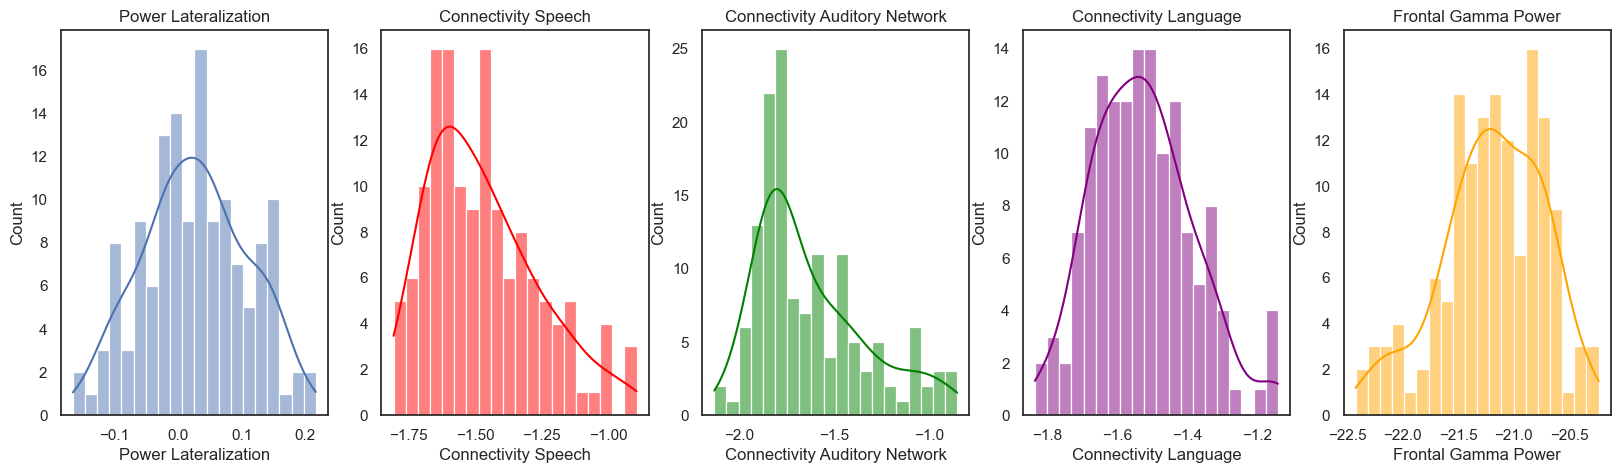

In [253]:
# Plot both features and check if they are normally distributed

# Do subplots 

fig, axs = plt.subplots(1, 5, figsize=(20, 5))
if shapiro(plotting_df["Power Lateralization"])[1] < 0.05:
    print("Power Lateralization is not normally distributed", shapiro(plotting_df["Power Lateralization"])[1])

if shapiro(plotting_df["Connectivity Speech"])[1] < 0.05:
    print("Connectivity Speech is not normally distributed", shapiro(plotting_df["Connectivity Speech"])[1])

if shapiro(plotting_df["Connectivity Auditory Network"])[1] < 0.05:
    print("Connectivity Auditory Network is not normally distributed", shapiro(plotting_df["Connectivity Auditory Network"])[1])

if shapiro(plotting_df["Connectivity Language"])[1] < 0.05:
    print("Connectivity Language is not normally distributed", shapiro(plotting_df["Connectivity Language"])[1])

if shapiro(plotting_df["Frontal Gamma Power"])[1] < 0.05:
    print("Frontal Gamma Power is not normally distributed", shapiro(plotting_df["Frontal Gamma Power"])[1])

sns.histplot(plotting_df["Power Lateralization"], kde=True, ax=axs[0], bins=20)
sns.histplot(plotting_df["Connectivity Speech"], kde=True, ax=axs[1], bins=20, color="red")
sns.histplot(plotting_df["Connectivity Auditory Network"], kde=True, ax=axs[2], bins=20, color="green")
sns.histplot(plotting_df["Connectivity Language"], kde=True, ax=axs[3], bins=20, color="purple")
sns.histplot(plotting_df["Frontal Gamma Power"], kde=True, ax=axs[4], bins=20, color="orange")

# Add title and labels

axs[0].set_title("Power Lateralization")
axs[1].set_title("Connectivity Speech")
axs[2].set_title("Connectivity Auditory Network")
axs[3].set_title("Connectivity Language")
axs[4].set_title("Frontal Gamma Power")

# Save the plot
plt.savefig(f"../../Figures/Supplementary/{date}/eeg_features_individual_histograms_{date}.png", dpi=300, bbox_inches='tight')


### Plot the distribution of the classes


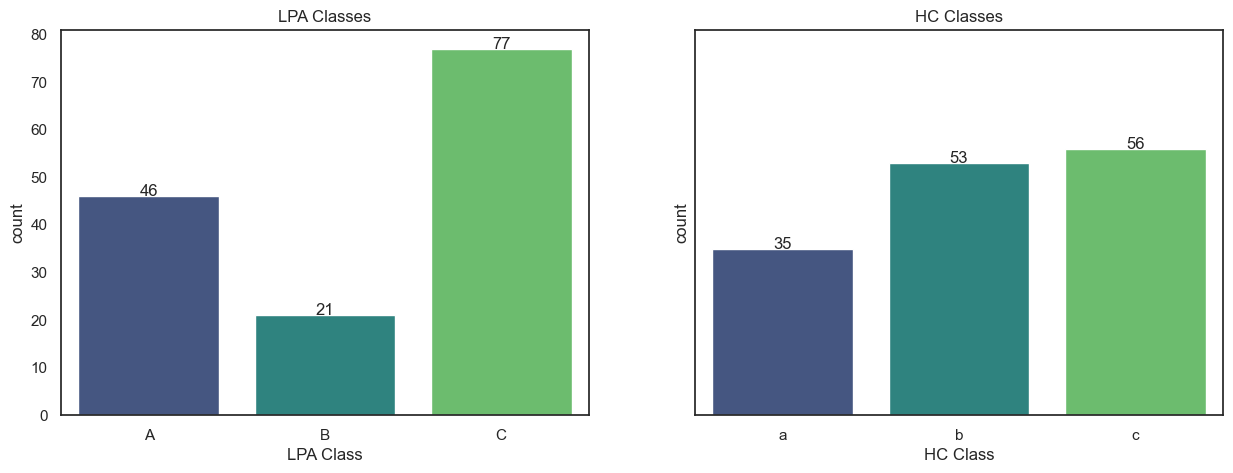

<Figure size 640x480 with 0 Axes>

In [256]:
# Make sure they share the same y-axis
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

sns.countplot(data=plotting_df, x="LPA Class", ax=ax[0], palette=palette)
ax[0].set_title("LPA Classes")

# Add counts to the bars in the plot
for p in ax[0].patches:
    ax[0].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

sns.countplot(data=plotting_df, x="HC Class", ax=ax[1], palette=palette)
ax[1].set_title("HC Classes")

# Add counts to the bars in the plot
for p in ax[1].patches:
    ax[1].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

plt.show()

# Save the plot
plt.savefig(f"../../Figures/Supplementary/{date}/LPA_HC_classes_size_{date}.png", dpi=300, bbox_inches='tight')


### **3D Plotting** classes using UMAP or t-SNE

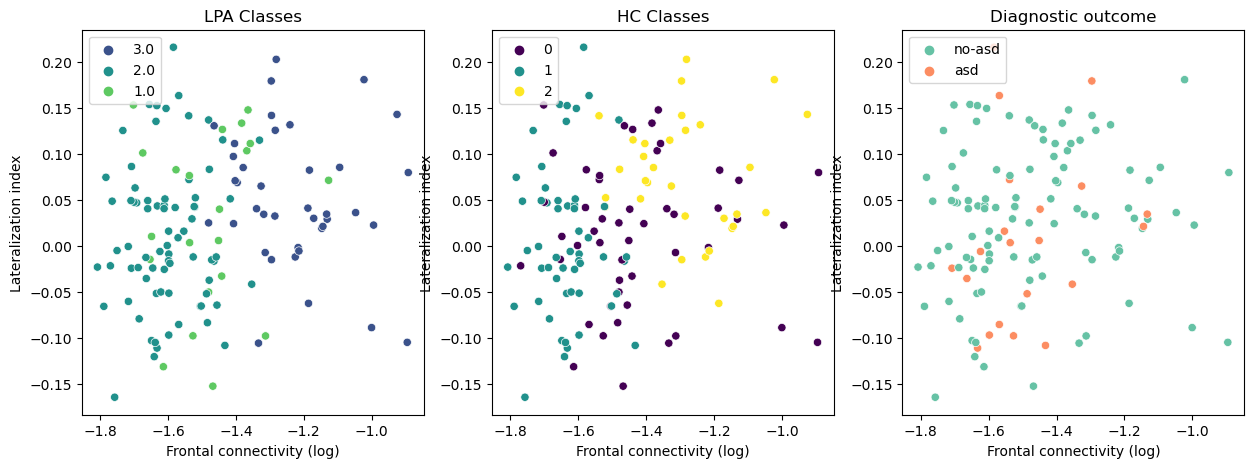

In [48]:
# Plot 2D scatterplot of the classes

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# Plot the distribution of the classes
sns.scatterplot(data=neurosubs_df, x="speech_con_6_left", y="gamma_lat_6", hue="lpa_class", ax=ax[0], palette="viridis")
ax[0].get_legend().remove()
ax[0].legend(loc='upper left')
ax[0].set_title("LPA Classes")
ax[0].set_ylabel("Lateralization index")
ax[0].set_xlabel("Frontal connectivity (log)")

sns.scatterplot(data=neurosubs_df, x="speech_con_6_left", y="gamma_lat_6", hue="hc_class", ax=ax[1], palette="viridis", legend="full",hue_order=["A", "B"])
ax[1].get_legend().remove()
ax[1].legend(loc='upper left')
ax[1].set_title("HC Classes")
ax[1].set_ylabel("Lateralization index")
ax[1].set_xlabel("Frontal connectivity (log)")


# Plot the distribution of outcomes
sns.scatterplot(data=neurosubs_df, x="speech_con_6_left", y="gamma_lat_6", hue="outcome",ax=ax[2], palette="Set2")
ax[2].legend(loc='upper left')
ax[2].set_title("Diagnostic outcome")
ax[2].set_ylabel("Lateralization index")
ax[2].set_xlabel("Frontal connectivity (log)")

plt.show()

Text(0.5, 1.0, 'Risk differences')

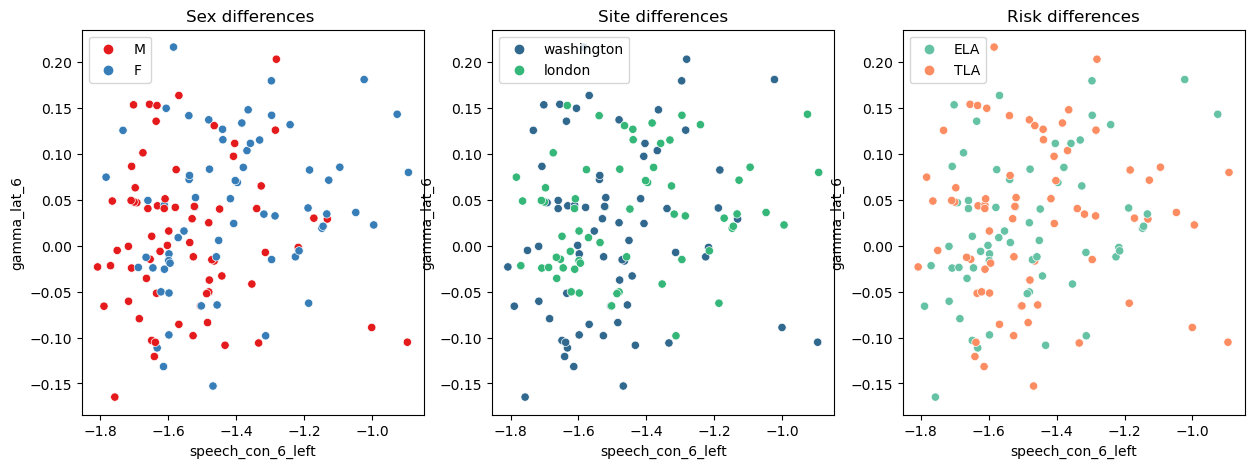

In [49]:
# Plot 2D scatterplot of the classes

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# Plot the distribution of the classes
sns.scatterplot(data=neurosubs_df, x="speech_con_6_left", y="gamma_lat_6", hue="sex", ax=ax[0], palette="Set1")
ax[0].legend(loc='upper left')
ax[0].set_title("Sex differences ")


sns.scatterplot(data=neurosubs_df, x="speech_con_6_left", y="gamma_lat_6", hue="site", ax=ax[1], palette="viridis")
ax[1].legend(loc='upper left')
ax[1].set_title("Site differences")

# Plot the distribution of outcomes
sns.scatterplot(data=neurosubs_df, x="speech_con_6_left", y="gamma_lat_6", hue="group_type",ax=ax[2], palette="Set2")
ax[2].legend(loc='upper left')
ax[2].set_title("Risk differences")


In [50]:
# Table of descriptive statistics for the variables of interest by class

# Select the variables of interest
vars_interest = ["speech_con_6_left", "gamma_lat_6"]

# Group by class and calculate the mean and standard deviation
hc_groups_table=neurosubs_df.groupby("hc_class")[vars_interest].describe().round(2).reset_index()
hc_groups_table



hc_class speech_con_6_left                                            \
                       count  mean   std   min   25%   50%   75%   max   
0        0              52.0 -1.41  0.21 -1.77 -1.54 -1.45 -1.32 -0.89   
1        1              56.0 -1.63  0.09 -1.81 -1.69 -1.63 -1.60 -1.43   
2        2              32.0 -1.29  0.15 -1.54 -1.40 -1.30 -1.18 -0.93   

  gamma_lat_6                                            
        count  mean   std   min   25%   50%   75%   max  
0        50.0  0.01  0.08 -0.15 -0.04  0.02  0.08  0.15  
1        54.0  0.01  0.08 -0.16 -0.05 -0.01  0.05  0.22  
2        35.0  0.08  0.07 -0.06  0.03  0.07  0.13  0.20

In [257]:

# Group by class and calculate the mean and standard deviation
lpa_groups_table=neurosubs_df.groupby("lpa_class")[vars_interest].describe().round(2).reset_index()
lpa_groups_table


NameError: name 'vars_interest' is not defined

In [52]:
neurosubs_df.hc_class

0      0
1      1
2      1
3      1
4      1
      ..
139    2
140    1
141    0
142    1
143    0
Name: hc_class, Length: 144, dtype: int64

### Plot mean gamma_lat_6 and speech_con_6_left values for each class


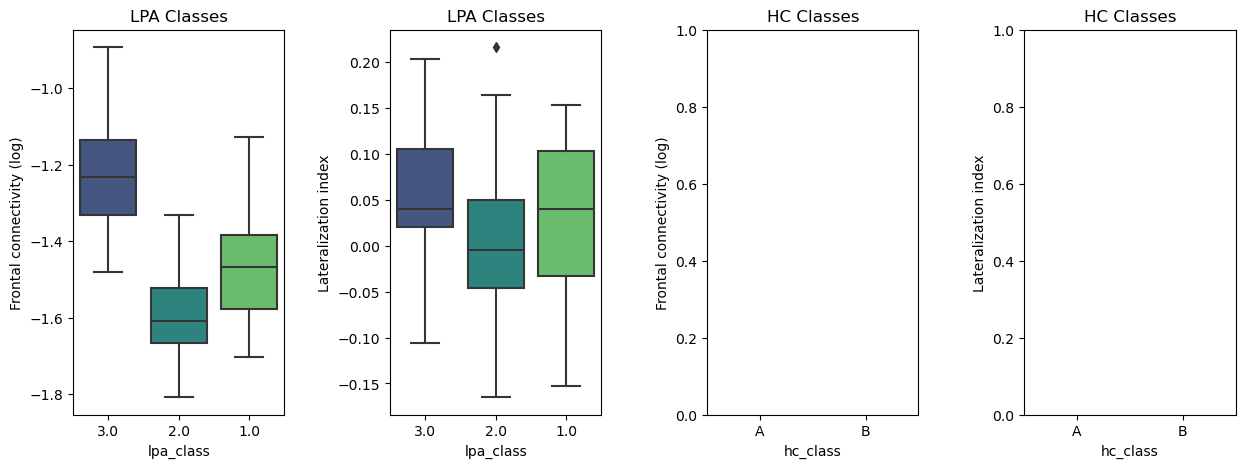

In [53]:
# Plot mean gamma_lat_6 and speech_con_6_left values for each class

fig, ax = plt.subplots(1, 4, figsize=(15, 5))
# Plot the distribution of the LPA classes

sns.boxplot(data=neurosubs_df, x="lpa_class", y="speech_con_6_left", ax=ax[0], palette="viridis")
ax[0].set_title("LPA Classes")
ax[0].set_ylabel("Frontal connectivity (log)")

# Plot the distribution of the LPA classes
sns.boxplot(data=neurosubs_df, x="lpa_class", y="gamma_lat_6", ax=ax[1], palette="viridis")
ax[1].set_title("LPA Classes")
ax[1].set_ylabel("Lateralization index")

# Plot the distribution of the HC classes
sns.boxplot(data=neurosubs_df, x="hc_class", y="speech_con_6_left", ax=ax[2], palette="viridis", hue_order=["A", "B"], order=["A", "B"])
ax[2].set_title("HC Classes")
ax[2].set_ylabel("Frontal connectivity (log)")

# Plot the distribution of the HC classes
sns.boxplot(data=neurosubs_df, x="hc_class", y="gamma_lat_6", ax=ax[3], palette="viridis", hue_order=["A", "B"], order=["A", "B"])
ax[3].set_title("HC Classes")
ax[3].set_ylabel("Lateralization index")



# Add more space in between the plots
plt.subplots_adjust(wspace=0.5)
plt.show()

Text(0, 0.5, 'Lateralization index')

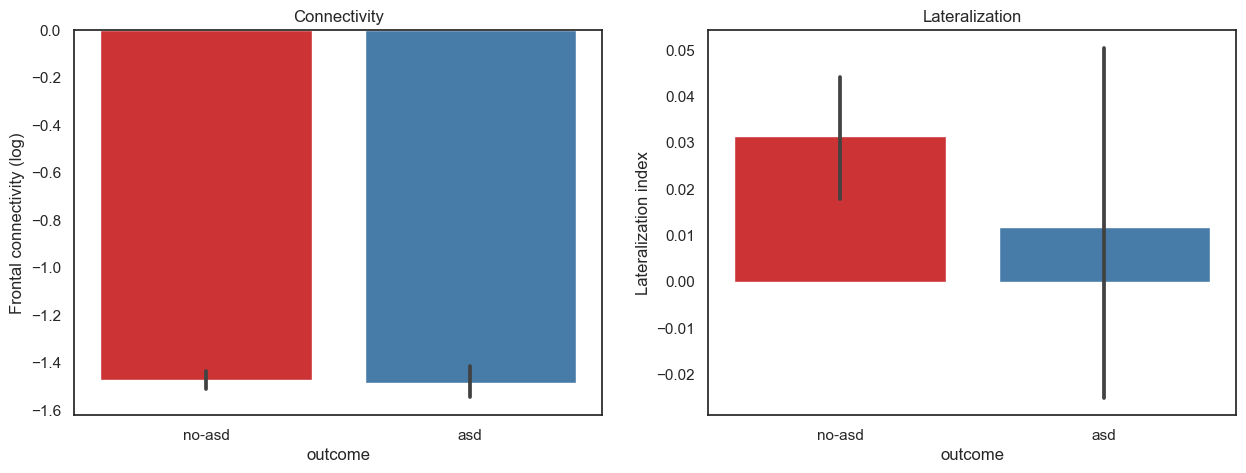

In [258]:

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(data=neurosubs_df, x="outcome", y="speech_con_6_left", ax=ax[0], palette="Set1")
ax[0].set_title("Connectivity")
ax[0].set_ylabel("Frontal connectivity (log)")

# Plot the distribution of the LPA classes
sns.barplot(data=neurosubs_df, x="outcome", y="gamma_lat_6", ax=ax[1], palette="Set1")
ax[1].set_title("Lateralization")
ax[1].set_ylabel("Lateralization index")


In [55]:
neurosubs_df

subject  hc_class  gamma_lat_6  speech_con_6_left  auditory_con_6  \
0          2         0          NaN          -1.225266       -1.598480   
1          3         1     0.040530          -1.659758       -1.829292   
2          5         1    -0.016544          -1.464546       -1.823852   
3          6         1    -0.164802          -1.757113       -1.429544   
4          8         1    -0.108383          -1.432471       -1.765373   
..       ...       ...          ...                ...             ...   
139      748         2    -0.062543          -1.186238       -1.417463   
140      915         1     0.042839          -1.522898       -1.788839   
141      933         0    -0.097921          -1.526620       -1.071994   
142      937         1          NaN          -1.740539       -1.762447   
143      107         0          NaN          -1.017866       -1.448523   

     lang_comp_con_6  front_gamma_6 lpa_class  prob_class_1  prob_class_2  \
0          -1.161137     -21.420116       3.0         0.003         0.000   
1          -1.516043     -21.072590       2.0         0.000         0.997   
2          -1.619339     -22.141673       2.0         0.000         0.977   
3          -1.602488     -21.630370       2.0         0.008         0.992   
4          -1.587519     -21.588120       2.0         0.000         0.959   
..               ...            ...       ...           ...           ...   
139        -1.516925     -20.735650       3.0         0.112         0.029   
140        -1.603515     -20.919022       2.0         0.000         0.983   
141        -1.285763     -21.463387       1.0         0.999         0.001   
142        -1.702147     -21.106285       2.0         0.000         1.000   
143        -1.552049     -21.268801       3.0         0.003         0.001   

     ...  exp_rec_36        site  group_type  outcome  sex  verbal_quotient_6  \
0    ...         NaN  washington         ELA   no-asd    M                5.0   
1    ...         NaN  washington         ELA   no-asd    M                7.5   
2    ...         NaN  washington         TLA      NaN    M                5.5   
3    ...         NaN  washington         ELA   no-asd    M                5.0   
4    ...         NaN  washington         ELA      asd    M                5.5   
..   ...         ...         ...         ...      ...  ...                ...   
139  ...         3.0      london         TLA   no-asd    F                5.5   
140  ...         NaN  washington         TLA   no-asd    M                5.0   
141  ...         NaN  washington         TLA      asd    M                6.5   
142  ...         NaN  washington         TLA   no-asd    M                6.5   
143  ...         NaN  washington         TLA   no-asd    M                7.5   

     verbal_quotient_12  verbal_quotient_18  verbal_quotient_24  \
0                  13.0                18.0                24.5   
1                  14.0                19.0                24.0   
2                   NaN                 NaN                 NaN   
3                  12.5                20.5                27.5   
4                   9.5                20.5                26.0   
..                  ...                 ...                 ...   
139                10.0                 NaN                29.0   
140                14.0                 NaN                26.0   
141                11.5                24.0                 NaN   
142                 9.0                14.0                 NaN   
143                 NaN                 NaN                 NaN   

     verbal_quotient_36  
0                   NaN  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN  
..                  ...  
139                58.5  
140                 NaN  
141                 NaN  
142                 NaN  
143                 NaN  

[144 rows x 38 columns]

Text(0, 0.5, 'AE scores at 36mo')

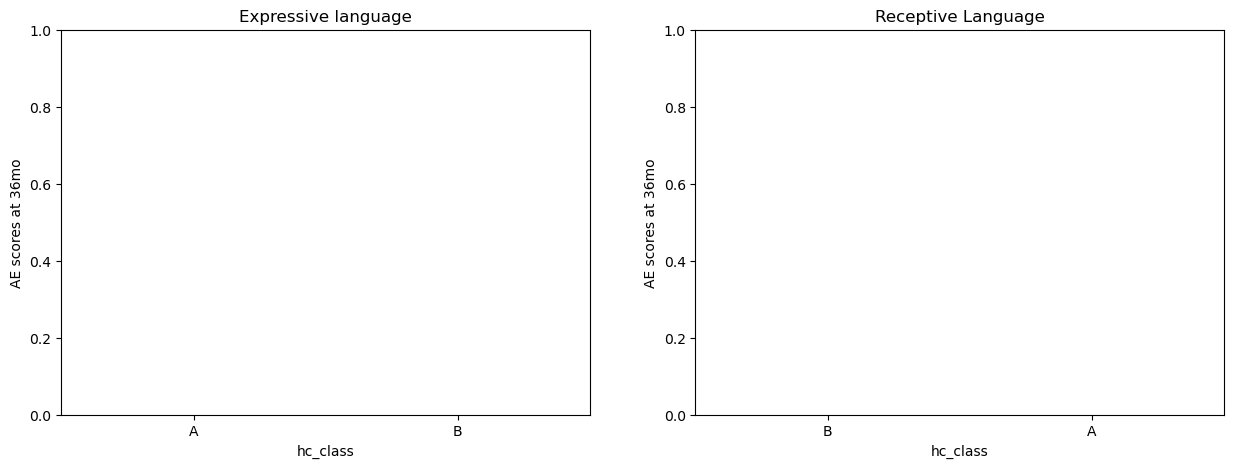

In [56]:

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=neurosubs_df, x="hc_class", y="expressive_36", ax=ax[0], palette= "viridis", hue_order=["A", "B"], order=["A", "B"])
ax[0].set_title("Expressive language")
ax[0].set_ylabel("AE scores at 36mo")

# Plot the distribution of the LPA classes
sns.boxplot(data=neurosubs_df, x="hc_class", y="receptive_36", ax=ax[1], palette= "viridis", hue_order=["B", "A"], order=["B", "A"])
ax[1].set_title("Receptive Language")
ax[1].set_ylabel("AE scores at 36mo")

In [57]:
neurosubs_df.lpa_class.unique()

array(['3.0', '2.0', '1.0'], dtype=object)

In [58]:
neurosubs_df.hc_class.unique()

array([0, 1, 2], dtype=int64)

In [75]:
neurosubs_df[(neurosubs_df["lpa_class"] == "2.0") & (~neurosubs_df.gamma_lat_6.isna())]

subject  hc_class  gamma_lat_6  speech_con_6_left  auditory_con_6  \
1          3         1     0.040530          -1.659758       -1.829292   
2          5         1    -0.016544          -1.464546       -1.823852   
3          6         1    -0.164802          -1.757113       -1.429544   
4          8         1    -0.108383          -1.432471       -1.765373   
6         16         1     0.049333          -1.659671       -1.767821   
..       ...       ...          ...                ...             ...   
130      737         1    -0.065474          -1.502283       -1.453696   
131      739         1    -0.050175          -1.621081       -1.895885   
135      743         1    -0.018941          -1.594444       -1.981048   
136      745         1    -0.051479          -1.597471       -1.578633   
140      915         1     0.042839          -1.522898       -1.788839   

     lang_comp_con_6  front_gamma_6 lpa_class  prob_class_1  prob_class_2  \
1          -1.516043     -21.072590       2.0         0.000         0.997   
2          -1.619339     -22.141673       2.0         0.000         0.977   
3          -1.602488     -21.630370       2.0         0.008         0.992   
4          -1.587519     -21.588120       2.0         0.000         0.959   
6          -1.581775     -21.033680       2.0         0.000         0.998   
..               ...            ...       ...           ...           ...   
130        -1.601606     -21.760904       2.0         0.032         0.957   
131        -1.526806     -20.971280       2.0         0.000         0.997   
135        -1.514616     -21.051897       2.0         0.000         0.992   
136        -1.596877     -20.751971       2.0         0.006         0.992   
140        -1.603515     -20.919022       2.0         0.000         0.983   

     ...  exp_rec_36        site  group_type  outcome  sex  verbal_quotient_6  \
1    ...         NaN  washington         ELA   no-asd    M                7.5   
2    ...         NaN  washington         TLA      NaN    M                5.5   
3    ...         NaN  washington         ELA   no-asd    M                5.0   
4    ...         NaN  washington         ELA      asd    M                5.5   
6    ...         NaN  washington         ELA   no-asd    F                7.5   
..   ...         ...         ...         ...      ...  ...                ...   
130  ...        -9.0      london         TLA   no-asd    F               11.5   
131  ...         5.0      london         TLA   no-asd    F                7.0   
135  ...        -1.0      london         TLA      NaN    F                5.5   
136  ...         3.0      london         TLA      NaN    F                8.0   
140  ...         NaN  washington         TLA   no-asd    M                5.0   

     verbal_quotient_12  verbal_quotient_18  verbal_quotient_24  \
1                  14.0                19.0                24.0   
2                   NaN                 NaN                 NaN   
3                  12.5                20.5                27.5   
4                   9.5                20.5                26.0   
6                  12.0                27.0                33.0   
..                  ...                 ...                 ...   
130                15.0                 NaN                26.0   
131                14.5                 NaN                27.5   
135                 NaN                 NaN                28.5   
136                 NaN                 NaN                34.5   
140                14.0                 NaN                26.0   

     verbal_quotient_36  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN  
6                   NaN  
..                  ...  
130                32.5  
131                48.5  
135                50.5  
136                48.5  
140                 NaN  

[75 rows x 38 columns]

In [78]:
# Test if gamma lateralization is statistically significant from 0  using one sample t test 

if shapiro(neurosubs_df["gamma_lat_6"])[1]> 0.05:
    print("Test gamma lateralization at 6 months LPA")
    print("Class 1", mannwhitneyu(neurosubs_df[(neurosubs_df["lpa_class"] == "1.0") & (~neurosubs_df.gamma_lat_6.isna())]["gamma_lat_6"], 0))
    print("Class 2", mannwhitneyu(neurosubs_df[(neurosubs_df["lpa_class"] == "2.0") & (~neurosubs_df.gamma_lat_6.isna())]["gamma_lat_6"], 0))
    print("Class 3", mannwhitneyu(neurosubs_df[(neurosubs_df["lpa_class"] == "3.0") & (~neurosubs_df.gamma_lat_6.isna())]["gamma_lat_6"], 0))
else:
    print("Not normal gamma lateralization at 6 months LPA")
    print("Class 1", stats.ttest_1samp(neurosubs_df[neurosubs_df["lpa_class"] == "1.0"]["gamma_lat_6"], 0))
    print("Class 2", stats.ttest_1samp(neurosubs_df[neurosubs_df["lpa_class"] == "2.0"]["gamma_lat_6"], 0))
    print("Class 3", stats.ttest_1samp(neurosubs_df[neurosubs_df["lpa_class"] == "3.0"]["gamma_lat_6"], 0))


Test gamma lateralization at 6 months LPA
Class 1 MannwhitneyuResult(statistic=14.0, pvalue=0.7272727272727274)
Class 2 MannwhitneyuResult(statistic=36.0, pvalue=0.973684210526315)
Class 3 MannwhitneyuResult(statistic=33.0, pvalue=0.5000000000000001)


In [81]:
# Test if gamma lateralization is statistically significant from 0  using one sample t test 

if shapiro(neurosubs_df["gamma_lat_6"])[1] > 0.05:
    print("Not normal gamma lateralization at 6 months HC")
    print("Class 1", mannwhitneyu(neurosubs_df[(neurosubs_df["hc_class"] == 0) & (~neurosubs_df.gamma_lat_6.isna())]["gamma_lat_6"], 0))
    print("Class 2", mannwhitneyu(neurosubs_df[(neurosubs_df["hc_class"] == 1) & (~neurosubs_df.gamma_lat_6.isna())]["gamma_lat_6"], 0))
    print("Class 3", mannwhitneyu(neurosubs_df[(neurosubs_df["hc_class"] == 2) & (~neurosubs_df.gamma_lat_6.isna())]["gamma_lat_6"], 0))

else:
    print("Test gamma lateralization at 6 months HC")
    print("Class 1", stats.ttest_1samp(neurosubs_df[neurosubs_df["hc_class"] == 0]["gamma_lat_6"], 0))
    print("Class 2", stats.ttest_1samp(neurosubs_df[neurosubs_df["hc_class"] == 1]["gamma_lat_6"], 0))

Not normal gamma lateralization at 6 months HC
Class 1 MannwhitneyuResult(statistic=31.0, pvalue=0.7843137254901957)
Class 2 MannwhitneyuResult(statistic=23.0, pvalue=0.8727272727272729)
Class 3 MannwhitneyuResult(statistic=29.0, pvalue=0.38888888888888895)


c:\Users\gabot\anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\gabot\anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\gabot\anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\gabot\anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\gabot\anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprec

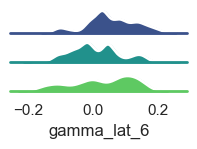

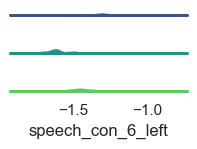

In [82]:

# Set the style
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Define the color palette
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

# Initialize the FacetGrid object for hc_class
g = sns.FacetGrid(neurosubs_df, row="lpa_class", hue="lpa_class", aspect=5, height=.5, palette="viridis", sharex=True, sharey=True)

# Draw the densities for hc_class
g.map(sns.kdeplot, "gamma_lat_6", clip_on=False, fill=True, alpha=1, lw=1.5, bw_adjust=.5)
g.map(sns.kdeplot, "gamma_lat_6", clip_on=False, color="w", lw=2, bw_adjust=.5)

# Add title to the plot
g.set_titles("HC Class {row_name}")


# Initialize another FacetGrid for lpa_class on top of the previous one, with shared axes
g2 = sns.FacetGrid(neurosubs_df, row="lpa_class", hue="lpa_class", aspect=5, height=.5, palette="viridis", sharex=True, sharey=True)

# Draw the densities for lpa_class
g2.map(sns.kdeplot, "speech_con_6_left", clip_on=False, fill=True, alpha=1, lw=1.5, bw_adjust=.5)
g2.map(sns.kdeplot, "speech_con_6_left", clip_on=False, color="w", lw=2, bw_adjust=.5)

# Add horizontal line at y=0 for both plots
g2.map(plt.axhline, y=0, lw=2, clip_on=False)

# Optionally, add reference line at y=0 for both grids
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
g2.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Add the legend
#g.add_legend()
#g2.add_legend()


# Adjust the spacing between plots
g.figure.subplots_adjust(hspace=.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g2.set_titles("")
g2.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g2.despine(bottom=True, left=True)

# Show the plot
plt.show()




c:\Users\gabot\anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\gabot\anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\gabot\anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\gabot\anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\gabot\anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprec

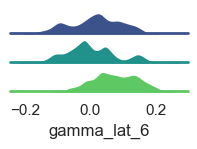

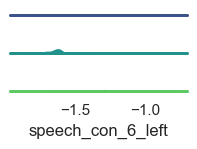

In [83]:

# Set the style
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Define the color palette
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

# Initialize the FacetGrid object for hc_class
g = sns.FacetGrid(neurosubs_df, row="hc_class", hue="hc_class", aspect=5, height=.5, palette="viridis", sharex=True, sharey=True)

# Draw the densities for hc_class
g.map(sns.kdeplot, "gamma_lat_6", clip_on=False, fill=True, alpha=1, lw=1.5, bw_adjust=.5)
g.map(sns.kdeplot, "gamma_lat_6", clip_on=False, color="w", lw=2, bw_adjust=.5)

# Add title to the plot
g.set_titles("HC Class {row_name}")


# Initialize another FacetGrid for lpa_class on top of the previous one, with shared axes
g2 = sns.FacetGrid(neurosubs_df, row="hc_class", hue="hc_class", aspect=5, height=.5, palette="viridis", sharex=True, sharey=True)

# Draw the densities for lpa_class
g2.map(sns.kdeplot, "speech_con_6_left", clip_on=False, fill=True, alpha=1, lw=1.5, bw_adjust=.5)
g2.map(sns.kdeplot, "speech_con_6_left", clip_on=False, color="w", lw=2, bw_adjust=.5)

# Add horizontal line at y=0 for both plots
g2.map(plt.axhline, y=0, lw=2, clip_on=False)

# Optionally, add reference line at y=0 for both grids
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
g2.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Add the legend
#g.add_legend()
#g2.add_legend()


# Adjust the spacing between plots
g.figure.subplots_adjust(hspace=.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g2.set_titles("")
g2.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g2.despine(bottom=True, left=True)

# Show the plot
plt.show()

c:\Users\gabot\anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\gabot\anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\gabot\anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\gabot\anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\gabot\anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprec

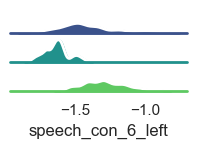

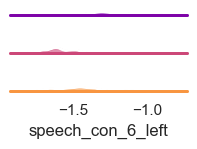

In [84]:

# Set the style
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Define the color palette
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

# Initialize the FacetGrid object for hc_class
g = sns.FacetGrid(neurosubs_df, row="hc_class", hue="hc_class", aspect=5, height=.5, palette="viridis", sharex=True, sharey=True)

# Draw the densities for hc_class
g.map(sns.kdeplot, "speech_con_6_left", clip_on=False, fill=True, alpha=1, lw=1.5, bw_adjust=.5)
g.map(sns.kdeplot, "speech_con_6_left", clip_on=False, color="w", lw=2, bw_adjust=.5)

# Initialize another FacetGrid for lpa_class on top of the previous one, with shared axes
g2 = sns.FacetGrid(neurosubs_df, row="lpa_class", hue="lpa_class", aspect=5, height=.5, palette="plasma", sharex=True, sharey=True)

# Draw the densities for lpa_class
g2.map(sns.kdeplot, "speech_con_6_left", clip_on=False, fill=True, alpha=0.6, lw=1.5, bw_adjust=.5)
g2.map(sns.kdeplot, "speech_con_6_left", clip_on=False, color="w", lw=2, bw_adjust=.5)

# Add horizontal line at y=0 for both plots
g2.map(plt.axhline, y=0, lw=2, clip_on=False)

# Optionally, add reference line at y=0 for both grids
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
g2.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Adjust the spacing between plots
g.figure.subplots_adjust(hspace=.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g2.set_titles("")
g2.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g2.despine(bottom=True, left=True)

# Show the plot
plt.show()

In [85]:
# Reset the sns style
sns.set()

In [86]:
neurosubs_df["hc_class"]

0      0
1      1
2      1
3      1
4      1
      ..
139    2
140    1
141    0
142    1
143    0
Name: hc_class, Length: 144, dtype: int64

In [87]:
# Group A = High connectivity and right hemisphere lateralization
# Group B = Low connectivity and no hemisphere lateralization

#### Add labels and order

In [88]:
# Renanme classes so that they are in both groups 
neurosubs_df["lpa_class"] = neurosubs_df["lpa_class"].replace({"1.0": "a", "2.0": "b", "3.0": "c"})
neurosubs_df["hc_class"] = neurosubs_df["hc_class"].replace({0: "A", 1: "B", 2: "C"})
#neurosubs_df["lpa_class"] = neurosubs_df["lpa_class"].replace({"1.0": "High con left", "2.0": "Low con left"})

#neurosubs_df["hc_class"] = neurosubs_df["hc_class"].replace({0: "High con left", 1: "Low con sym"})

#neurosubs_df["lpa_class"] = neurosubs_df["lpa_class"].replace({"1.0": "High Avg", "2.0": "Low Avg"})
#neurosubs_df["hc_class"] = neurosubs_df["hc_class"].replace({0: "High Avg", 1: "Low Avg"})

In [89]:
# Specify the order of the groups (example)
hc_order = ["A", "B", "C"]  # Update with actual class names
lpa_order = ["a", "b", "c"]  # Update with actual class names

# Specify the order of the groups (example)
#hc_order = ["High Avg", "Low Avg"]  # Update with actual class names
#lpa_order = ["High Avg", "Low Avg"]  # Update with actual class names

#hc_order = ["High con left", "Low con sym"]  # Update with actual class names


In [141]:


# Filter out rows with hc_class or lpa_class
graphing_df = neurosubs_df

# Create two separate dataframes for each class
hc_graph_df = graphing_df[graphing_df["hc_class"].isin(hc_order)]
mp_graph_df = graphing_df[graphing_df["lpa_class"].isin(lpa_order)]

# Sort the each column for each dataframe by the specified order
hc_graph_df["hc_class"] = pd.Categorical(hc_graph_df["hc_class"], categories=hc_order, ordered=True)
mp_graph_df["lpa_class"] = pd.Categorical(mp_graph_df["lpa_class"], categories=lpa_order, ordered=True)


layout = [
    ["A", "B"],
    ["C", "D"],
    ["E", "F"],
    ["G", "H"],
    ["I", "J"]]
fig, axd = plt.subplot_mosaic(layout, figsize=(25, 50))

# Add main title
fig.suptitle('Demographic characteristics by hc_class and lpa_class', fontsize=16)

# Function to plot for a given class and axis
def plot_class_distribution(df, class_col, ax, title, order):
    sns.barplot(x=df[class_col].value_counts().index, y=df[class_col].value_counts().values, palette="Set2", ax=ax, order=order)
    # add ylims
    ax.set_title(title)
    ax.set_xlabel(class_col)
    ax.set_ylabel("Number of participants")
    ax.set_ylim(0, 120)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45,
    )

# Plot 1 & 2 for hc_class and lpa_class size
plot_class_distribution(hc_graph_df, 'hc_class', axd["A"], "HC Class Size", hc_order)
plot_class_distribution(graphing_df, 'lpa_class', axd["B"], "MP Class Size", lpa_order)

# Function to plot proportion of ASD with specified order
def plot_proportion_asd(df, class_col, ax, order):
    # Group by the specified class column and calculate outcome proportions
    outcome_dist = df.groupby(class_col)["outcome"].value_counts().unstack().reset_index().fillna(0)
    outcome_dist["total"] = outcome_dist["asd"] + outcome_dist["no-asd"]
    outcome_dist["asd"] = outcome_dist["asd"] / outcome_dist["total"]

    # Sort the outcome distribution by the specified order
    outcome_dist = outcome_dist.set_index(class_col).loc[order].reset_index()

    sns.barplot(x=outcome_dist[class_col], y=outcome_dist["asd"], palette="Blues", ax=ax)
    ax.set_title(f"Proportion of ASD in each {class_col}")
    ax.set_xlabel(class_col)
    ax.set_ylim(0, 0.5)

    ax.set_ylabel("Percentage ASD in study (%)")

# Plot 3 & 4 for proportions with the specified order
plot_proportion_asd(hc_graph_df, 'hc_class', axd["C"], hc_order)
plot_proportion_asd(mp_graph_df, 'lpa_class', axd["D"], lpa_order)

# Function for stacked distributions
def plot_stacked_distribution(df, class_col, ax, colors, title):
    dist = df.groupby(class_col)["group_type"].value_counts().unstack().reset_index().fillna(0)
    dist["total"] = dist["ELA"] + dist["TLA"]
    dist["ELA"] = dist["ELA"] / dist["total"]
    dist["TLA"] = dist["TLA"] / dist["total"]
    dist.index = dist[class_col]
    dist.drop(columns=[class_col, "total"], inplace=True)
    dist.plot(kind="bar", stacked=True, color=colors, ax=ax)
    ax.set_title(title)
    ax.set_ylim(0, 1.3)
    ax.legend(title="Outcome", loc='upper left', labels=['ELA', 'TLA'], ncol=2)

# Plot stacked distributions for outcomes
plot_stacked_distribution(hc_graph_df, 'hc_class', axd["E"], ['salmon','skyblue'], "Proportion of Outcomes by HC Class")
plot_stacked_distribution(mp_graph_df, 'lpa_class', axd["F"], ['salmon','skyblue'], "Proportion of Outcomes by MP Class")

# Plot 5: Distribution of sex in each class
def plot_sex_distribution(df, class_col, ax):
    sex_dist = df.groupby(class_col)["sex"].value_counts().unstack().reset_index().fillna(0)
    sex_dist["total"] = sex_dist["F"] + sex_dist["M"]
    sex_dist["F"] = sex_dist["F"] / sex_dist["total"]
    sex_dist["M"] = sex_dist["M"] / sex_dist["total"]
    sex_dist.index = sex_dist[class_col]
    sex_dist.drop(columns=[class_col, "total"], inplace=True)
    sex_dist.plot(kind="bar", stacked=True, color=['firebrick', 'steelblue'], ax=ax)
    ax.set_title(f"Sex Distribution by {class_col}")
    ax.set_ylim(0, 1.3)
    ax.legend(title="Sex", loc='upper right')

# Plot 5 & 6 for sex distribution
plot_sex_distribution(hc_graph_df, 'hc_class', axd["G"])
plot_sex_distribution(mp_graph_df, 'lpa_class', axd["H"])

# Plot 7: Site distribution in each class
def plot_site_distribution(df, class_col, ax):
    site_dist = df.groupby(class_col)["site"].value_counts().unstack().reset_index().fillna(0)
    site_dist["total"] = site_dist["london"] + site_dist["washington"]
    site_dist["london"] = site_dist["london"] / site_dist["total"]
    site_dist["washington"] = site_dist["washington"] / site_dist["total"]
    site_dist.index = site_dist[class_col]
    site_dist.drop(columns=[class_col, "total"], inplace=True)
    site_dist.plot(kind="bar", stacked=True, color=['darkorange', 'darkblue'], ax=ax)
    ax.set_title(f"Site Distribution by {class_col}")
    ax.set_ylim(0, 1.3)
    ax.legend(title="Site", loc='upper right')

# Plot 7 & 8 for site distribution
plot_site_distribution(hc_graph_df, 'hc_class', axd["I"])
plot_site_distribution(mp_graph_df, 'lpa_class', axd["J"])

# Final adjustments
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


NameError: name 'hc_order' is not defined

### Sankey Plot

In [91]:
# Create a contingency table
contingency_table = pd.crosstab(neurosubs_df['hc_class'], neurosubs_df['lpa_class'])
print(contingency_table)

lpa_class   a   b   c
hc_class             
A          21  13  19
B           0  56   0
C           0   8  27


In [92]:
# Calculate overlap
overlap = contingency_table.values.diagonal().sum()
total_samples = contingency_table.values.sum()
degree_of_overlap = overlap / total_samples
print("Degree of Overlap:", degree_of_overlap)


Degree of Overlap: 0.7222222222222222


In [93]:
import plotly.graph_objects as go

# Prepare data for the Sankey diagram
source = []
target = []
values = []

# Get the number of clusters in hc_class and lpa_class
hc_labels = list(contingency_table.index)
lpa_labels = list(contingency_table.columns)

for hc_index, hc_cluster in enumerate(hc_labels):
    for lpa_index, lpa_cluster in enumerate(lpa_labels):
        count = contingency_table.loc[hc_cluster, lpa_cluster]
        if count > 0:
            source.append(hc_index)  # Use index for HC clusters
            target.append(lpa_index + len(hc_labels))  # Offset LPA clusters by the number of HC clusters
            values.append(count)

# Make each side have the same color

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=40,
        line=dict(color="black", width=0.5), # Set the line color and width
        label=[f'HC {i}' for i in hc_labels] + 
               [f'LPA {j}' for j in lpa_labels]
    ),
    link=dict(
        source=source,
        target=target,
        value=values
    )
)])

fig.update_layout(title_text="Sankey Diagram of Overlap", font_size=20, width=1000, height=500, autosize=True)
fig.show()



## Test language profiles

In [94]:
results_list = []
results = []
chi_results = []

model_stats = []
    
condition = "5D"

cluster_groups = ["hc_class", "lpa_class"]
#cluster_groups = ["lpa_class"]

results_list.append(condition)
print(results_list)


optimal_cluster_size = 2
# Do t test if two clusters

for group_results in cluster_groups:
    print(group_results)
    comparison_df= neurosubs_df.copy()
    print(len(comparison_df))

    # Do chi squared test for categorical variables
    categorical_vars = ['sex', 'outcome', 'group_type', 'site']

    for var in categorical_vars:
        # Create a contingency table
        contingency_table = pd.crosstab(comparison_df[group_results], comparison_df[var])
        print(f"Contingency table for {var}:")
        print(contingency_table)
        
        # Perform Chi-Squared test
        chi2_stat, p_value, _, _ = chi2_contingency(contingency_table, correction=False)
        chi_results.append({'Variable': var, 'p_value': p_value, 'chi2_stat': chi2_stat,"analyis": group_results})

    # Convert results to DataFrame
    chi_results_df = pd.DataFrame(chi_results)

    # Apply FDR correction
    chi_results_df['p_value_adj'] = multipletests(chi_results_df['p_value'], method='fdr_bh')[1]

    for var in language_vars:
        comparison_df= neurosubs_df.copy()
        comparison_df.dropna(subset=[var], inplace=True)
        print(len(comparison_df))
        # log transform the data
       # comparison_df = comparison_df[(np.abs(stats.zscore(comparison_df[var])) < 3)]
        print(len(comparison_df))
        if "hc" in group_results:
            group1_df = comparison_df.loc[comparison_df[group_results] == hc_order[0]]
            group2_df = comparison_df.loc[comparison_df[group_results] == hc_order[1]]
        else:
            group1_df = comparison_df.loc[comparison_df[group_results] == lpa_order[0]]
            group2_df = comparison_df.loc[comparison_df[group_results] == lpa_order[1]]
        print( "Cluster 2-solution", len(group1_df), len(group2_df))

        group1=group1_df.dropna(subset=[var])
        group2=group2_df.dropna(subset=[var]) 
        
        # Perform OLS
        if var == "expressive_6" or var == "receptive_6":
            iq_covariate = "nonverbal_iq_6"
            model_type= "language"

        elif var == "expressive_12" or var == "receptive_12":
            iq_covariate = "nonverbal_iq_12"
            model_type= "language"

        elif var == "expressive_24" or var == "receptive_24":
            iq_covariate = "nonverbal_iq_24"
            model_type= "language"

        elif var == "expressive_36" or var == "receptive_36":
            iq_covariate = "nonverbal_iq_36"
            model_type= "language"

        else: 
            model_type= "iq"

        if model_type == "language":

            model1 = smf.ols(f"{var} ~ {group_results} + C(sex) + C(site) + {iq_covariate}" , comparison_df)
            model2 = smf.ols(f"{var} ~ {group_results} * C(sex) + C(site) + {iq_covariate}" , comparison_df)
            model3 = smf.ols(f"{var} ~ {group_results} + C(group_type) + C(sex) + C(site) + {iq_covariate}" , comparison_df)
            model4 = smf.ols(f"{var} ~ {group_results} * C(sex) + C(group_type) + C(site) + {iq_covariate}" , comparison_df)
            model5 = smf.ols(f"{var} ~ {group_results} * C(group_type) + C(sex) + C(site) + {iq_covariate}" , comparison_df)
            model6 = smf.ols(f"{var} ~ {group_results} * C(group_type) * C(sex) + C(site) + {iq_covariate}" , comparison_df)
        else: 
            model1 = smf.ols(f"{var} ~ {group_results} + C(sex) + C(site)" , comparison_df)
            model2 = smf.ols(f"{var} ~ {group_results} * C(sex) + C(site)" , comparison_df)
            model3 = smf.ols(f"{var} ~ {group_results} + C(group_type) + C(sex) + C(site)" , comparison_df)
            model4 = smf.ols(f"{var} ~ {group_results} * C(sex) + C(group_type) + C(site)" , comparison_df)
            model5 = smf.ols(f"{var} ~ {group_results} * C(group_type) + C(sex) + C(site)" , comparison_df)
            model6 = smf.ols(f"{var} ~ {group_results} * C(group_type) * C(sex) + C(site)" , comparison_df)
# Save model statistics BIC, AIC, R2
        for model in [model1, model2, model3, model4, model5]:

            model_results = model.fit()
            model_stats.append({"model": model_results.df_model, "BIC": model_results.bic, "AIC": model_results.aic, "R2": model_results.rsquared,
                                 "condition": condition, "latent_class_pval": model_results.pvalues[1], "analysis": group_results, "Measure": var})

        result = model3.fit()
        linear_model_pval =result.pvalues[1]
# save the result
        print(var,result.summary())
    # Check normality assumption
        if shapiro(comparison_df[var])[1] < 0.05:
            print(shapiro(comparison_df[var])[1])
            # Perform Whitney U test
            stat, p = mannwhitneyu(group1[var], group2[var])
            results.append({'condition':condition, 'analysis': group_results, 'Measure': var, "linear_model_pval": linear_model_pval,
                            'p_value': p.round(3), 'cluster': optimal_cluster_size, "Test": "Mann-Whitney U", "T-statistic": (stat*10**-4).round(2),
                            "Total N": len(comparison_df),
                            "N group1": len(group1), "N group2": len(group2), "Mean group1": group1[var].mean().round(2), "Mean group2": group2[var].mean().round(2)})
            if p < 0.05:
                print(f"{var} for {optimal_cluster_size}D-solution is not normally distributed")
                print("****", var, stat, p, "for {optimal_cluster_size}D-solution")
        else:
            
            # Perform t-test
            stat, p = ttest_ind(group1[var], group2[var])
            results.append({'condition':condition,'analysis': group_results,'Measure': var, "linear_model_pval": linear_model_pval,
             'p_value': p.round(3), 'cluster': optimal_cluster_size, "Test": "t-test", "T-statistic": stat.round(2),
                            "Total N": len(comparison_df),                     
                            "N group1": len(group1), "N group2": len(group2), "Mean group1": group1[var].mean().round(2), "Mean group2": group2[var].mean().round(2)})
                            
            if p < 0.05:
                print("****", var, stat, p, "for {optimal_cluster_size}D-solution")
            else:
                print("not significant")
                
    # Apply FDR bonferroni correction

        # Convert results to DataFrame
        results_df = pd.DataFrame(results)
        results_df['p_value_adj'] = multipletests(results_df['p_value'], method='fdr_bh')[1]


['5D']
hc_class
144
Contingency table for sex:
sex        F   M
hc_class        
A         20  33
B         22  34
C         26   9
Contingency table for outcome:
outcome   asd  no-asd
hc_class             
A           8      42
B           9      44
C           5      28
Contingency table for group_type:
group_type  ELA  TLA
hc_class            
A            24   29
B            26   30
C            19   16
Contingency table for site:
site      london  washington
hc_class                    
A             19          34
B             23          33
C             25          10
144
144
Cluster 2-solution 53 56
receptive_6                             OLS Regression Results                            
Dep. Variable:            receptive_6   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     13.80
Date:                Wed, 16 Apr 2025   Prob (F-statis

In [95]:
41/(41+33)
24/(24+40)

0.375

In [96]:
results_df

condition   analysis             Measure  linear_model_pval  p_value  \
0         5D   hc_class         receptive_6           0.929354    0.055   
1         5D   hc_class        expressive_6           0.720910    0.243   
2         5D   hc_class        receptive_12           0.497671    0.365   
3         5D   hc_class       expressive_12           0.431629    0.141   
4         5D   hc_class        receptive_18           0.550865    0.590   
5         5D   hc_class       expressive_18           0.122538    0.024   
6         5D   hc_class        receptive_24           0.053472    0.039   
7         5D   hc_class       expressive_24           0.006842    0.014   
8         5D   hc_class        receptive_36           0.578277    0.908   
9         5D   hc_class       expressive_36           0.859273    0.485   
10        5D   hc_class      nonverbal_iq_6           0.008967    0.008   
11        5D   hc_class     nonverbal_iq_12           0.016056    0.014   
12        5D   hc_class     nonverbal_iq_24           0.910073    0.741   
13        5D   hc_class     nonverbal_iq_36           0.716127    0.545   
14        5D   hc_class   verbal_quotient_6           0.070104    0.082   
15        5D   hc_class  verbal_quotient_12           0.281735    0.227   
16        5D   hc_class  verbal_quotient_18           0.229065    0.216   
17        5D   hc_class  verbal_quotient_24           0.027166    0.015   
18        5D   hc_class  verbal_quotient_36           0.716337    0.655   
19        5D  lpa_class         receptive_6           0.360393    0.844   
20        5D  lpa_class        expressive_6           0.482735    0.526   
21        5D  lpa_class        receptive_12           0.842210    0.668   
22        5D  lpa_class       expressive_12           0.953669    0.778   
23        5D  lpa_class        receptive_18           0.833962    0.902   
24        5D  lpa_class       expressive_18           0.714911    0.540   
25        5D  lpa_class        receptive_24           0.244805    0.235   
26        5D  lpa_class       expressive_24           0.138002    0.102   
27        5D  lpa_class        receptive_36           0.855905    0.371   
28        5D  lpa_class       expressive_36           0.905964    0.219   
29        5D  lpa_class      nonverbal_iq_6           0.021092    0.267   
30        5D  lpa_class     nonverbal_iq_12           0.033521    0.142   
31        5D  lpa_class     nonverbal_iq_24           0.779458    0.817   
32        5D  lpa_class     nonverbal_iq_36           0.704214    0.181   
33        5D  lpa_class   verbal_quotient_6           0.168668    0.615   
34        5D  lpa_class  verbal_quotient_12           0.452243    0.783   
35        5D  lpa_class  verbal_quotient_18           0.744722    0.805   
36        5D  lpa_class  verbal_quotient_24           0.342285    0.158   
37        5D  lpa_class  verbal_quotient_36           0.820656    0.220   

    cluster            Test  T-statistic  Total N  N group1  N group2  \
0         2  Mann-Whitney U         0.12      144        53        56   
1         2  Mann-Whitney U         0.13      144        53        56   
2         2  Mann-Whitney U         0.10      129        46        50   
3         2  Mann-Whitney U         0.10      129        46        50   
4         2          t-test        -0.54       60        26        27   
5         2  Mann-Whitney U         0.02       60        26        27   
6         2  Mann-Whitney U         0.05      100        32        40   
7         2  Mann-Whitney U         0.04      100        32        40   
8         2          t-test         0.12       66        18        23   
9         2  Mann-Whitney U         0.02       66        18        23   
10        2  Mann-Whitney U         0.10      144        53        56   
11        2  Mann-Whitney U         0.08      128        46        49   
12        2          t-test        -0.33      101        33        40   
13        2  Mann-Whitney U         0.02       66      

In [97]:
model_stats_df = pd.DataFrame(model_stats)
model_stats_df

model         BIC         AIC        R2 condition  latent_class_pval  \
0      5.0  530.209516  512.390636  0.371596        5D           0.884013   
1      7.0  531.461748  507.703242  0.408386        5D           0.241749   
2      6.0  534.002519  513.213826  0.376711        5D           0.929354   
3      8.0  535.470045  508.741725  0.412323        5D           0.206042   
4      8.0  542.554731  515.826411  0.382687        5D           0.927537   
..     ...         ...         ...       ...       ...                ...   
185    3.0  466.904763  458.146144  0.160718        5D           0.555602   
186    5.0  475.082169  461.944241  0.163281        5D           0.787069   
187    4.0  462.424982  451.476708  0.264028        5D           0.820656   
188    6.0  470.356461  455.028878  0.269005        5D           0.697582   
189    6.0  468.886723  453.559139  0.285104        5D           0.544257   

      analysis             Measure  
0     hc_class         receptive_6  
1     hc_class         receptive_6  
2     hc_class         receptive_6  
3     hc_class         receptive_6  
4     hc_class         receptive_6  
..         ...                 ...  
185  lpa_class  verbal_quotient_36  
186  lpa_class  verbal_quotient_36  
187  lpa_class  verbal_quotient_36  
188  lpa_class  verbal_quotient_36  
189  lpa_class  verbal_quotient_36  

[190 rows x 8 columns]

In [98]:
chi_results_df

Variable   p_value  chi2_stat    analyis  p_value_adj
0         sex  0.001106  13.614827   hc_class     0.008844
1     outcome  0.974324   0.052023   hc_class     0.974324
2  group_type  0.681852   0.765885   hc_class     0.909136
3        site  0.002709  11.822137   hc_class     0.010837
4         sex  0.340880   2.152449  lpa_class     0.681760
5     outcome  0.561370   1.154750  lpa_class     0.898192
6  group_type  0.900498   0.209615  lpa_class     0.974324
7        site  0.252025   2.756455  lpa_class     0.672066

#### GLM Model

In [99]:
df = neurosubs_df.copy()
df.dropna(subset=["receptive_6", "nonverbal_iq_6", "sex"], inplace=True) 

# Create dummy variables for categorical predictors (like hc_class, sex, site)
df = pd.get_dummies(df, drop_first=True)  # This will drop the first category for each categorical variable

# Define the independent variables (X) and dependent variable (y)
X = df[['lpa_class_Low Avg', 'sex_M', "group_type_TLA",'nonverbal_iq_6']]  # Use appropriate columns
y = df['receptive_6']

# Add a constant to the independent variables (for intercept)
X = sm.add_constant(X)

# Fit the GLM model with Gamma distribution and log link function
model = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log()))
result = model.fit()

# Print out the model summary
print(result.summary())

KeyError: "['lpa_class_Low Avg'] not in index"

#### Receptive at 6 language model

In [100]:
comparison_df= neurosubs_df.copy()
comparison_df.dropna(subset=[var], inplace=True)


group_results = "lpa_class"
var = "receptive_6"

# Remove outliers

comparison_df = comparison_df[(np.abs(stats.zscore(comparison_df[var])) < 3)]
receptive_6_model_stats = []
model1 = smf.ols(f"{var} ~ {group_results} + C(group_type) + C(sex) + C(site) + nonverbal_iq_6" , comparison_df)
model2 = smf.ols(f"{var} ~ {group_results} * C(sex) + C(site) + nonverbal_iq_6" , comparison_df)
model3 = smf.ols(f"{var} ~ {group_results} * C(group_type) + C(sex) + C(site) + nonverbal_iq_6" , comparison_df)
model4 = smf.ols(f"{var} ~ {group_results} * C(group_type) * C(sex) + C(site) + nonverbal_iq_6" , comparison_df)


# Save model statistics BIC, AIC, R2
for model in [model1, model2, model3, model4]:

    model_results = model.fit()
    receptive_6_model_stats.append({"model": model_results.df_model, "BIC": model_results.bic, "AIC": model_results.aic, "R2": model_results.rsquared,
                            "condition": "receptive_6", "latent_class_pval": model_results.pvalues[1]})
    print(var,model_results.summary())

receptive_6_model_stats_df = pd.DataFrame(receptive_6_model_stats)


receptive_6                             OLS Regression Results                            
Dep. Variable:            receptive_6   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     6.968
Date:                Wed, 16 Apr 2025   Prob (F-statistic):           3.57e-05
Time:                        18:00:35   Log-Likelihood:                -121.19
No. Observations:                  65   AIC:                             254.4
Df Residuals:                      59   BIC:                             267.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept           

In [101]:
receptive_6_model_stats_df

model         BIC         AIC        R2    condition  latent_class_pval
0    5.0  267.424170  254.377846  0.371255  receptive_6           0.908411
1    6.0  264.960127  249.739416  0.432298  receptive_6           0.627003
2    7.0  275.224910  257.829812  0.376533  receptive_6           0.898838
3   12.0  287.727601  259.460567  0.451856  receptive_6           0.604729

In [102]:
surving_vars = ["receptive_6", "receptive_12", "expressive_24", "expressive_36", "receptive_36"]

In [103]:
lang_model_stats = []
for var in surving_vars:

    comparison_df= neurosubs_df.copy()
    comparison_df.dropna(subset=[var], inplace=True)
    group_results = "hc_class"
# Remove outliers

    # Perform OLS
    if var == "expressive_6" or var == "receptive_6":
        iq_covariate = "nonverbal_iq_6"
        model_type= "language"

    elif var == "expressive_12" or var == "receptive_12":
        iq_covariate = "nonverbal_iq_12"
        model_type= "language"

    elif var == "expressive_24" or var == "receptive_24":
        iq_covariate = "nonverbal_iq_24"
        model_type= "language"

    elif var == "expressive_36" or var == "receptive_36":
        iq_covariate = "nonverbal_iq_36"
        model_type= "language"

    else: 
        model_type= "iq"

    if model_type == "language":

        model1 = smf.ols(f"{var} ~ {group_results} + C(sex) + C(site) + {iq_covariate}" , comparison_df)
        model2 = smf.ols(f"{var} ~ {group_results} * C(sex) + C(site) + {iq_covariate}" , comparison_df)
        model3 = smf.ols(f"{var} ~ {group_results} + C(group_type) + C(sex) + C(site) + {iq_covariate}" , comparison_df)
        model4 = smf.ols(f"{var} ~ {group_results} * C(sex) + C(group_type) + C(site) + {iq_covariate}" , comparison_df)
        model5 = smf.ols(f"{var} ~ {group_results} * C(group_type) + C(sex) + C(site) + {iq_covariate}" , comparison_df)
        model6 = smf.ols(f"{var} ~ {group_results} * C(group_type) * C(sex) + C(site) + {iq_covariate}" , comparison_df)
        model7 = smf.ols(f"{var} ~ {group_results} + C(sex) + C(site)" , comparison_df)

    else: 
        model1 = smf.ols(f"{var} ~ {group_results} + C(sex) + C(site)" , comparison_df)
        model2 = smf.ols(f"{var} ~ {group_results} * C(sex) + C(site)" , comparison_df)
        model3 = smf.ols(f"{var} ~ {group_results} + C(group_type) + C(sex) + C(site)" , comparison_df)
        model4 = smf.ols(f"{var} ~ {group_results} * C(sex) + C(group_type) + C(site)" , comparison_df)
        model5 = smf.ols(f"{var} ~ {group_results} * C(group_type) + C(sex) + C(site)" , comparison_df)
        model6 = smf.ols(f"{var} ~ {group_results} * C(group_type) * C(sex) + C(site)" , comparison_df)
        model7 = smf.ols(f"{var} ~ {group_results} + C(sex) + C(site)" , comparison_df)

    # Save model statistics BIC, AIC, R2
    for model in [model1, model2, model3, model4, model5, model6]:

        model_results = model.fit()
        lang_model_stats.append({"model": model_results.df_model, "BIC": model_results.bic, "AIC": model_results.aic, "R2": model_results.rsquared,
                                "condition": var, "latent_class_pval": model_results.pvalues[1]})
        print(var,model_results.summary())

    lang_model_stats_df = pd.DataFrame(lang_model_stats)

receptive_6                             OLS Regression Results                            
Dep. Variable:            receptive_6   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     16.32
Date:                Wed, 16 Apr 2025   Prob (F-statistic):           1.25e-12
Time:                        18:00:57   Log-Likelihood:                -250.20
No. Observations:                 144   AIC:                             512.4
Df Residuals:                     138   BIC:                             530.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept         

In [105]:
lang_model_stats_df

model         BIC         AIC        R2      condition  latent_class_pval
0     5.0  530.209516  512.390636  0.371596    receptive_6           0.884013
1     7.0  531.461748  507.703242  0.408386    receptive_6           0.241749
2     6.0  534.002519  513.213826  0.376711    receptive_6           0.929354
3     8.0  535.470045  508.741725  0.412323    receptive_6           0.206042
4     8.0  542.554731  515.826411  0.382687    receptive_6           0.927537
5    13.0  557.215918  515.638532  0.424852    receptive_6           0.305133
6     5.0  613.444428  596.332246  0.346570   receptive_12           0.503789
7     7.0  621.675040  598.858798  0.354049   receptive_12           0.183806
8     6.0  618.219697  598.255485  0.346962   receptive_12           0.497671
9     8.0  626.337574  600.669302  0.355004   receptive_12           0.171862
10    8.0  625.316197  599.647925  0.360130   receptive_12           0.883569
11   13.0  647.280966  607.352543  0.371503   receptive_12           0.299501
12    5.0  623.145813  607.514792  0.330172  expressive_24           0.005061
13    7.0  631.349978  610.508617  0.336878  expressive_24           0.038374
14    6.0  625.930995  607.694804  0.342252  expressive_24           0.006842
15    8.0  633.945091  610.498560  0.350074  expressive_24           0.025967
16    8.0  635.042358  611.595826  0.342903  expressive_24           0.043098
17   13.0  654.563599  618.091216  0.365533  expressive_24           0.340845
18    4.0  463.154632  452.206358  0.374197  expressive_36           0.680286
19    6.0  470.341101  455.013518  0.385406  expressive_36           0.702116
20    5.0  463.688648  450.550720  0.407917  expressive_36           0.859273
21    7.0  471.570037  454.052799  0.412367  expressive_36           0.792916
22    7.0  470.081054  452.563816  0.425475  expressive_36           0.583150
23   12.0  487.749997  459.284485  0.453324  expressive_36           0.708872
24    4.0  450.148990  439.200717  0.440179   receptive_36           0.735569
25    6.0  457.355163  442.027580  0.450042   receptive_36           0.352615
26    5.0  451.330741  438.192813  0.465120   receptive_36           0.578277
27    7.0  459.073570  441.556332  0.470253   receptive_36           0.409993
28    7.0  455.391714  437.874476  0.498996   receptive_36           0.389007
29   12.0  469.693653  441.228141  0.546991   receptive_36           0.964059

In [106]:
chi_results_df

Variable   p_value  chi2_stat    analyis  p_value_adj
0         sex  0.001106  13.614827   hc_class     0.008844
1     outcome  0.974324   0.052023   hc_class     0.974324
2  group_type  0.681852   0.765885   hc_class     0.909136
3        site  0.002709  11.822137   hc_class     0.010837
4         sex  0.340880   2.152449  lpa_class     0.681760
5     outcome  0.561370   1.154750  lpa_class     0.898192
6  group_type  0.900498   0.209615  lpa_class     0.974324
7        site  0.252025   2.756455  lpa_class     0.672066

### Plot language profiles

In [176]:
# Lannguage variables to use in the code
language_vars = ['receptive_6', 'expressive_6', 'receptive_12',
       'expressive_12', 'receptive_18', 'expressive_18', 'receptive_24',
       'expressive_24', 'receptive_36', 'expressive_36']

In [177]:
normalized_df = neurosubs_df.copy()
for var in language_vars:
    normalized_df[var] = (normalized_df[var] - normalized_df[var].mean()) / normalized_df[var].std()


In [178]:
# Rename langueage variables
#normalized_df.rename(columns={"receptive_6": "Receptive 6mo", "expressive_6": "Expressive 6mo", "verbal_quotient_6": "Verbal Quotient 6mo"}, inplace=True)

# Updaate the language_vars list
#language_vars = ["Receptive 6mo", "Expressive 6mo", "Verbal Quotient 6mo"]

In [179]:
# Group by 'cluster' (hc_class) and 'lpa_class' and calculate the mean
profiles_hc = normalized_df.groupby("hc_class").mean()
profiles_mp = normalized_df.groupby("lpa_class").mean()

profiles_hc["class"] = profiles_hc.index
profiles_mp["class"] = profiles_mp.index

C:\Users\gabot\AppData\Local\Temp\ipykernel_6044\1029495786.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

C:\Users\gabot\AppData\Local\Temp\ipykernel_6044\1029495786.py:3: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [180]:
profiles_mp

subject  gamma_lat_6  speech_con_6_left  auditory_con_6  \
lpa_class                                                               
a          453.333333     0.028138          -1.481449       -1.102904   
b          350.129870     0.010447          -1.601219       -1.723773   
c          393.869565     0.055303          -1.222678       -1.710048   

           lang_comp_con_6  front_gamma_6  prob_class_1  prob_class_2  \
lpa_class                                                               
a                -1.441303     -20.980338      0.926238      0.048952   
b                -1.612021     -21.251256      0.021221      0.953948   
c                -1.421156     -21.188958      0.034326      0.097435   

           prob_class_3  receptive_6  ...  exp_rec_6  exp_rec_12  exp_rec_24  \
lpa_class                             ...                                      
a              0.024810    -0.096886  ...  -0.142857    0.105263   -1.769231   
b              0.024740    -0.042174  ...   0.285714    0.260870   -1.226415   
c              0.868152     0.114826  ...   0.239130   -0.170732   -2.294118   

           exp_rec_36  verbal_quotient_6  verbal_quotient_12  \
lpa_class                                                      
a            3.000000           5.690476           11.894737   
b            2.400000           6.000000           12.000000   
c           -0.166667           6.250000           13.109756   

           verbal_quotient_18  verbal_quotient_24  verbal_quotient_36  class  
lpa_class                                                                     
a                   17.714286           23.576923           37.166667      a  
b                   18.147059           25.764151           39.400000      b  
c                   18.052632           26.000000           43.333333      c  

[3 rows x 33 columns]

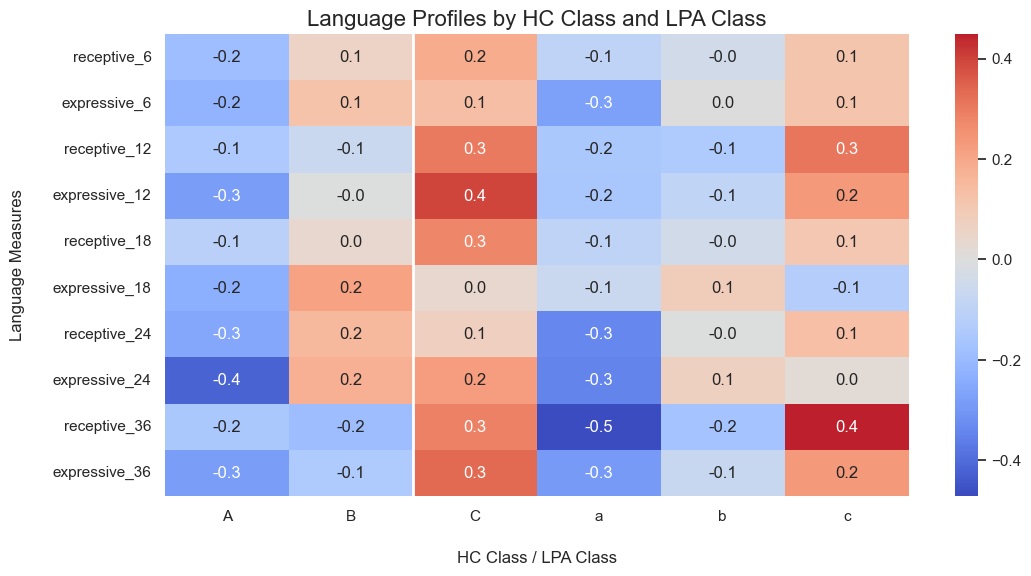

HC Class A (53) is average in language measures
HC Class B (56) is average in language measures
HC Class C (35) is average in language measures
HC Class a (0) is average in language measures
HC Class b (0) is average in language measures
HC Class c (0) is average in language measures


In [181]:

# Combine both profiles
profiles_normed = pd.concat([profiles_hc, profiles_mp], axis=0)

# Normalize the profiles
#profiles_normed = (combined_profiles.copy() - np.mean(combined_profiles, axis=0)) / np.std(combined_profiles, axis=0)

# Select relevant language profiles
lang_profiles = profiles_normed[language_vars]

# Plot the profiles
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(lang_profiles.T, cmap="coolwarm", center=0, ax=ax, annot=True, fmt=".1f")
plt.title("Language Profiles by HC Class and LPA Class", fontsize=16)
# Add a horizontal line to separate the two classes
plt.axvline(x=2, color="white", lw=2)
#plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=["HC High Avg", "HC Low Avg 1", "LPA High Avg", "LPA Low Avg"], rotation=25)

plt.xlabel("HC Class / LPA Class",labelpad=20)

plt.ylabel("Language Measures",labelpad=20)
plt.show()

# Characteristics in the language profiles
for class_n in lang_profiles.index:
    temp_df = lang_profiles.loc[lang_profiles.index == class_n]
    class_size = neurosubs_df.hc_class.value_counts().get(class_n, 0)
    good_lang_measures = temp_df[temp_df > 1].dropna(axis=1, how="all").columns.tolist()
    bad_lang_measures = temp_df[temp_df < -1].dropna(axis=1, how="all").columns.tolist()
    
    if len(good_lang_measures) > 0 and len(bad_lang_measures) > 0:
        print(f"HC Class {class_n} ({class_size}) is mixed. Characterized by good: {good_lang_measures} and bad: {bad_lang_measures}")
    elif len(good_lang_measures) > 0:
        print(f"HC Class {class_n} ({class_size}) is language proficient. Characterized by good: {good_lang_measures}")
    elif len(bad_lang_measures) > 0:
        print(f"HC Class {class_n} ({class_size}) is language impaired. Characterized by bad: {bad_lang_measures}")
    else: 
        print(f"HC Class {class_n} ({class_size}) is average in language measures")

In [182]:
expression_vars = ['expressive_6', 'expressive_12', 'expressive_24', 'expressive_36']
receptive_vars = ['receptive_6', 'receptive_12', 'receptive_24', 'receptive_36']
nonverbal_vars = ['nonverbal_iq_6', 'nonverbal_iq_12', 'nonverbal_iq_24', 'nonverbal_iq_36']


In [183]:
## Create wide long format for langauge measures

lang_wide=neurosubs_df.copy()

expressive_df= lang_wide[["hc_class", "lpa_class", "expressive_6", "expressive_12", "expressive_24", "expressive_36"]]
receptive_df= lang_wide[["hc_class", "lpa_class", "receptive_6", "receptive_12", "receptive_24", "receptive_36"]]
nonverbal_df= lang_wide[["hc_class", "lpa_class", "nonverbal_iq_6", "nonverbal_iq_12", "nonverbal_iq_24", "nonverbal_iq_36"]]
verbal_df= lang_wide[["hc_class", "lpa_class", "verbal_quotient_6", "verbal_quotient_12", "verbal_quotient_24", "verbal_quotient_36"]]




# Rename the timepoints
expressive_df = expressive_df.melt(id_vars=["hc_class", "lpa_class"], var_name="timepoint", value_name="score")
expressive_df["timepoint"] = expressive_df["timepoint"].str.replace("expressive_", "").astype(int)
expressive_df["Measure"] = "Expressive"

# Rename the timepoints
receptive_df = receptive_df.melt(id_vars=["hc_class", "lpa_class"], var_name="timepoint", value_name="score")
receptive_df["timepoint"] = receptive_df["timepoint"].str.replace("receptive_", "").astype(int)
receptive_df["Measure"] = "Receptive"

# Rename the timepoints
nonverbal_df = nonverbal_df.melt(id_vars=["hc_class", "lpa_class"], var_name= "timepoint", value_name="score")
nonverbal_df["timepoint"] = nonverbal_df["timepoint"].str.replace("nonverbal_iq_", "").astype(int)
nonverbal_df["Measure"] = "Nonverbal IQ"

# Rename the timepoints
verbal_df = verbal_df.melt(id_vars=["hc_class", "lpa_class"], var_name="timepoint", value_name="score")
verbal_df["timepoint"] = verbal_df["timepoint"].str.replace("verbal_quotient_", "").astype(int)
verbal_df["Measure"] = "Verbal IQ"





In [184]:
hc_order

['A', 'B', 'C']

Text(0, 0.5, 'Receptive Language Score')

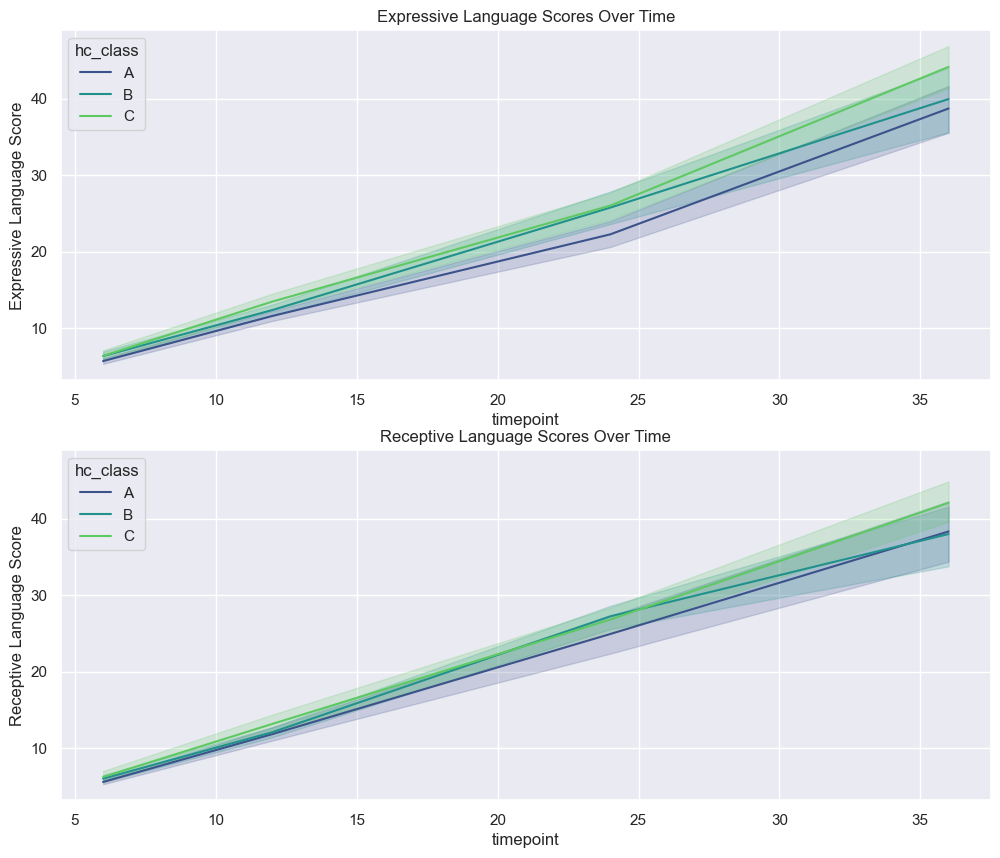

In [185]:
# Plot change in language measures over time

fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=False, sharey=True)

# Plot expressive language
sns.lineplot(data=expressive_df, x="timepoint", y="score", hue="hc_class", ax=ax[0], palette= "viridis", hue_order=hc_order)
ax[0].set_title("Expressive Language Scores Over Time")
ax[0].set_ylabel("Expressive Language Score")

# Plot receptive language
sns.lineplot(data=receptive_df, x="timepoint", y="score", hue="hc_class", ax=ax[1], palette = "viridis", hue_order=hc_order)
ax[1].set_title("Receptive Language Scores Over Time")
ax[1].set_ylabel("Receptive Language Score")

Text(0.5, 1.0, 'Verbal IQ Scores Over Time')

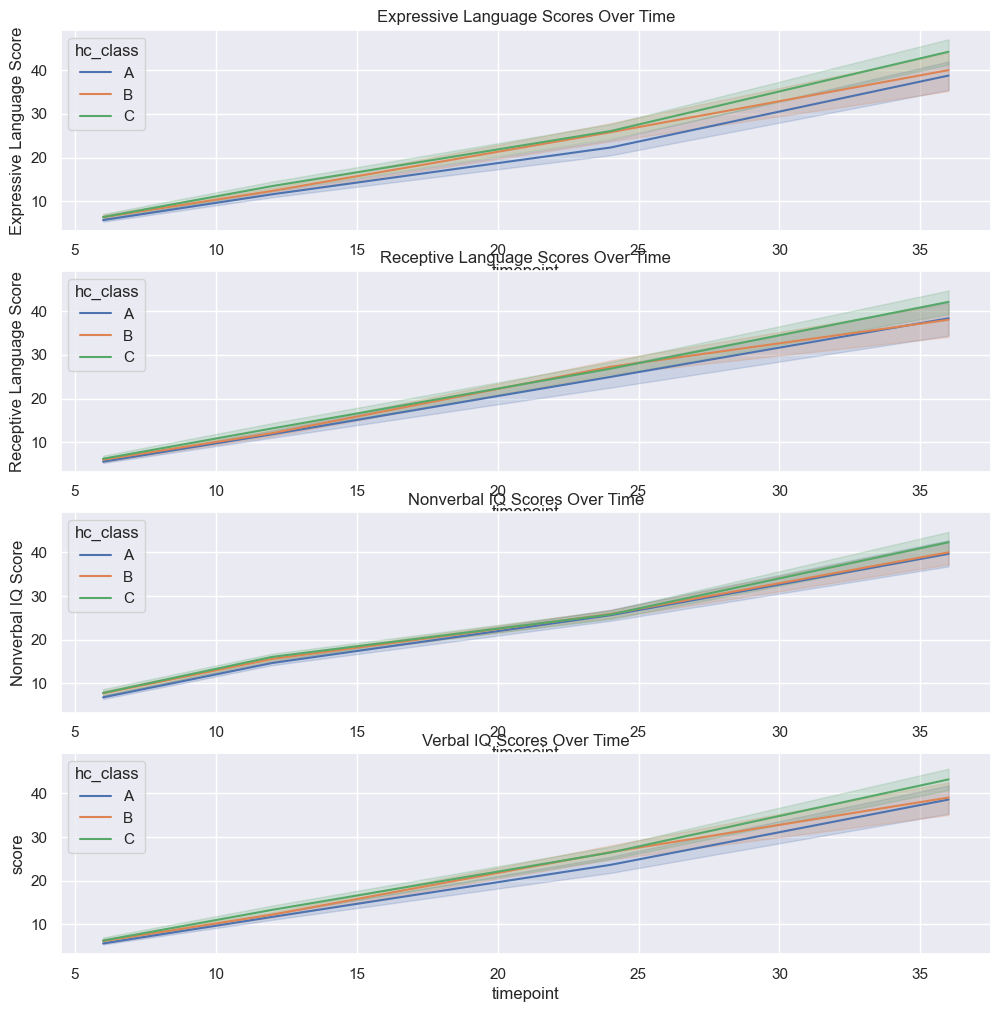

In [186]:
# Plot change in language measures over time

fig, ax = plt.subplots(4, 1, figsize=(12, 12), sharex=False, sharey=True)

# Plot expressive language
sns.lineplot(data=expressive_df, x="timepoint", y="score", hue="hc_class", ax=ax[0])
ax[0].set_title("Expressive Language Scores Over Time")
ax[0].set_ylabel("Expressive Language Score")

# Plot receptive language
sns.lineplot(data=receptive_df, x="timepoint", y="score", hue="hc_class", ax=ax[1])
ax[1].set_title("Receptive Language Scores Over Time")
ax[1].set_ylabel("Receptive Language Score")

# Plot nonverbal IQ
sns.lineplot(data=nonverbal_df, x="timepoint", y="score", hue="hc_class", ax=ax[2])
ax[2].set_title("Nonverbal IQ Scores Over Time")
ax[2].set_ylabel("Nonverbal IQ Score")

# Plot verbal IQ
sns.lineplot(data=verbal_df, x="timepoint", y="score", hue="hc_class", ax=ax[3])
ax[3].set_title("Verbal IQ Scores Over Time")


Text(0.5, 1.0, 'Verbal IQ Scores Over Time')

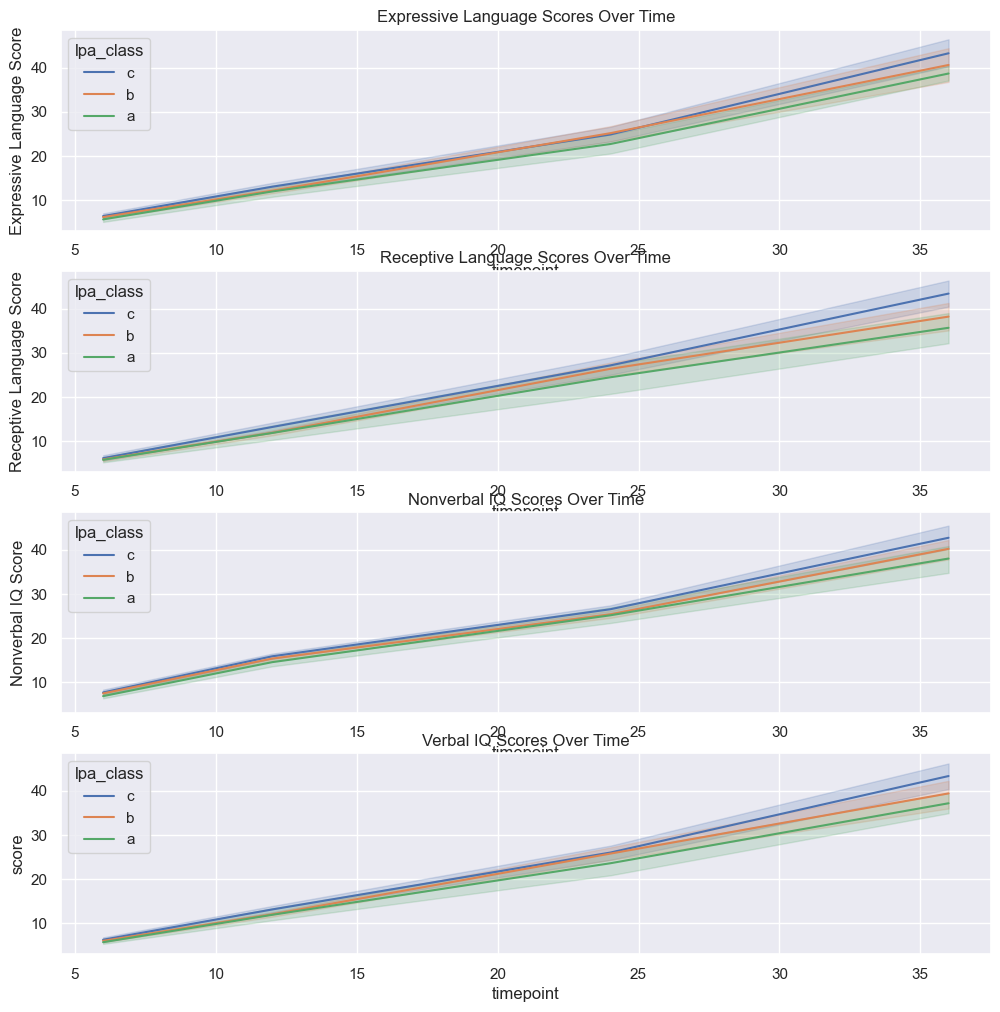

In [187]:
# Plot change in language measures over time

fig, ax = plt.subplots(4, 1, figsize=(12, 12), sharex=False, sharey=True)

# Plot expressive language
sns.lineplot(data=expressive_df, x="timepoint", y="score", hue="lpa_class", ax=ax[0])
ax[0].set_title("Expressive Language Scores Over Time")
ax[0].set_ylabel("Expressive Language Score")

# Plot receptive language
sns.lineplot(data=receptive_df, x="timepoint", y="score", hue="lpa_class", ax=ax[1])
ax[1].set_title("Receptive Language Scores Over Time")
ax[1].set_ylabel("Receptive Language Score")

# Plot nonverbal IQ
sns.lineplot(data=nonverbal_df, x="timepoint", y="score", hue="lpa_class", ax=ax[2])
ax[2].set_title("Nonverbal IQ Scores Over Time")
ax[2].set_ylabel("Nonverbal IQ Score")


# Plot verbal IQ
sns.lineplot(data=verbal_df, x="timepoint", y="score", hue="lpa_class", ax=ax[3])
ax[3].set_title("Verbal IQ Scores Over Time")


In [188]:
lang_wide

subject hc_class  gamma_lat_6  speech_con_6_left  auditory_con_6  \
0          2        A          NaN          -1.225266       -1.598480   
1          3        B     0.040530          -1.659758       -1.829292   
2          5        B    -0.016544          -1.464546       -1.823852   
3          6        B    -0.164802          -1.757113       -1.429544   
4          8        B    -0.108383          -1.432471       -1.765373   
..       ...      ...          ...                ...             ...   
139      748        C    -0.062543          -1.186238       -1.417463   
140      915        B     0.042839          -1.522898       -1.788839   
141      933        A    -0.097921          -1.526620       -1.071994   
142      937        B          NaN          -1.740539       -1.762447   
143      107        A          NaN          -1.017866       -1.448523   

     lang_comp_con_6  front_gamma_6 lpa_class  prob_class_1  prob_class_2  \
0          -1.161137     -21.420116         c         0.003         0.000   
1          -1.516043     -21.072590         b         0.000         0.997   
2          -1.619339     -22.141673         b         0.000         0.977   
3          -1.602488     -21.630370         b         0.008         0.992   
4          -1.587519     -21.588120         b         0.000         0.959   
..               ...            ...       ...           ...           ...   
139        -1.516925     -20.735650         c         0.112         0.029   
140        -1.603515     -20.919022         b         0.000         0.983   
141        -1.285763     -21.463387         a         0.999         0.001   
142        -1.702147     -21.106285         b         0.000         1.000   
143        -1.552049     -21.268801         c         0.003         0.001   

     ...  exp_rec_36        site  group_type  outcome  sex  verbal_quotient_6  \
0    ...         NaN  washington         ELA   no-asd    M                5.0   
1    ...         NaN  washington         ELA   no-asd    M                7.5   
2    ...         NaN  washington         TLA      NaN    M                5.5   
3    ...         NaN  washington         ELA   no-asd    M                5.0   
4    ...         NaN  washington         ELA      asd    M                5.5   
..   ...         ...         ...         ...      ...  ...                ...   
139  ...         3.0      london         TLA   no-asd    F                5.5   
140  ...         NaN  washington         TLA   no-asd    M                5.0   
141  ...         NaN  washington         TLA      asd    M                6.5   
142  ...         NaN  washington         TLA   no-asd    M                6.5   
143  ...         NaN  washington         TLA   no-asd    M                7.5   

     verbal_quotient_12  verbal_quotient_18  verbal_quotient_24  \
0                  13.0                18.0                24.5   
1                  14.0                19.0                24.0   
2                   NaN                 NaN                 NaN   
3                  12.5                20.5                27.5   
4                   9.5                20.5                26.0   
..                  ...                 ...                 ...   
139                10.0                 NaN                29.0   
140                14.0                 NaN                26.0   
141                11.5                24.0                 NaN   
142                 9.0                14.0                 NaN   
143                 NaN                 NaN                 NaN   

     verbal_quotient_36  
0                   NaN  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN  
..                  ...  
139                58.5  
140                 NaN  
141                 NaN  
142                 NaN  
143                 NaN  

[144 rows x 38 columns]

In [189]:
# Covert langwiide to long format

# Rename the timepoints
lang_long = lang_wide.melt(id_vars=["hc_class", "lpa_class","subject","sex","site","group_type","outcome"], var_name="Measure", value_name="score")
lang_long

hc_class lpa_class  subject sex        site group_type outcome  \
0           A         c        2   M  washington        ELA  no-asd   
1           B         b        3   M  washington        ELA  no-asd   
2           B         b        5   M  washington        TLA     NaN   
3           B         b        6   M  washington        ELA  no-asd   
4           B         b        8   M  washington        ELA     asd   
...       ...       ...      ...  ..         ...        ...     ...   
4459        C         c      748   F      london        TLA  no-asd   
4460        B         b      915   M  washington        TLA  no-asd   
4461        A         a      933   M  washington        TLA     asd   
4462        B         b      937   M  washington        TLA  no-asd   
4463        A         c      107   M  washington        TLA  no-asd   

                 Measure      score  
0            gamma_lat_6        NaN  
1            gamma_lat_6   0.040530  
2            gamma_lat_6  -0.016544  
3            gamma_lat_6  -0.164802  
4            gamma_lat_6  -0.108383  
...                  ...        ...  
4459  verbal_quotient_36  58.500000  
4460  verbal_quotient_36        NaN  
4461  verbal_quotient_36        NaN  
4462  verbal_quotient_36        NaN  
4463  verbal_quotient_36        NaN  

[4464 rows x 9 columns]

In [190]:
lang_long.Measure.unique()

array(['gamma_lat_6', 'speech_con_6_left', 'auditory_con_6',
       'lang_comp_con_6', 'front_gamma_6', 'prob_class_1', 'prob_class_2',
       'prob_class_3', 'receptive_6', 'expressive_6', 'receptive_12',
       'expressive_12', 'receptive_18', 'expressive_18', 'receptive_24',
       'expressive_24', 'receptive_36', 'expressive_36', 'nonverbal_iq_6',
       'nonverbal_iq_12', 'nonverbal_iq_24', 'nonverbal_iq_36',
       'exp_rec_6', 'exp_rec_12', 'exp_rec_24', 'exp_rec_36',
       'verbal_quotient_6', 'verbal_quotient_12', 'verbal_quotient_18',
       'verbal_quotient_24', 'verbal_quotient_36'], dtype=object)

In [191]:
lang_long["timepoint"] = lang_long["Measure"].str.extract(r'(\d+)').astype(int)
lang_long["Measure"] = lang_long["Measure"].str.replace(r'_\d+', '')

C:\Users\gabot\AppData\Local\Temp\ipykernel_6044\2319051442.py:2: FutureWarning:

The default value of regex will change from True to False in a future version.



In [192]:
expressive_df_long= lang_long[lang_long["Measure"].str.contains("expressive")]
receptive_df_long= lang_long[lang_long["Measure"].str.contains("receptive")]
nonverbal_df_long= lang_long[lang_long["Measure"].str.contains("nonverbal")]
verbal_df_long= lang_long[lang_long["Measure"].str.contains("verbal")]

expressive_df_long['subject'] = expressive_df_long['subject'].astype('category')
receptive_df_long['subject'] = receptive_df_long['subject'].astype('category')
nonverbal_df_long['subject'] = nonverbal_df_long['subject'].astype('category')
verbal_df_long['subject'] = verbal_df_long['subject'].astype('category')


C:\Users\gabot\AppData\Local\Temp\ipykernel_6044\4180967025.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\gabot\AppData\Local\Temp\ipykernel_6044\4180967025.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\gabot\AppData\Local\Temp\ipykernel_6044\4180967025.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [193]:
nonverbal_df_long["iq"]= nonverbal_df_long["score"]

C:\Users\gabot\AppData\Local\Temp\ipykernel_6044\2566110763.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [194]:
nonverbal_df_merge= nonverbal_df_long[["hc_class", "lpa_class", "subject","sex","site","group_type","outcome","timepoint","iq"]]

In [195]:
expressive_df_long=expressive_df_long.merge(nonverbal_df_merge, on=["hc_class", "lpa_class", "subject","sex","site","group_type","outcome","timepoint"], how="left")
receptive_df_long=receptive_df_long.merge(nonverbal_df_merge, on=["hc_class", "lpa_class", "subject","sex","site","group_type","outcome","timepoint"], how="left")
verbal_df_long=verbal_df_long.merge(nonverbal_df_merge, on=["hc_class", "lpa_class", "subject","sex","site","group_type","outcome","timepoint"], how="left")


In [196]:
expressive_df_long

hc_class lpa_class subject sex        site group_type outcome     Measure  \
0          A         c       2   M  washington        ELA  no-asd  expressive   
1          B         b       3   M  washington        ELA  no-asd  expressive   
2          B         b       5   M  washington        TLA     NaN  expressive   
3          B         b       6   M  washington        ELA  no-asd  expressive   
4          B         b       8   M  washington        ELA     asd  expressive   
..       ...       ...     ...  ..         ...        ...     ...         ...   
715        C         c     748   F      london        TLA  no-asd  expressive   
716        B         b     915   M  washington        TLA  no-asd  expressive   
717        A         a     933   M  washington        TLA     asd  expressive   
718        B         b     937   M  washington        TLA  no-asd  expressive   
719        A         c     107   M  washington        TLA  no-asd  expressive   

     score  timepoint    iq  
0      5.0          6   7.0  
1      7.0          6   6.5  
2      5.0          6   5.0  
3      4.0          6   6.0  
4      5.0          6   6.0  
..     ...        ...   ...  
715   60.0         36  45.5  
716    NaN         36   NaN  
717    NaN         36   NaN  
718    NaN         36   NaN  
719    NaN         36   NaN  

[720 rows x 11 columns]

In [197]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.families import Gaussian
from statsmodels.genmod.cov_struct import Exchangeable

# Define the model formula (Group, Time, Covariates, Interaction term)
formula = "score ~ lpa_class * timepoint + sex + group_type + site + iq"

# Define the GEE model with an exchangeable correlation structure
model = smf.gee(formula, 
                groups=expressive_df_long['subject'],  # Longitudinal data, repeated measures per subject
                data=expressive_df_long, 
                family=Gaussian(),  # You could change this if the distribution isn't Gaussian
                cov_struct=Exchangeable())  # Assumes constant correlation between timepoints

# Fit the model
result = model.fit()

# Output the results
print(result.summary())


                               GEE Regression Results                              
Dep. Variable:                       score   No. Observations:                  438
Model:                                 GEE   No. clusters:                      144
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   4
Family:                           Gaussian   Mean cluster size:                 3.0
Dependence structure:         Exchangeable   Num. iterations:                     6
Date:                     Wed, 16 Apr 2025   Scale:                          16.271
Covariance type:                    robust   Time:                         18:12:04
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -2.0462      0.566     -3.613 

In [198]:
# Define the model formula (Group, Time, Covariates, Interaction term)
formula = "score ~ hc_class * timepoint + sex + group_type + site + iq"

# Define the GEE model with an exchangeable correlation structure
model = smf.gee(formula, 
                groups=expressive_df_long['subject'],  # Longitudinal data, repeated measures per subject
                data=expressive_df_long, 
                family=Gaussian(),  # You could change this if the distribution isn't Gaussian
                cov_struct=Exchangeable())  # Assumes constant correlation between timepoints

# Fit the model
result = model.fit()

# Output the results
print(result.summary())


                               GEE Regression Results                              
Dep. Variable:                       score   No. Observations:                  438
Model:                                 GEE   No. clusters:                      144
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   4
Family:                           Gaussian   Mean cluster size:                 3.0
Dependence structure:         Exchangeable   Num. iterations:                     6
Date:                     Wed, 16 Apr 2025   Scale:                          15.521
Covariance type:                    robust   Time:                         18:12:04
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.7639      0.589     -2.995    

In [199]:
formula = "score ~ lpa_class * timepoint + sex + group_type + site + iq"

# Define the GEE model with an exchangeable correlation structure
model = smf.gee(formula, 
                groups=receptive_df_long['subject'],  # Longitudinal data, repeated measures per subject
                data=receptive_df_long, 
                family=Gaussian(),  # You could change this if the distribution isn't Gaussian
                cov_struct=Exchangeable())  # Assumes constant correlation between timepoints

# Fit the model
result = model.fit()

# Output the results
print(result.summary())


                               GEE Regression Results                              
Dep. Variable:                       score   No. Observations:                  438
Model:                                 GEE   No. clusters:                      144
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   4
Family:                           Gaussian   Mean cluster size:                 3.0
Dependence structure:         Exchangeable   Num. iterations:                     9
Date:                     Wed, 16 Apr 2025   Scale:                          13.965
Covariance type:                    robust   Time:                         18:12:04
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.1802      0.680     -1.737 

In [200]:
formula = "score ~ hc_class * timepoint + sex + group_type + site + iq"

# Define the GEE model with an exchangeable correlation structure
model = smf.gee(formula, 
                groups=receptive_df_long['subject'],  # Longitudinal data, repeated measures per subject
                data=receptive_df_long, 
                family=Gaussian(),  # You could change this if the distribution isn't Gaussian
                cov_struct=Exchangeable())  # Assumes constant correlation between timepoints

# Fit the model
result = model.fit()

# Output the results
print(result.summary())


                               GEE Regression Results                              
Dep. Variable:                       score   No. Observations:                  438
Model:                                 GEE   No. clusters:                      144
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   4
Family:                           Gaussian   Mean cluster size:                 3.0
Dependence structure:         Exchangeable   Num. iterations:                     9
Date:                     Wed, 16 Apr 2025   Scale:                          14.256
Covariance type:                    robust   Time:                         18:12:04
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.8436      0.643     -2.866    

In [201]:
expressive_df_long.timepoint.unique()

array([ 6, 12, 18, 24, 36])

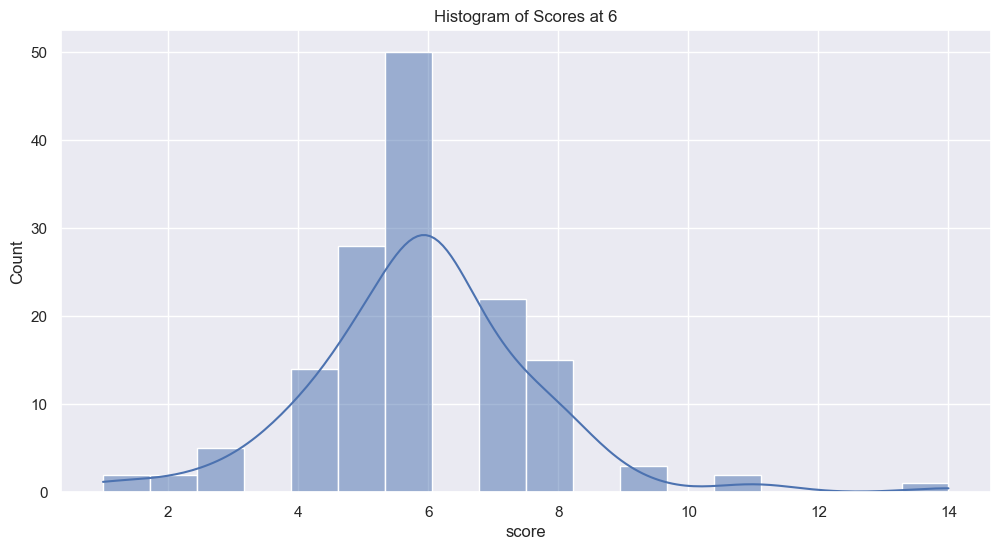

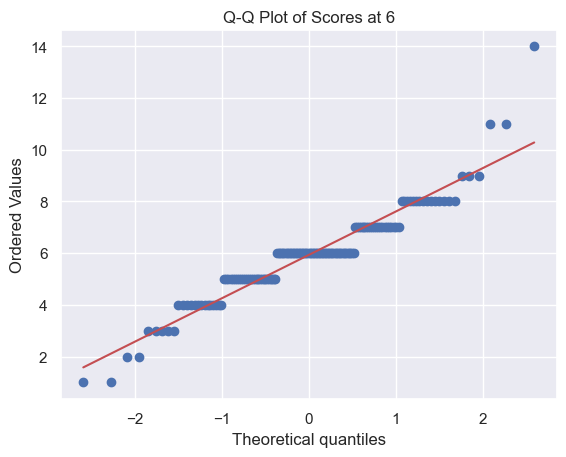

Shapiro-Wilk Test at 6: p-value = 3.0206007295419113e-07
Scores at 6 are not normally distributed


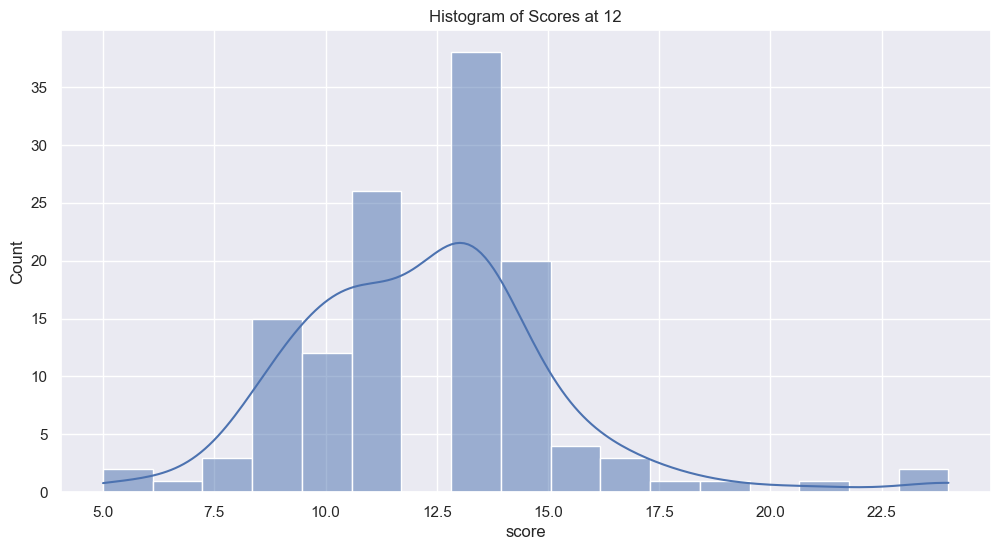

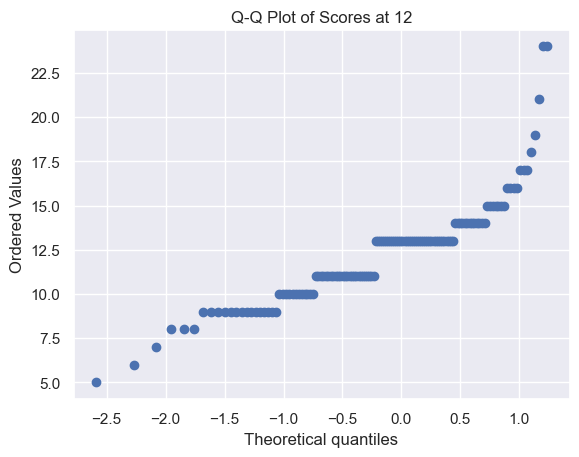

Shapiro-Wilk Test at 12: p-value = 1.0
Scores at 12 appear to be normally distributed


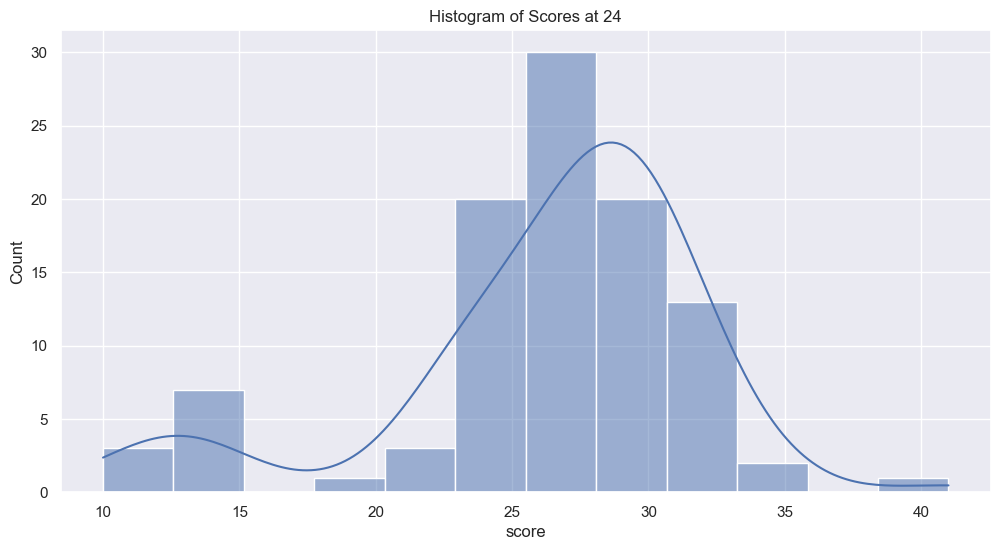

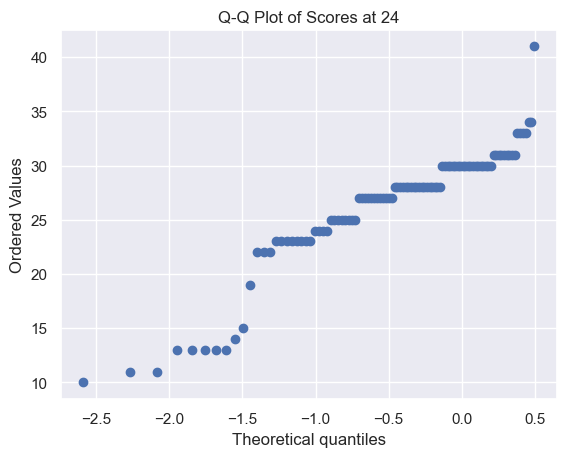

Shapiro-Wilk Test at 24: p-value = 1.0
Scores at 24 appear to be normally distributed


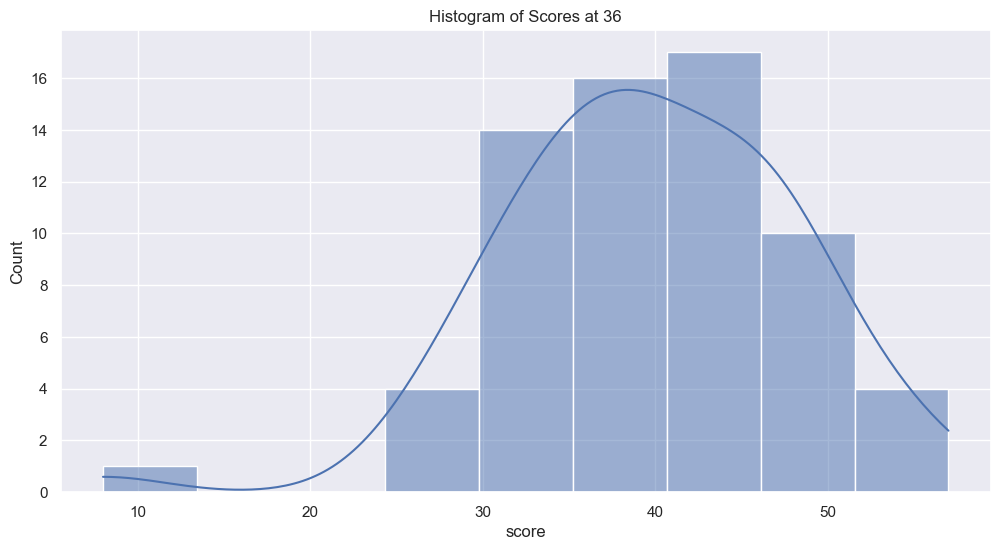

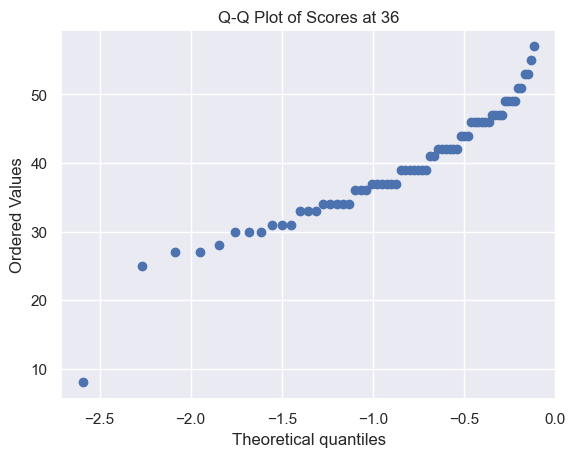

Shapiro-Wilk Test at 36: p-value = 1.0
Scores at 36 appear to be normally distributed


In [202]:
# Assuming your data is in long format with 'timepoint' and 'score' columns
# Create a list of timepoints
timepoints = [6,12, 24, 36]

for time in timepoints:
    scores_at_time = receptive_df_long[receptive_df_long['timepoint'] == time]['score']
    
    # Visual checks
    plt.figure(figsize=(12, 6))
    
    # Histogram
    sns.histplot(scores_at_time, kde=True)
    plt.title(f"Histogram of Scores at {time}")
    plt.show()
    
    # Q-Q plot
    stats.probplot(scores_at_time, dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Scores at {time}")
    plt.show()
    
    # Shapiro-Wilk Test for normality
    stat, p_value = stats.shapiro(scores_at_time)
    print(f"Shapiro-Wilk Test at {time}: p-value = {p_value}")
    
    # If p-value < 0.05, reject normality hypothesis
    if p_value < 0.05:
        print(f"Scores at {time} are not normally distributed")
    else:
        print(f"Scores at {time} appear to be normally distributed")


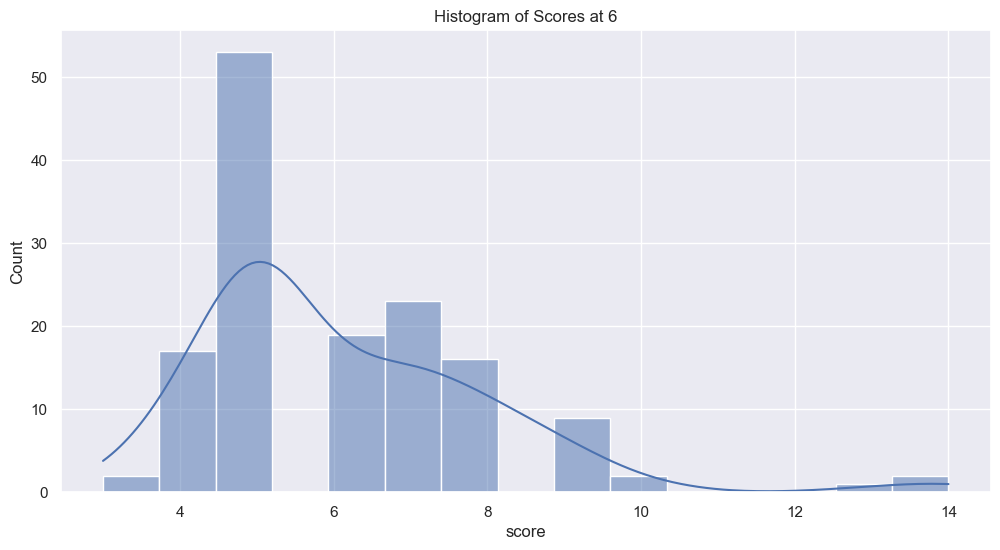

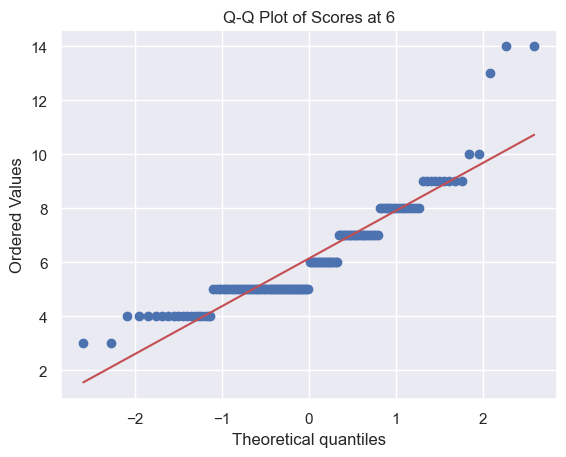

Shapiro-Wilk Test at 6: p-value = 1.7695235554615607e-10
Scores at 6 are not normally distributed


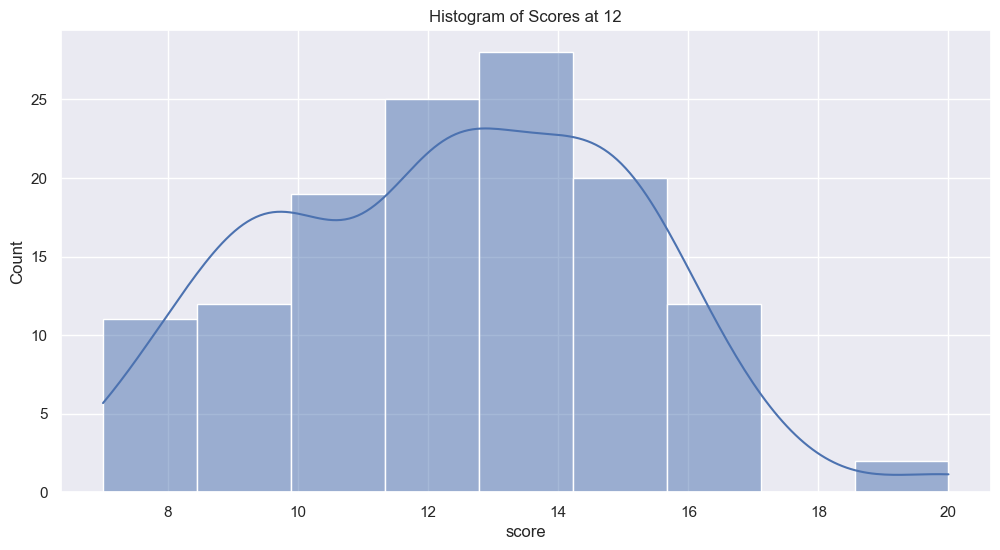

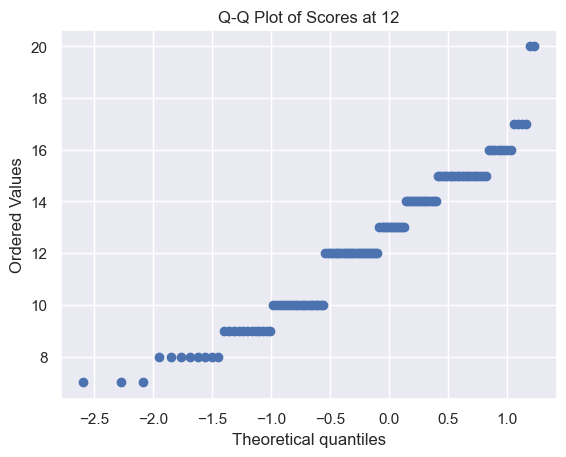

Shapiro-Wilk Test at 12: p-value = 1.0
Scores at 12 appear to be normally distributed


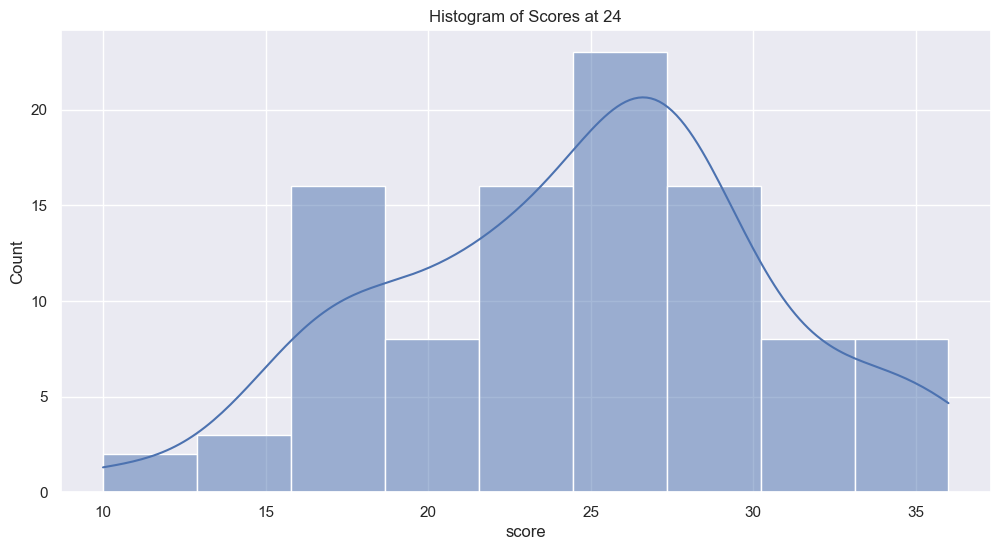

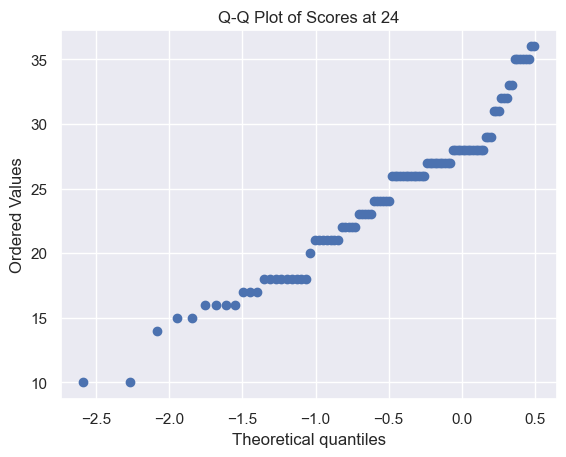

Shapiro-Wilk Test at 24: p-value = 1.0
Scores at 24 appear to be normally distributed


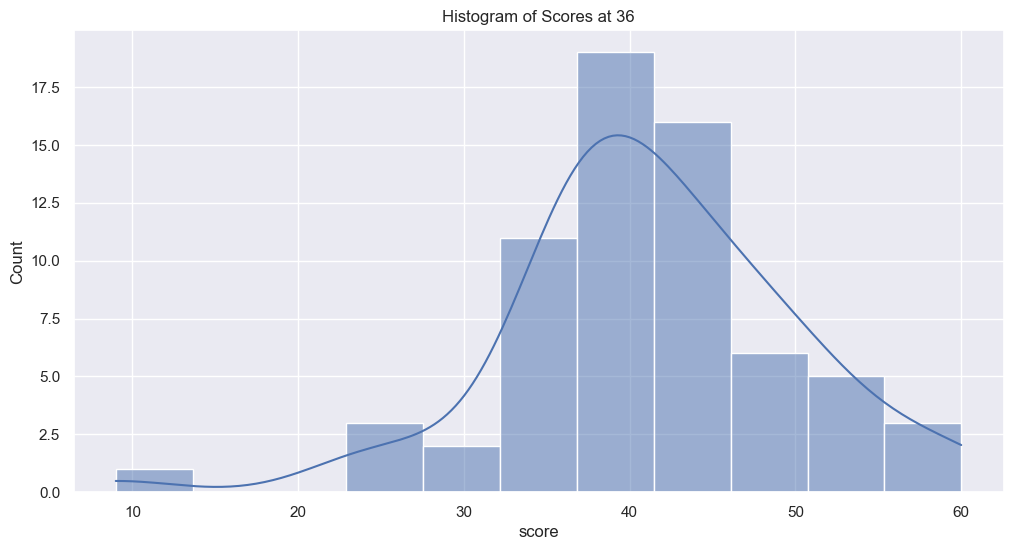

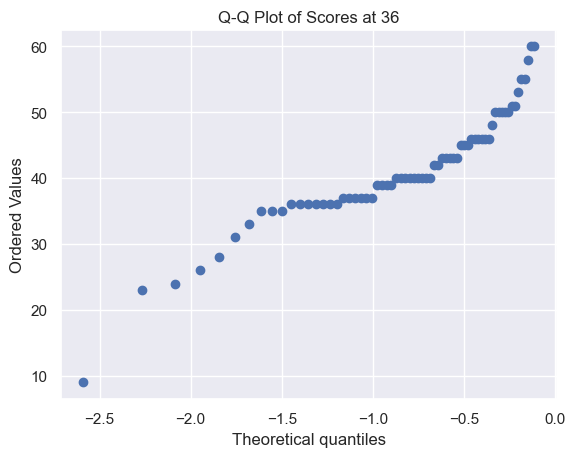

Shapiro-Wilk Test at 36: p-value = 1.0
Scores at 36 appear to be normally distributed


In [203]:
# Assuming your data is in long format with 'timepoint' and 'score' columns
# Create a list of timepoints
timepoints = [6,12, 24, 36]

for time in timepoints:
    scores_at_time = expressive_df_long[expressive_df_long['timepoint'] == time]['score']
    
    # Visual checks
    plt.figure(figsize=(12, 6))
    
    # Histogram
    sns.histplot(scores_at_time, kde=True)
    plt.title(f"Histogram of Scores at {time}")
    plt.show()
    
    # Q-Q plot
    stats.probplot(scores_at_time, dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Scores at {time}")
    plt.show()
    
    # Shapiro-Wilk Test for normality
    stat, p_value = stats.shapiro(scores_at_time)
    print(f"Shapiro-Wilk Test at {time}: p-value = {p_value}")
    
    # If p-value < 0.05, reject normality hypothesis
    if p_value < 0.05:
        print(f"Scores at {time} are not normally distributed")
    else:
        print(f"Scores at {time} appear to be normally distributed")


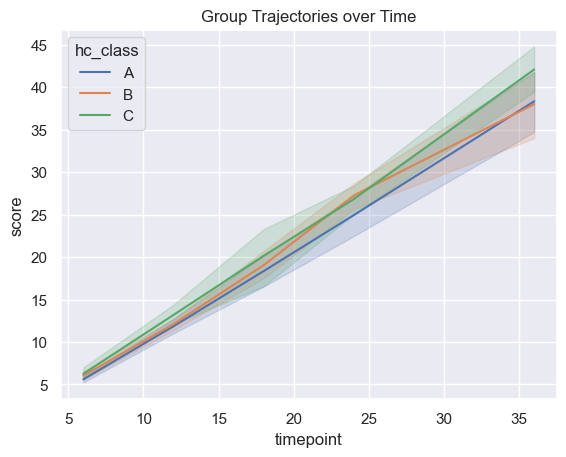

In [204]:
# Plotting the group trajectories over time
sns.lineplot(data=receptive_df_long, x='timepoint', y='score', hue='hc_class')
plt.title("Group Trajectories over Time")
plt.show()

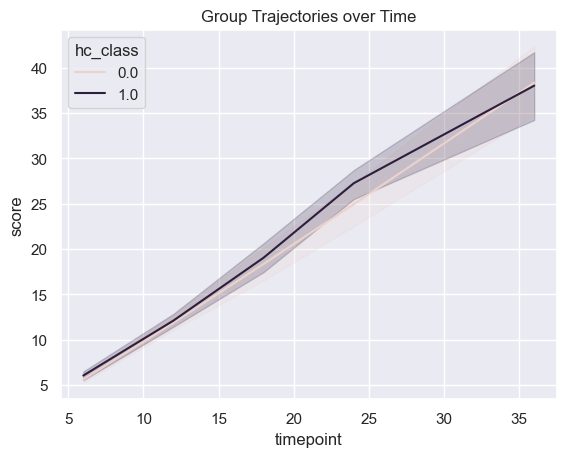

In [205]:
# Plotting the group trajectories over time
sns.lineplot(data=df_imputed, x='timepoint', y='score', hue='hc_class')
plt.title("Group Trajectories over Time")
plt.show()

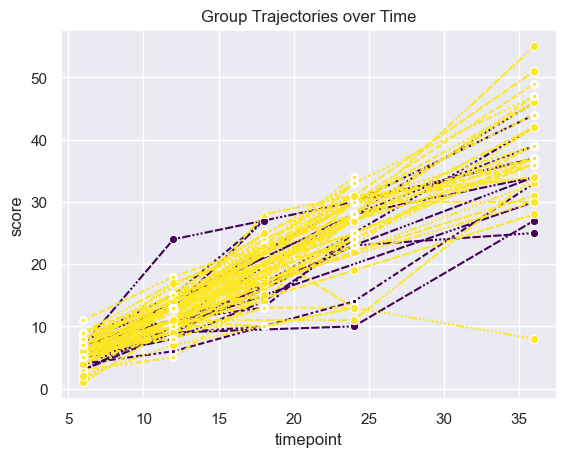

In [206]:
# Plotting the individual trajectories over time for each subject
sns.lineplot(data=df_imputed, x='timepoint', y='score', hue='lpa_class', palette='viridis', style='subject', markers=True, legend=False)
plt.title("Group Trajectories over Time")
plt.show()

Text(0, 0.5, 'Expressive Language AE Score')

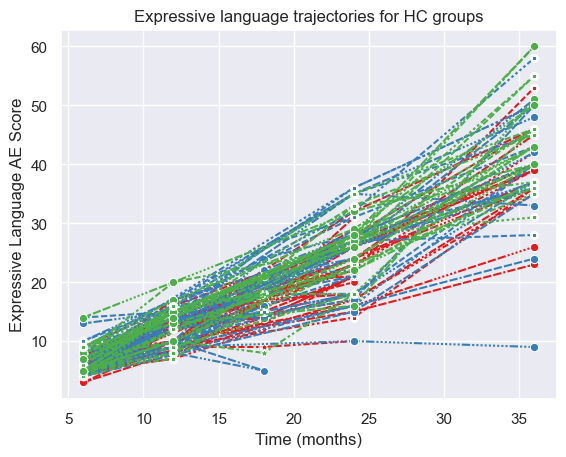

In [207]:
# Plotting the individual trajectories over time for each subject
sns.lineplot(data=expressive_df_long, x='timepoint', y='score', hue='hc_class', palette='Set1', style='subject', markers=True, legend=False)

plt.title("Expressive language trajectories for HC groups")
# Add x axis label
plt.xlabel("Time (months)")
# Add y axis label
plt.ylabel("Expressive Language AE Score")


Text(0, 0.5, 'Receptive Language AE Score')

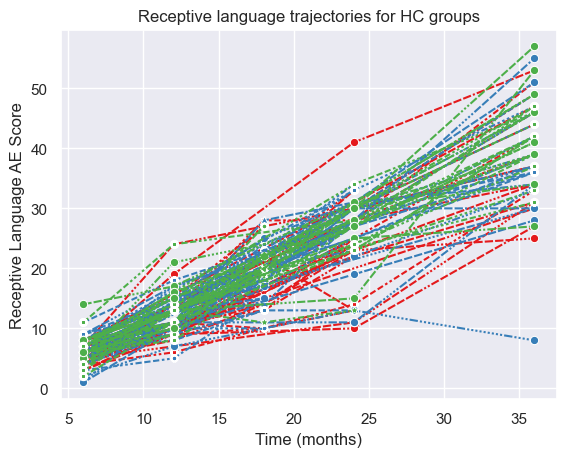

In [208]:
# Plotting the individual trajectories over time for each subject
sns.lineplot(data=receptive_df_long, x='timepoint', y='score', hue='hc_class', palette='Set1', style='subject', markers=True, legend=False)

plt.title("Receptive language trajectories for HC groups")
# Add x axis label
plt.xlabel("Time (months)")
# Add y axis label
plt.ylabel("Receptive Language AE Score")


Text(0, 0.5, 'Expressive Language AE Score')

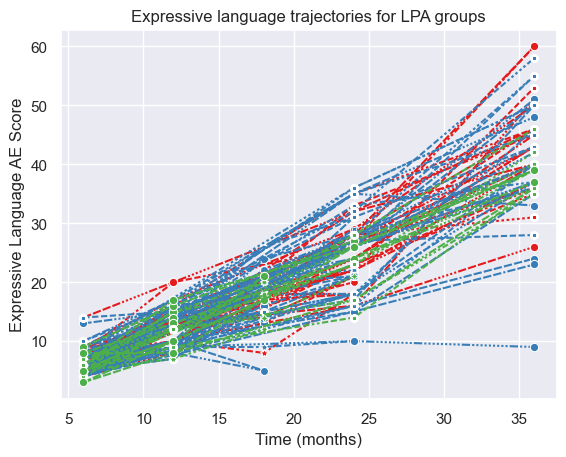

In [209]:
# Plotting the individual trajectories over time for each subject
sns.lineplot(data=expressive_df_long, x='timepoint', y='score', hue='lpa_class', palette='Set1', style='subject', markers=True, legend=False)

plt.title("Expressive language trajectories for LPA groups")
# Add x axis label
plt.xlabel("Time (months)")
# Add y axis label
plt.ylabel("Expressive Language AE Score")


Text(0, 0.5, 'Receptive Language AE Score')

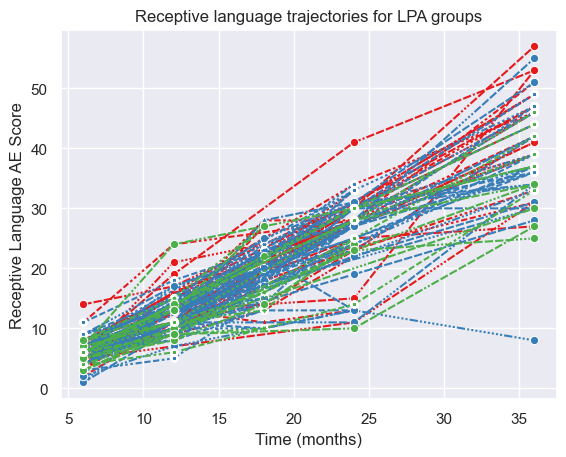

In [210]:
# Plotting the individual trajectories over time for each subject
sns.lineplot(data=receptive_df_long, x='timepoint', y='score', hue='lpa_class', palette='Set1', style='subject', markers=True, legend=False)

plt.title("Receptive language trajectories for LPA groups")
# Add x axis label
plt.xlabel("Time (months)")
# Add y axis label
plt.ylabel("Receptive Language AE Score")

In [211]:
expressive_df_long

hc_class lpa_class subject sex        site group_type outcome     Measure  \
0          A         c       2   M  washington        ELA  no-asd  expressive   
1          B         b       3   M  washington        ELA  no-asd  expressive   
2          B         b       5   M  washington        TLA     NaN  expressive   
3          B         b       6   M  washington        ELA  no-asd  expressive   
4          B         b       8   M  washington        ELA     asd  expressive   
..       ...       ...     ...  ..         ...        ...     ...         ...   
715        C         c     748   F      london        TLA  no-asd  expressive   
716        B         b     915   M  washington        TLA  no-asd  expressive   
717        A         a     933   M  washington        TLA     asd  expressive   
718        B         b     937   M  washington        TLA  no-asd  expressive   
719        A         c     107   M  washington        TLA  no-asd  expressive   

     score  timepoint    iq  
0      5.0          6   7.0  
1      7.0          6   6.5  
2      5.0          6   5.0  
3      4.0          6   6.0  
4      5.0          6   6.0  
..     ...        ...   ...  
715   60.0         36  45.5  
716    NaN         36   NaN  
717    NaN         36   NaN  
718    NaN         36   NaN  
719    NaN         36   NaN  

[720 rows x 11 columns]

In [212]:
lang_wide

subject hc_class  gamma_lat_6  speech_con_6_left  auditory_con_6  \
0          2        A          NaN          -1.225266       -1.598480   
1          3        B     0.040530          -1.659758       -1.829292   
2          5        B    -0.016544          -1.464546       -1.823852   
3          6        B    -0.164802          -1.757113       -1.429544   
4          8        B    -0.108383          -1.432471       -1.765373   
..       ...      ...          ...                ...             ...   
139      748        C    -0.062543          -1.186238       -1.417463   
140      915        B     0.042839          -1.522898       -1.788839   
141      933        A    -0.097921          -1.526620       -1.071994   
142      937        B          NaN          -1.740539       -1.762447   
143      107        A          NaN          -1.017866       -1.448523   

     lang_comp_con_6  front_gamma_6 lpa_class  prob_class_1  prob_class_2  \
0          -1.161137     -21.420116         c         0.003         0.000   
1          -1.516043     -21.072590         b         0.000         0.997   
2          -1.619339     -22.141673         b         0.000         0.977   
3          -1.602488     -21.630370         b         0.008         0.992   
4          -1.587519     -21.588120         b         0.000         0.959   
..               ...            ...       ...           ...           ...   
139        -1.516925     -20.735650         c         0.112         0.029   
140        -1.603515     -20.919022         b         0.000         0.983   
141        -1.285763     -21.463387         a         0.999         0.001   
142        -1.702147     -21.106285         b         0.000         1.000   
143        -1.552049     -21.268801         c         0.003         0.001   

     ...  exp_rec_36        site  group_type  outcome  sex  verbal_quotient_6  \
0    ...         NaN  washington         ELA   no-asd    M                5.0   
1    ...         NaN  washington         ELA   no-asd    M                7.5   
2    ...         NaN  washington         TLA      NaN    M                5.5   
3    ...         NaN  washington         ELA   no-asd    M                5.0   
4    ...         NaN  washington         ELA      asd    M                5.5   
..   ...         ...         ...         ...      ...  ...                ...   
139  ...         3.0      london         TLA   no-asd    F                5.5   
140  ...         NaN  washington         TLA   no-asd    M                5.0   
141  ...         NaN  washington         TLA      asd    M                6.5   
142  ...         NaN  washington         TLA   no-asd    M                6.5   
143  ...         NaN  washington         TLA   no-asd    M                7.5   

     verbal_quotient_12  verbal_quotient_18  verbal_quotient_24  \
0                  13.0                18.0                24.5   
1                  14.0                19.0                24.0   
2                   NaN                 NaN                 NaN   
3                  12.5                20.5                27.5   
4                   9.5                20.5                26.0   
..                  ...                 ...                 ...   
139                10.0                 NaN                29.0   
140                14.0                 NaN                26.0   
141                11.5                24.0                 NaN   
142                 9.0                14.0                 NaN   
143                 NaN                 NaN                 NaN   

     verbal_quotient_36  
0                   NaN  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN  
..                  ...  
139                58.5  
140                 NaN  
141                 NaN  
142                 NaN  
143                 NaN  

[144 rows x 38 columns]

In [213]:
def setup_growth_curve_model(df, subject_id='subject_id', time_col='time', score_col='score'):
    """
    Prepare and fit a latent growth curve model for longitudinal data
    
    Parameters:
    df: DataFrame in long format
    subject_id: name of the subject ID column
    time_col: name of the time column
    score_col: name of the score column
    """
    # 1. Data Diagnostics
    print("\nData Diagnostics:")
    print(f"Number of unique subjects: {df[subject_id].nunique()}")
    print(f"Number of total observations: {len(df)}")
    
    # Check measurements per subject
    measures_per_subject = df.groupby(subject_id).size()
    print("\nMeasurements per subject:")
    print(f"Mean: {measures_per_subject.mean():.2f}")
    print(f"Min: {measures_per_subject.min()}")
    print(f"Max: {measures_per_subject.max()}")
    
    # Visualize missing patterns
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=time_col)
    plt.title("Number of Measurements at Each Time Point")
    plt.show()
    
    # 2. Center time variable
    # Center at first timepoint (6 months)
    df['time_centered'] = df[time_col] - 6
    
    # 3. Define the growth curve model
    model_desc = """
    # Latent Growth Curve Model
    # Intercept (i) and Slope (s) as latent factors
    i =~ 1*score  # Intercept has constant loading of 1
    s =~ time_centered*score  # Slope uses centered time values
    
    # Regressions predicting individual differences in growth parameters
    i ~ sex + hc_class + group_type + site + iq
    s ~ sex + hc_class + group_type + iq
    
    # Random effects - allow individual differences in growth parameters
    i ~~ i  # Intercept variance
    s ~~ s  # Slope variance
    i ~~ s  # Intercept-slope covariance
    """
    
 # 4. Fit model with different attempts
    def try_fit_model(model, data, attempt=1):
        try:
            if attempt == 1:
                return model.fit(data, robust=True)
            elif attempt == 2:
                return model.fit(data, robust=True, solver='BFGS')
            else:
                return model.fit(data, robust=True, solver='BFGS', 
                               optimizer_options={'maxiter': 2000})
        except Exception as e:
            if attempt < 3:
                print(f"Attempt {attempt} failed, trying different parameters...")
                return try_fit_model(model, data, attempt + 1)
            else:
                raise e

    try:
        model = Model(model_desc)
        results = try_fit_model(model, df)
        
        # 5. Print results
        print("\nModel Results:")
        print(model.inspect())
        
        # 6. Calculate and print fit indices
        fit_indices = model.inspect(mode='fit')
        print("\nFit Indices:")
        print(fit_indices)
        
        # 7. Extract and print growth parameters
        params = model.inspect(mode='mx')
        print("\nGrowth Parameters:")
        print(params)
        
        return model, results, df
        
    except Exception as e:
        print(f"Error fitting model: {str(e)}")
        raise

# Example usage
"""
# Assuming your data frame (df) has columns:
# - subject_id: subject identifier
# - time: measurement time (6, 12, 18, 24, 36)
# - score: outcome measure
# - sex: gender
# - hc_class: class variable
# - group_type: group classification
# - site: site identifier
# - iq: IQ score

model, results, prepared_df = setup_growth_curve_model(
    df,
    subject_id='subject_id',
    time_col='time',
    score_col='score'
)


SyntaxError: incomplete input (3434924970.py, line 92)

In [ ]:
setup_growth_curve_model(df_imputed, subject_id='subject', time_col='timepoint', score_col='score')

NameError: name 'setup_growth_curve_model' is not defined

In [ ]:
df_imputed['time_centered'] = df_imputed["timepoint"] - 6


NameError: name 'df_imputed' is not defined

In [ ]:
model_desc3 = """
    # Latent Growth Curve Model
    # Intercept (i) and Slope (s) as latent factors
    i =~ 1*score  # Intercept has constant loading of 1
    s =~ time_centered*score  # Slope uses centered time values
    
    # Regressions predicting individual differences in growth parameters
    i ~ sex + hc_class + group_type + site + iq
    s ~ sex + hc_class + group_type + iq
    
    # Random effects - allow individual differences in growth parameters
    i ~~ i  # Intercept variance
    s ~~ s  # Slope variance
    i ~~ s  # Intercept-slope covariance
    """


In [ ]:
# Fit the model after imputation (using FIML for the imputed data)
model = Model(model_desc3)
model.fit(df_imputed)

# Inspect results
params = model.inspect()
print(params)

NameError: name 'Model' is not defined

In [ ]:
from semopy import Model
from semopy import semplot

import graphviz as gv
 

In [ ]:
# Define the SEM model (latent growth curve model)
model_desc = """
# Latent Growth Factors (Intercept and Slope)
i =~ 1*score + 1*score + 1*score + 1*score + 1*score   # Intercept factor (same loadings on each timepoint)
s =~ 0*score + 6*score + 12*score + 18*score + 30*score   # Slope factor (adjusted for unequal time intervals)

# Regressions of latent growth factors on covariates and group
i ~ sex + hc_class + group_type + site + iq    # Predicts intercept (initial score) from covariates
s ~ sex + hc_class + group_type + iq  # Predicts slope (rate of change) from covariates

# Random effects (individual differences in intercept and slope)
i ~~ s   # Random intercept and slope are allowed to covary across subjects

"""

In [ ]:
model_desc2 = """
# Latent Growth Factors (Intercept and Slope)
i =~ 1*score + 1*score + 1*score + 1*score + 1*score   # Intercept factor (same loadings on each timepoint)
s =~ 0*score + 6*score + 12*score + 18*score + 30*score   # Slope factor (adjusted for unequal time intervals)

# Regressions of latent growth factors on covariates and group
i ~ sex + lpa_class + group_type + site + iq    # Predicts intercept (initial score) from covariates
s ~ sex + lpa_class + group_type + iq  # Predicts slope (rate of change) from covariates

# Random effects (individual differences in intercept and slope)
i ~~ s   # Random intercept and slope are allowed to covary across subjects
"""

In [ ]:
expressive_df_long

hc_class lpa_class subject sex        site group_type outcome     Measure  \
0          A         c       2   M  washington        ELA  no-asd  expressive   
1          B         b       3   M  washington        ELA  no-asd  expressive   
2          B         b       5   M  washington        TLA     NaN  expressive   
3          B         b       6   M  washington        ELA  no-asd  expressive   
4          B         b       8   M  washington        ELA     asd  expressive   
..       ...       ...     ...  ..         ...        ...     ...         ...   
715        C         c     748   F      london        TLA  no-asd  expressive   
716        B         b     915   M  washington        TLA  no-asd  expressive   
717        A         a     933   M  washington        TLA     asd  expressive   
718        B         b     937   M  washington        TLA  no-asd  expressive   
719        A         c     107   M  washington        TLA  no-asd  expressive   

     score  timepoint    iq  
0      5.0          6   7.0  
1      7.0          6   6.5  
2      5.0          6   5.0  
3      4.0          6   6.0  
4      5.0          6   6.0  
..     ...        ...   ...  
715   60.0         36  45.5  
716    NaN         36   NaN  
717    NaN         36   NaN  
718    NaN         36   NaN  
719    NaN         36   NaN  

[720 rows x 11 columns]

In [ ]:
df_imputed=expressive_df_long.dropna(subset=["score"]).drop(columns=["outcome"])

# convert the categorical variables to numerical


df_imputed['sex'] = df_imputed['sex'].map({'M': 1, 'F': 0})
df_imputed['site'] = df_imputed['site'].map({'washington': 0, 'london': 1})
df_imputed['group_type'] = df_imputed['group_type'].map({'ELA': 0, 'TLA': 1})
df_imputed['hc_class'] = df_imputed['hc_class'].map({'A': 0, 'B':1})
df_imputed['lpa_class'] = df_imputed['lpa_class'].map({'a': 0, 'b':1})
df_imputed = df_imputed.sort_values(by=['subject', 'timepoint'])

df_imputed

hc_class  lpa_class subject  sex  site  group_type     Measure  score  \
0         0.0        NaN       2    1     0           0  expressive    5.0   
144       0.0        NaN       2    1     0           0  expressive   13.0   
288       0.0        NaN       2    1     0           0  expressive   14.0   
432       0.0        NaN       2    1     0           0  expressive   21.0   
1         1.0        1.0       3    1     0           0  expressive    7.0   
..        ...        ...     ...  ...   ...         ...         ...    ...   
285       0.0        0.0     933    1     0           1  expressive   10.0   
429       0.0        0.0     933    1     0           1  expressive   21.0   
142       1.0        1.0     937    1     0           1  expressive    6.0   
286       1.0        1.0     937    1     0           1  expressive   10.0   
430       1.0        1.0     937    1     0           1  expressive   15.0   

     timepoint    iq  
0            6   7.0  
144         12  15.0  
288         18   NaN  
432         24  29.0  
1            6   6.5  
..         ...   ...  
285         12  14.5  
429         18   NaN  
142          6   7.5  
286         12  13.0  
430         18   NaN  

[499 rows x 10 columns]

In [ ]:
# Fit the model after imputation (using FIML for the imputed data)
model = Model(model_desc)
model.fit(df_imputed)

# Inspect results
params = model.inspect()
print(params)

     lval  op        rval   Estimate  Std. Err           z-value   p-value
0       i   ~         sex  -0.000076  0.000178         -0.423839  0.671683
1       i   ~    hc_class   0.000716  0.000173          4.136208  0.000035
2       i   ~  group_type   0.000342  0.000173          1.972195  0.048587
3       i   ~        site  -0.749251  0.171576         -4.366874  0.000013
4       i   ~          iq   0.001148  0.000008        145.386673       0.0
5       s   ~         sex  -0.002269  0.005352         -0.423839  0.671683
6       s   ~    hc_class   0.021487  0.005195          4.136208  0.000035
7       s   ~  group_type   0.010249  0.005197          1.972195  0.048587
8       s   ~          iq   0.034452  0.000237        145.386695       0.0
9   score   ~           i   1.000000         -                 -         -
10  score   ~           s  30.000000         -                 -         -
11      i  ~~           s  -2.831259  0.000014    -201526.893462       0.0
12      i  ~~           i

In [ ]:
# Fit the model after imputation (using FIML for the imputed data)
model = Model(model_desc2)
model.fit(df_imputed)

# Inspect results
params = model.inspect()
print(params)

     lval  op        rval   Estimate  Std. Err           z-value   p-value
0       i   ~         sex  -0.000069  0.000179         -0.388064  0.697968
1       i   ~   lpa_class   0.000104  0.000213          0.489068  0.624794
2       i   ~  group_type   0.000355  0.000174          2.042235  0.041128
3       i   ~        site  -0.716467  0.173441         -4.130894  0.000036
4       i   ~          iq   0.001150  0.000008        145.451326       0.0
5       s   ~         sex  -0.002080  0.005359         -0.388064  0.697968
6       s   ~   lpa_class   0.003124  0.006389          0.489068  0.624794
7       s   ~  group_type   0.010635  0.005208          2.042235  0.041128
8       s   ~          iq   0.034503  0.000237        145.451343       0.0
9   score   ~           i   1.000000         -                 -         -
10  score   ~           s  30.000000         -                 -         -
11      i  ~~           s  -2.808798  0.000014    -199669.305129       0.0
12      i  ~~           i

In [ ]:
df_imputed=receptive_df_long.dropna(subset=["score"]).drop(columns=["outcome"])

# convert the categorical variables to numerical


df_imputed['sex'] = df_imputed['sex'].map({'M': 1, 'F': 0})
df_imputed['site'] = df_imputed['site'].map({'washington': 0, 'london': 1})
df_imputed['group_type'] = df_imputed['group_type'].map({'ELA': 0, 'TLA': 1})
df_imputed['hc_class'] = df_imputed['hc_class'].map({'A': 0, 'B':1})
df_imputed["lpa_class"] = df_imputed["lpa_class"].map({'a': 0, 'b':1})
df_imputed = df_imputed.sort_values(by=['subject', 'timepoint'])

df_imputed


hc_class  lpa_class subject  sex  site  group_type    Measure  score  \
0         0.0        NaN       2    1     0           0  receptive    5.0   
144       0.0        NaN       2    1     0           0  receptive   13.0   
288       0.0        NaN       2    1     0           0  receptive   22.0   
432       0.0        NaN       2    1     0           0  receptive   28.0   
1         1.0        1.0       3    1     0           0  receptive    8.0   
..        ...        ...     ...  ...   ...         ...        ...    ...   
285       0.0        0.0     933    1     0           1  receptive   13.0   
429       0.0        0.0     933    1     0           1  receptive   27.0   
142       1.0        1.0     937    1     0           1  receptive    7.0   
286       1.0        1.0     937    1     0           1  receptive    8.0   
430       1.0        1.0     937    1     0           1  receptive   13.0   

     timepoint    iq  
0            6   7.0  
144         12  15.0  
288         18   NaN  
432         24  29.0  
1            6   6.5  
..         ...   ...  
285         12  14.5  
429         18   NaN  
142          6   7.5  
286         12  13.0  
430         18   NaN  

[499 rows x 10 columns]

In [ ]:
df_imputed.timepoint.unique()

array([ 6, 12, 18, 24, 36])

In [ ]:

# Fit the model after imputation (using FIML for the imputed data)
model = Model(model_desc)
model.fit(df_imputed)

# Inspect results
params = model.inspect()
print(params)

     lval  op        rval   Estimate  Std. Err          z-value   p-value
0       i   ~         sex  -0.000096  0.000178        -0.541246  0.588338
1       i   ~    hc_class  -0.000053  0.000173        -0.304355  0.760857
2       i   ~  group_type   0.000349  0.000173         2.019299  0.043456
3       i   ~        site  -1.702470  0.170972        -9.957581       0.0
4       i   ~          iq   0.001154  0.000008       146.623608       0.0
5       s   ~         sex  -0.002888  0.005336        -0.541246  0.588338
6       s   ~    hc_class  -0.001576  0.005179        -0.304355  0.760857
7       s   ~  group_type   0.010461  0.005181         2.019299  0.043456
8       s   ~          iq   0.034621  0.000236       146.623628       0.0
9   score   ~           i   1.000000         -                -         -
10  score   ~           s  30.000000         -                -         -
11      i  ~~           s  -3.597329  0.000014   -257650.214756       0.0
12      i  ~~           i   0.045321  

In [ ]:

# Fit the model after imputation (using FIML for the imputed data)
model = Model(model_desc2)
model.fit(df_imputed)

# Inspect results
params = model.inspect()
print(params)

     lval  op        rval   Estimate  Std. Err           z-value   p-value
0       i   ~         sex  -0.000096  0.000178         -0.537618  0.590841
1       i   ~   lpa_class  -0.000102  0.000212         -0.480173  0.631104
2       i   ~  group_type   0.000349  0.000173          2.019725  0.043412
3       i   ~        site  -1.716189  0.172758         -9.934086       0.0
4       i   ~          iq   0.001154  0.000008        146.534852       0.0
5       s   ~         sex  -0.002871   0.00534         -0.537618  0.590841
6       s   ~   lpa_class  -0.003057  0.006366         -0.480173  0.631104
7       s   ~  group_type   0.010481   0.00519          2.019725  0.043412
8       s   ~          iq   0.034622  0.000236         146.53487       0.0
9   score   ~           i   1.000000         -                 -         -
10  score   ~           s  30.000000         -                 -         -
11      i  ~~           s  -3.549458  0.000014    -254086.589344       0.0
12      i  ~~           i

# Linear models

In [ ]:



# Ensure that categorical variables are properly encoded
expressive_df_long['hc_class'] = expressive_df_long['hc_class'].astype('category')
expressive_df_long['sex'] = expressive_df_long['sex'].astype('category')
expressive_df_long['site'] = expressive_df_long['site'].astype('category')
expressive_df_long['group_type'] = expressive_df_long['group_type'].astype('category')

# Center the time variable
expressive_df_long['time_centered'] = expressive_df_long['timepoint'] - 6

In [ ]:
expressive_df_long.time_centered.unique()

array([ 0,  6, 12, 18, 30])

In [214]:
# Create df to be used 

models_comp= {"hc_class": f"score ~ hc_class * time_centered + sex + site + group_type", 
            "lpa_class": f"score ~ lpa_class * time_centered + sex + site + group_type", 
            "covars_only": f"score ~ time_centered + sex + site + group_type", 
            "hc_time_sex_interaction": f"score ~ hc_class * time_centered * sex + site + group_type", 
"lpa_time_sex_interaction": f"score ~ lpa_class * time_centered * sex + site + group_type" ,

"hc_class_iq": f"score ~ hc_class * time_centered + sex + site + group_type +iq", 
            "lpa_class_iq": f"score ~ lpa_class * time_centered + sex + site + group_type +iq", 
            "covars_only_iq": f"score ~ time_centered + sex + site + group_type +iq"}

# Append model comparisons to a list
model_comparisons_list = []

# Model to append all coefficients
model_coefficients=[]

df_name=expressive_df_long.copy()


for model_name, model_formula in models_comp.items():

    # log transform some 
    if "log" in model_name:
        df_name["score"] = np.log(df_name["score"])
    # Fit the model

    model1 = smf.mixedlm(model_formula, df_name, groups=df_name["subject"], 
                         re_formula="~1", 
                         # add random slopes for each latent group
                           # vc_formula={"time_centered": "0 + time_centered"},
                         
                           missing='drop'  # Full maximum likelihood to handle missing data
).fit( reml=False)
    # Compare models
    coeff_dfs = []

    # Print the model
    print(model_name,model1.summary())

    #****** IF YOU WANT TO COMPARE MANY MODELS models = [model, model2, model3, model4, model5]
    models = [model1]

    log_likelihoods = [model.llf for model in models]
    aic = [model.aic for model in models]
    bic = [model.bic for model in models]
    converged = [model.converged for model in models]
    # Create dictionary with model names 
    model_names = ["Mix Rand-int"]

    model_comparison = pd.DataFrame({"log_likelihood": log_likelihoods, "aic": aic, "bic": bic, "converged":converged }, index=model_names)
    # Collect homoscedasticity test results
    hom_test_results = []


    for model in models:
        hom_test_df = check_homoscedasticity(model, df_name, show_text=False, co_vars=["group_type", "sex", "site"])
        hom_test_results.append(hom_test_df.iloc[0])  # Assuming results are in a single row

        coeff_df = stage_model(model)
        coeff_dfs.append(coeff_df)


    # Convert list of series to a DataFrame
    hom_test_df_combined = pd.DataFrame(hom_test_results, index=model_comparison.index)

    # Merge with model comparison DataFrame
    model_comparison = pd.concat([model_comparison, hom_test_df_combined], axis=1)
    print(model_comparison)

    # Print model comparison results


    
    # Create df with all coefficients
    all_coefs = pd.concat(coeff_dfs, keys=model_names).reset_index()

    all_coefs["model_name"] = model_name
    all_coefs["model"] = model_name
    # Append all coeffts
    model_coefficients.append(all_coefs)
    model_comparisons_list.append(model_comparison)
# Create a df with all model comparisons
model_comparisons_df = pd.concat(model_comparisons_list, keys=models_comp.keys()).reset_index()
model_coefficients_df = pd.concat(model_coefficients)
coefplot_gap(model_coefficients_df, multiple_models=True, fig_name="all_models")


# Drop unwanted columns
model_coefficients_df.drop(columns=["level_1","model_name"], inplace=True)
model_coefficients_df.rename(columns={"level_0": "model"}, inplace=True)
model_comparisons_df.drop(columns=["level_1"], inplace=True)
model_comparisons_df.rename(columns={"level_0": "model"}, inplace=True)



PatsyError: Error evaluating factor: NameError: name 'time_centered' is not defined
    score ~ hc_class * time_centered + sex + site + group_type
                       ^^^^^^^^^^^^^

In [ ]:
#model_comparisons_df.drop(columns=["group_type", "sex", "site"], inplace=True)
model_comparisons_df

model  log_likelihood          aic          bic  \
0                  hc_class    -1440.809803  2903.619607  2949.958274   
1                 lpa_class    -1450.866114  2923.732227  2970.070894   
2               covars_only    -1453.697179  2921.394357  2950.882600   
3   hc_time_sex_interaction    -1433.558991  2899.117983  2966.519680   
4  lpa_time_sex_interaction    -1443.769879  2919.539758  2986.941455   
5               hc_class_iq    -1212.646506  2449.293011  2498.279638   
6              lpa_class_iq    -1222.707152  2469.414305  2518.400932   
7            covars_only_iq    -1223.267653  2462.535307  2495.193058   

   converged  levene_test_all    white_test  bartlett_test  shapiro_test  \
0       True     1.168748e-20  6.560222e-12  1.403629e-116  3.069032e-15   
1       True     5.274920e-19  9.426408e-13  4.467093e-113  1.620222e-15   
2       True     1.081675e-18  5.829407e-13  1.500092e-112  1.106669e-15   
3       True     2.765541e-23  9.827482e-12  5.592752e-120  3.804173e-15   
4       True     1.625133e-21  5.142926e-12  1.576579e-116  8.966383e-16   
5       True     2.761546e-24  3.119435e-13  3.169920e-127  8.891350e-13   
6       True     1.462558e-21  3.046567e-12  9.839782e-124  4.035486e-13   
7       True     2.989990e-21  2.357072e-11  1.421783e-123  4.431763e-13   

   multicollinearity  group_type      sex     site  
0           3.806751     0.28318  0.26344  0.00000  
1           6.333540     0.08182  0.62934  0.00000  
2           1.168960     0.07212  0.63138  0.00000  
3           9.301538     0.22132  0.39469  0.00000  
4          17.624590     0.04873  0.51175  0.00000  
5          15.768436     0.10411  0.92914  0.00000  
6          18.055954     0.05414  0.54671  0.00003  
7          13.475744     0.06019  0.60319  0.00003

In [215]:

# Check for missing data
print(expressive_df_long[['score', 'hc_class', 'time_centered', 'sex', 'site', 'group_type']].isnull().sum())

df_linear_model = expressive_df_long.copy()

# sqrt transform the score
#df_linear_model['score'] = np.sqrt(df_linear_model['score'])
df_linear_model['score'] = np.log(df_linear_model['score'])
# Define and fit the model with random intercepts and slopes for 'timepoint'
model = smf.mixedlm(
    'score ~ hc_class * time_centered + sex + site + group_type', 
    df_linear_model, 
    groups=df_linear_model['subject'], 
    #re_formula='~time_centered',  # Random slopes for 'timepoint'
      re_formula='~1',  # Random slopes for 'timepoint'
      # add random intercept and slope for hc_Class
    #re_formula='~hc_class*time_centered',  # Random slopes for 'timepoint'

    missing='drop'  # Full maximum likelihood to handle missing data
)

# Fit the model using Full Maximum Likelihood (method='ml')
#model = model.fit(reml=False)
model = model.fit()

# Print the model summary
print(model.summary())

# Check assumptions
asumption_df=check_assumptions(model, df_linear_model, show_plots=True, show_text=True, covariates=['hc_class','outcome','group_type', 'site', 'sex' ])


# Extract AIC and BIC
aic = model.aic
bic = model.bic
print(f"AIC: {aic}")
print(f"BIC: {bic}")

# Check if model converged 
converged = model.converged
print(f"Print: The model converged: {converged}")
# Plot the model 
coefplot_gap(model, multiple_models=False, fig_name="original_model")

asumption_df



KeyError: "['time_centered'] not in index"

In [216]:
asumption_df

'Assumptions checked'

In [217]:


# Define and fit the model with random intercepts and slopes for 'timepoint'
model = smf.mixedlm(
    'score ~ lpa_class * time_centered + sex + site ', 
    expressive_df_long, 
    groups=expressive_df_long['subject'],
     re_formula='~1',  # Random slopes for 'timepoint'
 
   # re_formula='~time_centered',  # Random slopes for 'timepoint'
    missing='drop'  # Full maximum likelihood to handle missing data
)

# Fit the model using Full Maximum Likelihood (method='ml')
model = model.fit(reml=False)

# Print the model summary
print(model.summary())

# Check assumptions
asumption_df=check_assumptions(model, expressive_df_long, show_plots=True, show_text=True, covariates=['hc_class','outcome','group_type', 'site', 'sex' ])


# Extract AIC and BIC
aic = model.aic
bic = model.bic
print("AIC:", aic, "BIC:", bic)

# Check if model converged 
converged = model.converged
print(f"Print: The model converged: {converged}")
# Plot the model 
coefplot_gap(model, multiple_models=False, fig_name="original_model")

asumption_df


PatsyError: Error evaluating factor: NameError: name 'time_centered' is not defined
    score ~ lpa_class * time_centered + sex + site
                        ^^^^^^^^^^^^^

score         221
hc_class        0
timepoint       0
sex             0
site            0
group_type      0
dtype: int64


c:\Users\gabot\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\gabot\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning:

Retrying MixedLM optimization with lbfgs



              Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    score     
No. Observations:     499        Method:                ML        
No. Groups:           144        Scale:                 7.1362    
Min. group size:      1          Log-Likelihood:        -1335.4430
Max. group size:      4          Converged:             Yes       
Mean group size:      3.5                                         
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               -0.257    0.638 -0.403 0.687 -1.508  0.993
hc_class[T.B]            0.310    0.725  0.427 0.669 -1.112  1.732
hc_class[T.C]           -0.472    0.810 -0.583 0.560 -2.060  1.116
sex[T.M]                -1.196    0.368 -3.251 0.001 -1.917 -0.475
site[T.washington]      -0.605    0.366 -1.653 0.098 -1.323  0.112
group_type

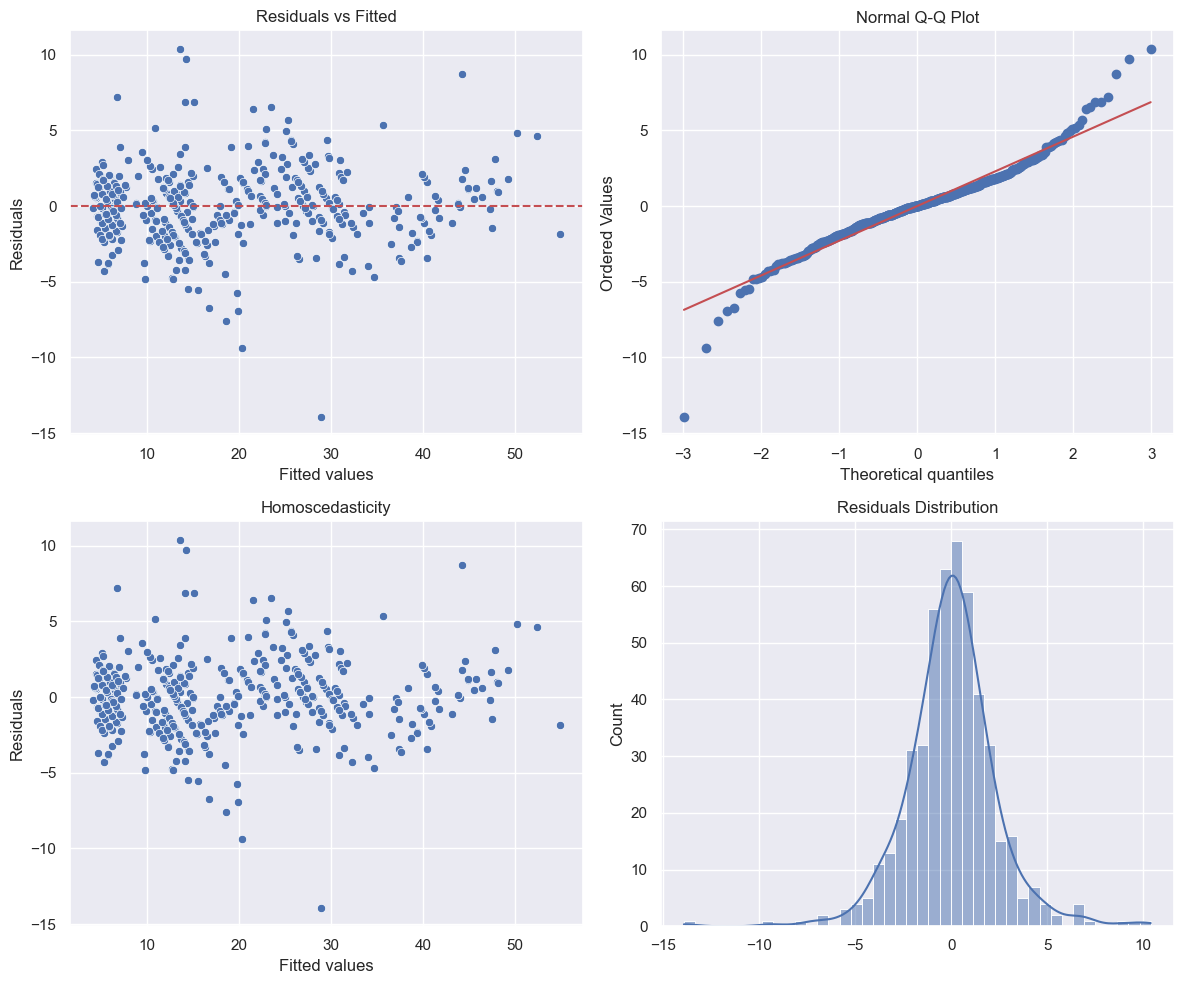

Shapiro-Wilk test p-value: 3.710217896801815e-12
Residuals are not homoscedastic LeveneResult(statistic=10.330097024487538, pvalue=1.3217937235852186e-06)
Bartlett’s test p-value: 1.390324655063287e-209
White test p-value: 0.020938205958213326
Levene’s test p-value for the whole model: 1.3217937235852186e-06
Levene’s test p-value for variable hc_class: 0.6163323897293633
Levene’s test p-value for variable outcome: nan
Levene’s test p-value for variable group_type: 0.03522716602669276
Levene’s test p-value for variable site: 0.0010086967412912791
Levene’s test p-value for variable sex: 0.8692066386305453
Homoscedasticiyy checked
AIC: 2696.886002178068 BIC: 2751.6498814228376
Print: The model converged: True


c:\Users\gabot\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

c:\Users\gabot\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars



Single model coefficient plot


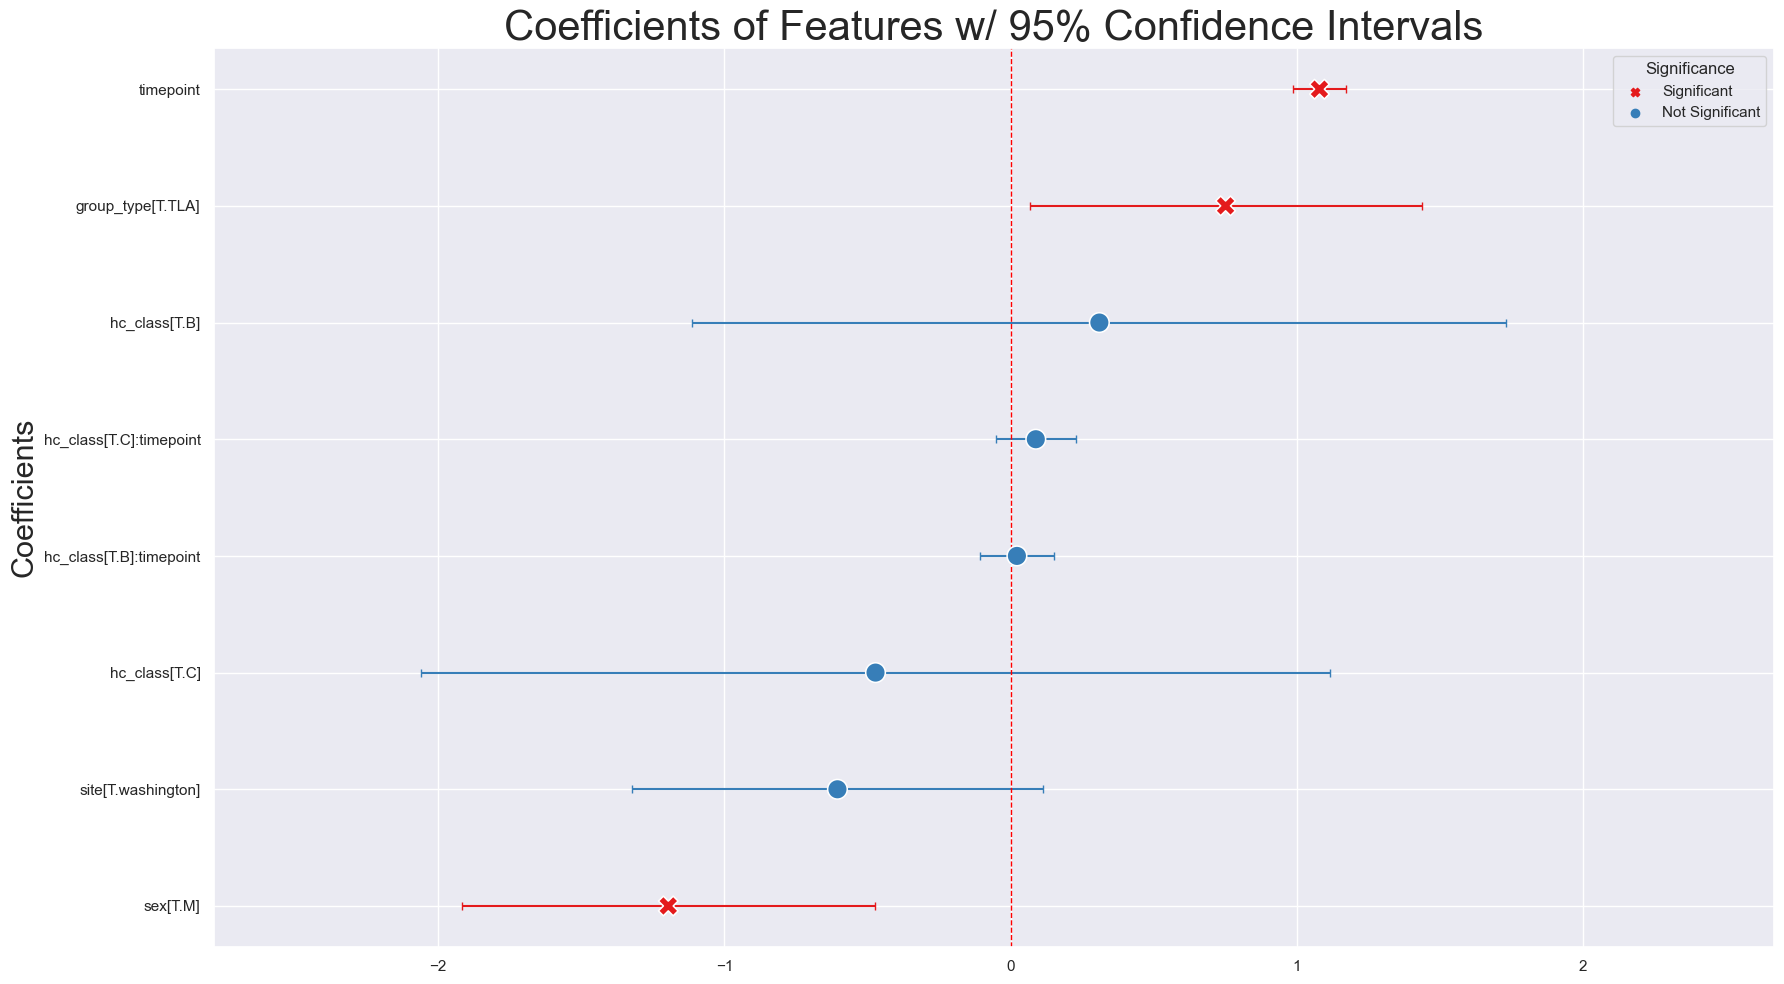

'Assumptions checked'

In [218]:
# Ensure that categorical variables are properly encoded
receptive_df_long['hc_class'] = receptive_df_long['hc_class'].astype('category')
receptive_df_long['sex'] = receptive_df_long['sex'].astype('category')
receptive_df_long['site'] = receptive_df_long['site'].astype('category')
receptive_df_long['group_type'] = receptive_df_long['group_type'].astype('category')

# Check for missing data
print(receptive_df_long[['score', 'hc_class', 'timepoint', 'sex', 'site', 'group_type']].isnull().sum())

# Define and fit the model with random intercepts and slopes for 'timepoint'
model = smf.mixedlm(
    'score ~ hc_class * timepoint + sex + site + group_type', 
    receptive_df_long, 
    groups=receptive_df_long['subject'], 
    re_formula='~timepoint',  # Random slopes for 'timepoint'
    missing='drop'  # Full maximum likelihood to handle missing data
)

model = model.fit(reml=False)

# Print the model summary
print(model.summary())

# Check assumptions
asumption_df=check_assumptions(model, expressive_df_long, show_plots=True, show_text=True, covariates=['hc_class','outcome','group_type', 'site', 'sex' ])


# Extract AIC and BIC
aic = model.aic
bic = model.bic
print("AIC:", aic, "BIC:", bic)

# Check if model converged 
converged = model.converged
print(f"Print: The model converged: {converged}")
# Plot the model 
coefplot_gap(model, multiple_models=False, fig_name="original_model")

asumption_df

In [219]:
# Ensure that categorical variables are properly encoded
receptive_df_long['lpa_class'] = receptive_df_long['lpa_class'].astype('category')
receptive_df_long['sex'] = receptive_df_long['sex'].astype('category')
receptive_df_long['site'] = receptive_df_long['site'].astype('category')
receptive_df_long['group_type'] = receptive_df_long['group_type'].astype('category')

# Check for missing data
print(receptive_df_long[['score', 'lpa_class', 'timepoint', 'sex', 'site', 'group_type']].isnull().sum())

# Define and fit the model with random intercepts and slopes for 'timepoint'
model = smf.mixedlm(
    'score ~ lpa_class * timepoint + sex + site + group_type', 
    receptive_df_long, 
    groups=receptive_df_long['subject'], 
    re_formula='~timepoint',  # Random slopes for 'timepoint'
    missing='drop'  # Full maximum likelihood to handle missing data
)

# Fit the model using Full Maximum Likelihood (method='ml')
result = model.fit()

# Print the model summary
print(result.summary())

score         221
lpa_class       0
timepoint       0
sex             0
site            0
group_type      0
dtype: int64


c:\Users\gabot\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\gabot\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning:

Retrying MixedLM optimization with lbfgs

c:\Users\gabot\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning:

Random effects covariance is singular



               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    score     
No. Observations:      499        Method:                REML      
No. Groups:            144        Scale:                 7.6899    
Min. group size:       1          Log-Likelihood:        -1339.7882
Max. group size:       4          Converged:             Yes       
Mean group size:       3.5                                         
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.034    0.804  0.043 0.966 -1.542  1.611
lpa_class[T.b]           -0.106    0.872 -0.122 0.903 -1.815  1.603
lpa_class[T.c]           -0.701    0.921 -0.761 0.447 -2.507  1.105
sex[T.M]                 -1.186    0.353 -3.361 0.001 -1.877 -0.494
site[T.washington]       -0.647    0.354 -1.831 0.067 -1.340  0

In [220]:
verbal_df_long

hc_class lpa_class subject sex        site group_type outcome  \
0           A         c       2   M  washington        ELA  no-asd   
1           B         b       3   M  washington        ELA  no-asd   
2           B         b       5   M  washington        TLA     NaN   
3           B         b       6   M  washington        ELA  no-asd   
4           B         b       8   M  washington        ELA     asd   
...       ...       ...     ...  ..         ...        ...     ...   
1291        C         c     748   F      london        TLA  no-asd   
1292        B         b     915   M  washington        TLA  no-asd   
1293        A         a     933   M  washington        TLA     asd   
1294        B         b     937   M  washington        TLA  no-asd   
1295        A         c     107   M  washington        TLA  no-asd   

              Measure  score  timepoint    iq  
0        nonverbal_iq    7.0          6   7.0  
1        nonverbal_iq    6.5          6   6.5  
2        nonverbal_iq    5.0          6   5.0  
3        nonverbal_iq    6.0          6   6.0  
4        nonverbal_iq    6.0          6   6.0  
...               ...    ...        ...   ...  
1291  verbal_quotient   58.5         36  45.5  
1292  verbal_quotient    NaN         36   NaN  
1293  verbal_quotient    NaN         36   NaN  
1294  verbal_quotient    NaN         36   NaN  
1295  verbal_quotient    NaN         36   NaN  

[1296 rows x 11 columns]

In [221]:
# Remove white space  in  HC and LPA class and convert to categorical
lang_wide.replace({"High Avg": "High_Avg", "Low Avg": "Low_Avg"}, inplace=True)

In [222]:
lang_wide.fillna(999, inplace=True)


In [223]:
expressive_df_lpa= lang_wide[["lpa_class", "subject", "site", "sex", "group_type",
                         "expressive_6", "expressive_12", "expressive_24", "expressive_36" ]]
receptive_df_lpa= lang_wide[["lpa_class", "subject", "site", "sex", "group_type",
                            "receptive_6", "receptive_12", "receptive_24", "receptive_36" ]]

expressive_df_hc= lang_wide[["hc_class","subject", "site", "sex", "group_type",
                         "expressive_6", "expressive_12", "expressive_24", "expressive_36" ]]
receptive_df_hc= lang_wide[["hc_class","subject", "site", "sex", "group_type",
                         "expressive_6", "expressive_12", "expressive_24", "expressive_36" ]]

In [224]:
# convert all columns to 1 and 0
expressive_df_lpa = pd.get_dummies(expressive_df_lpa, drop_first=True)
receptive_df_lpa = pd.get_dummies(receptive_df_lpa, drop_first=True)
expressive_df_hc = pd.get_dummies(expressive_df_hc, drop_first=True)
receptive_df_hc = pd.get_dummies(receptive_df_hc, drop_first=True)


In [225]:
# Save for use in mplus 
expressive_df_lpa.to_csv(f"../../Datasets/mplus/source_data/GCM/mplus_{date}_expressive_df_lpa.dat", index=False, header=False)
receptive_df_lpa.to_csv(f"../../Datasets/mplus/source_data/GCM/mplus_{date}_receptive_df_lpa.dat", index=False, header=False)
expressive_df_hc.to_csv(f"../../Datasets/mplus/source_data/GCM/mplus_{date}_expressive_df_hc.dat", index=False, header=False)
receptive_df_hc.to_csv(f"../../Datasets/mplus/source_data/GCM/mplus_{date}_receptive_df_hc.dat", index=False, header=False)


OSError: Cannot save file into a non-existent directory: '..\..\Datasets\mplus\source_data\GCM'

In [ ]:
expressive_df_hc

subject  expressive_6  expressive_12  expressive_24  expressive_36  \
0          2           5.0           13.0           21.0          999.0   
1          3           7.0           14.0           21.0          999.0   
2          5           5.0          999.0          999.0          999.0   
3          6           4.0           12.0           27.0          999.0   
4          8           5.0            8.0           24.0          999.0   
..       ...           ...            ...            ...            ...   
139      747           9.0           16.0           35.0           46.0   
140      748           5.0           10.0           28.0           60.0   
141      915           5.0           15.0           24.0          999.0   
142      933           5.0           10.0          999.0          999.0   
143      937           6.0           10.0          999.0          999.0   

     hc_class_B  site_washington  sex_M  group_type_TLA  
0             1                1      1               0  
1             0                1      1               0  
2             0                1      1               1  
3             0                1      1               0  
4             1                1      1               0  
..          ...              ...    ...             ...  
139           1                0      0               1  
140           1                0      0               1  
141           1                1      1               1  
142           0                1      1               1  
143           0                1      1               1  

[144 rows x 9 columns]

#### Boxplots receptive 6mo

In [ ]:
friedman_test_results

NameError: name 'friedman_test_results' is not defined

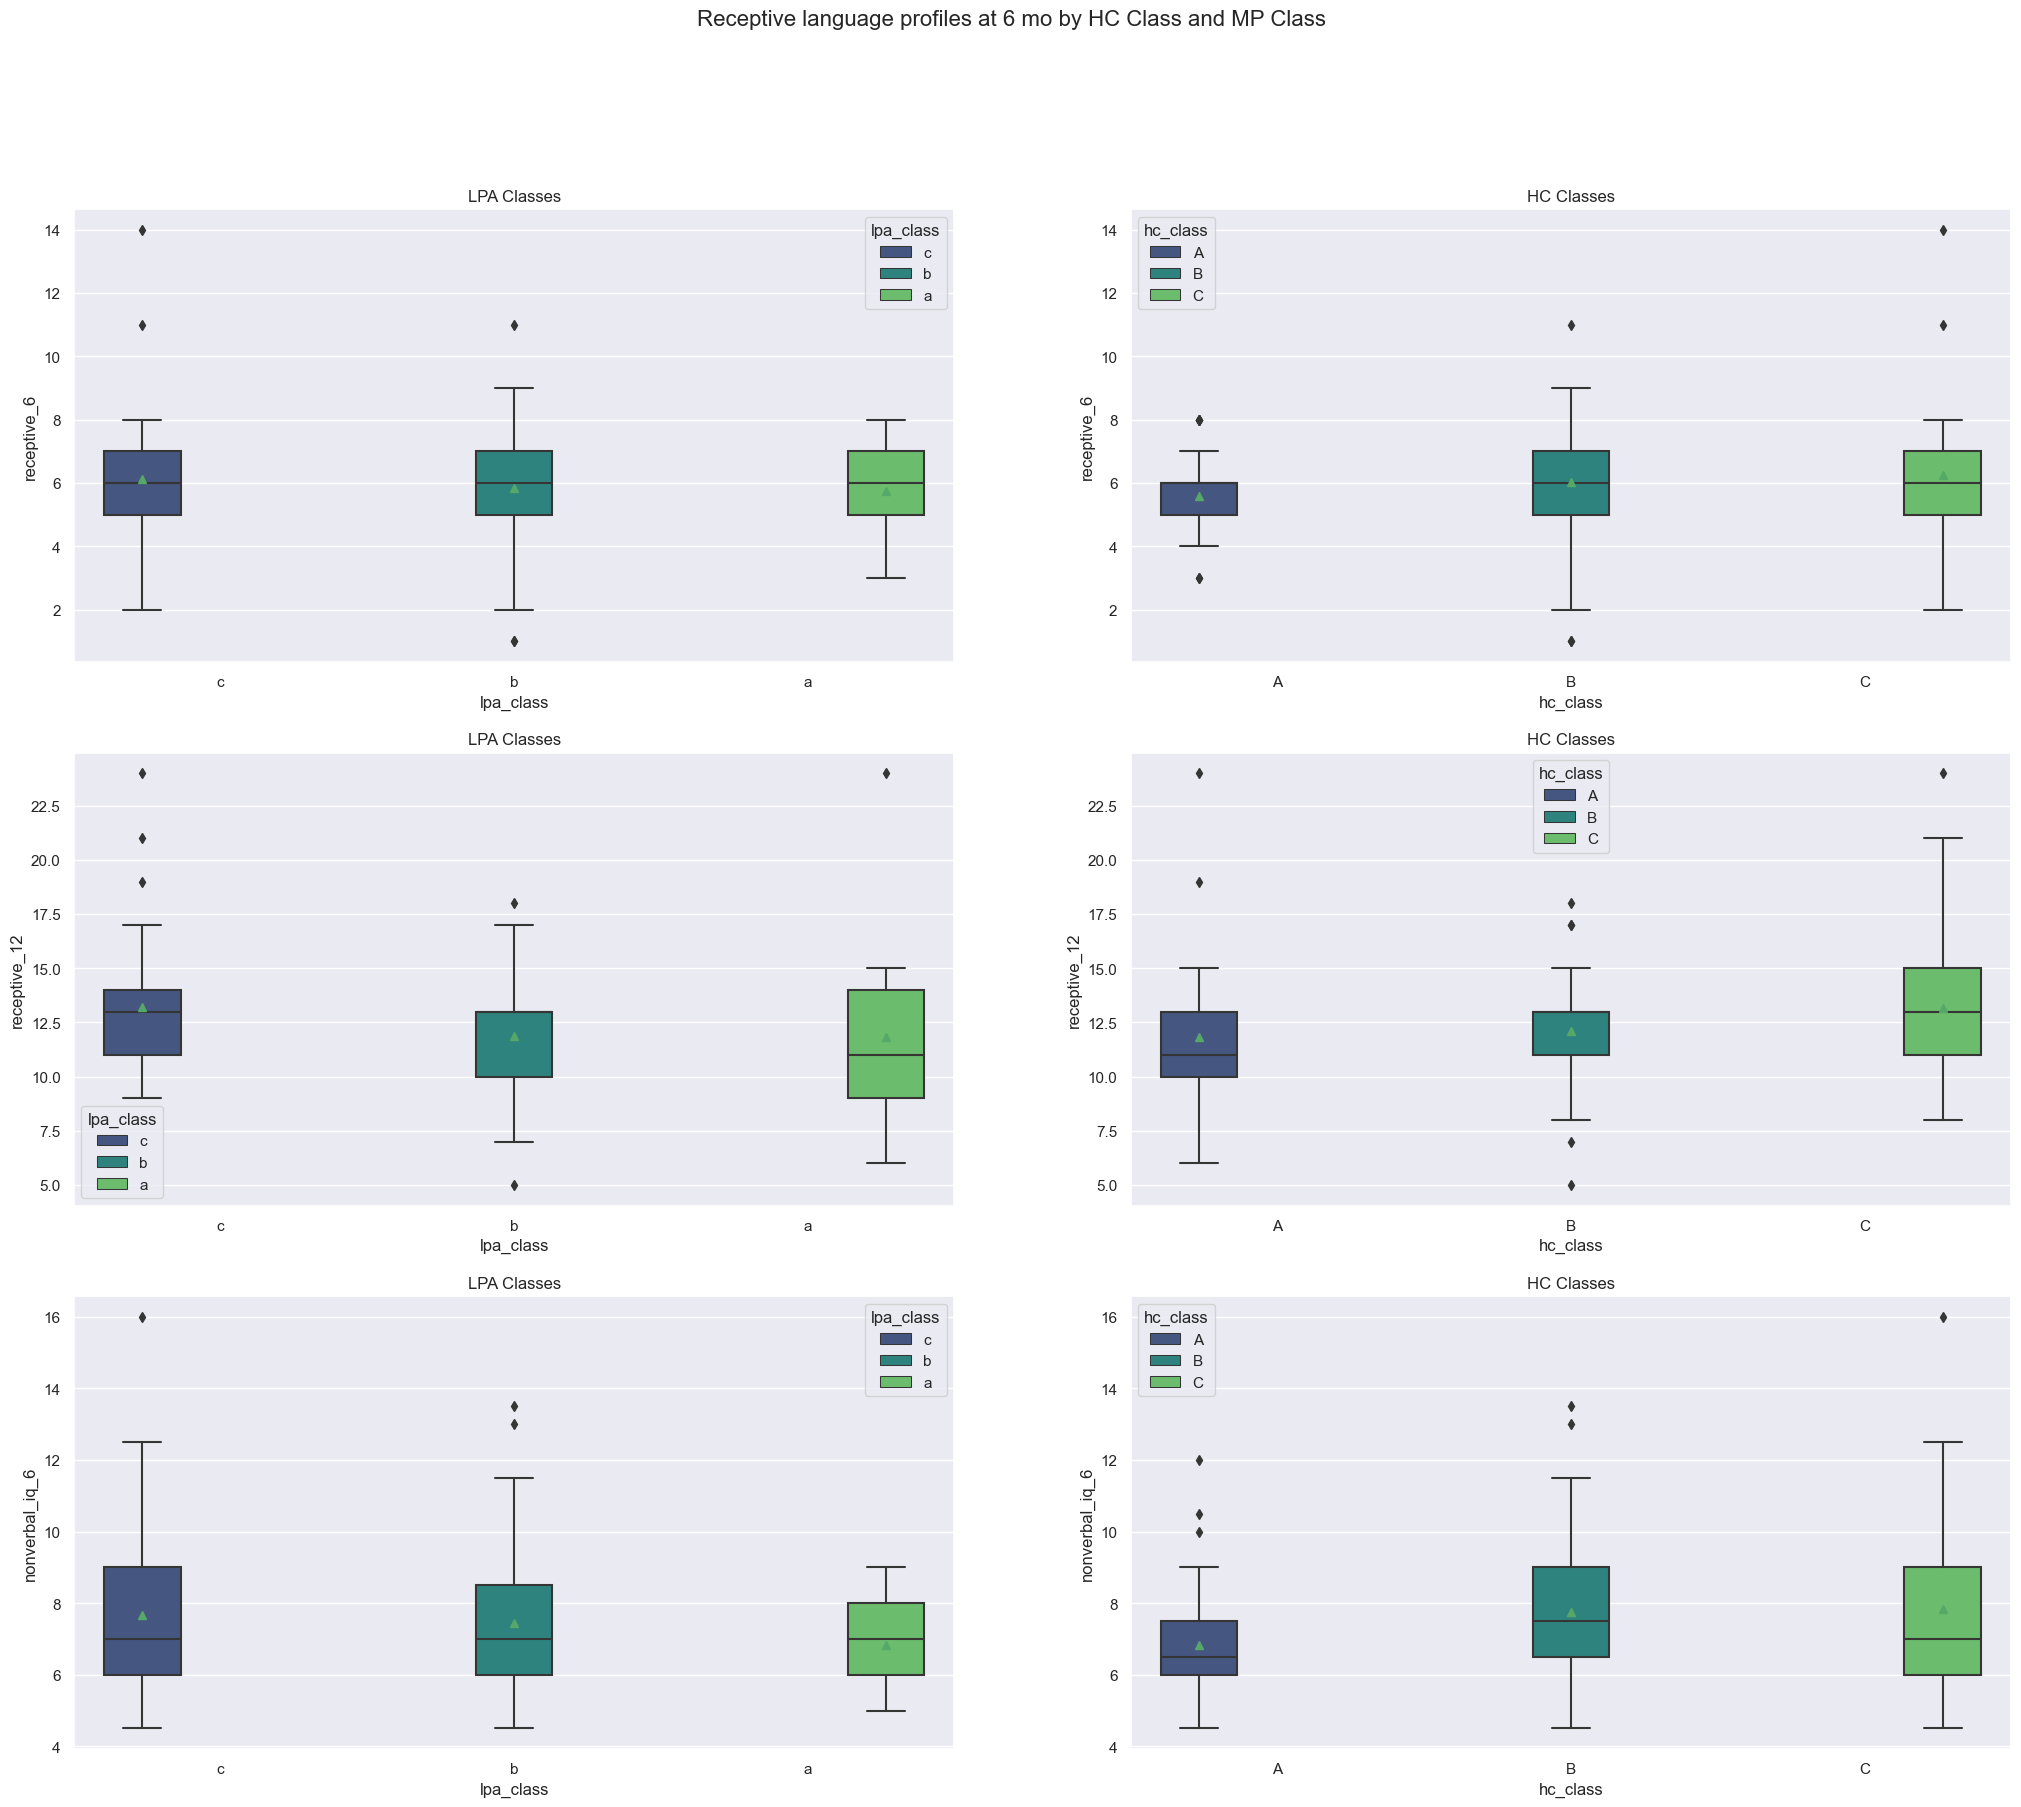

In [226]:
fig, ax = plt.subplots(3, 2, figsize=(25, 20))
# Box plot of receptive language at 6mo by HC Class and MP Class

# Add overall title
fig.suptitle("Receptive language profiles at 6 mo by HC Class and MP Class", fontsize=16)

# Plot the distribution of the classes rainplot
sns.boxplot(data=neurosubs_df, x="lpa_class", y="receptive_6", hue="lpa_class", ax=ax[0, 0], palette="viridis", showmeans=True)
            
               
ax[0, 0].set_title("LPA Classes")
sns.boxplot(data=neurosubs_df, x="hc_class", y="receptive_6", hue="hc_class", ax=ax[0, 1], palette="viridis", showmeans=True)
ax[0, 1].set_title("HC Classes")

# Box plot of receptive language at 12 months by HC Class and MP Class

# Plot the distribution of the classes
sns.boxplot(data=neurosubs_df, x="lpa_class", y="receptive_12", hue="lpa_class", ax=ax[1, 0], palette="viridis", showmeans=True)
ax[1, 0].set_title("LPA Classes")
sns.boxplot(data=neurosubs_df, x="hc_class", y="receptive_12", hue="hc_class", ax=ax[1, 1], palette="viridis", showmeans=True)
ax[1, 1].set_title("HC Classes")

# Box plot of nonverbal IQ at 6 months by HC Class and MP Class

# Plot the distribution of the classes
sns.boxplot(data=neurosubs_df, x="lpa_class", y = "nonverbal_iq_6", hue="lpa_class", ax=ax[2, 0], palette="viridis", showmeans=True)
ax[2, 0].set_title("LPA Classes")
sns.boxplot(data=neurosubs_df, x="hc_class", y = "nonverbal_iq_6", hue="hc_class", ax=ax[2, 1], palette="viridis", showmeans=True)
ax[2, 1].set_title("HC Classes")

plt.show()

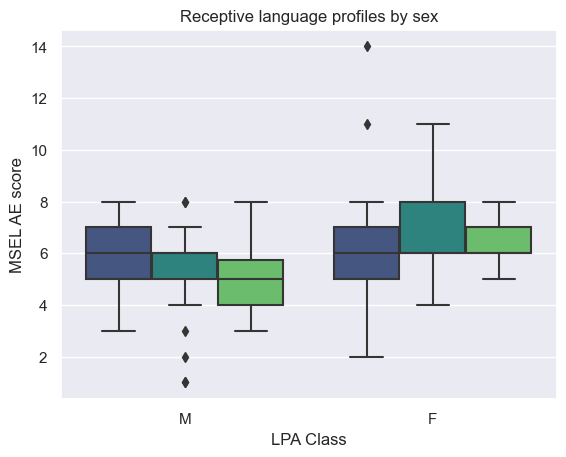

In [227]:
sns.boxplot(data=graphing_df, x="sex", y="receptive_6", hue="lpa_class", palette="viridis")
plt.title("Receptive language profiles by sex")
plt.xlabel("LPA Class")
plt.ylabel("MSEL AE score")

# Remove legend 
plt.legend([],[], frameon=False)

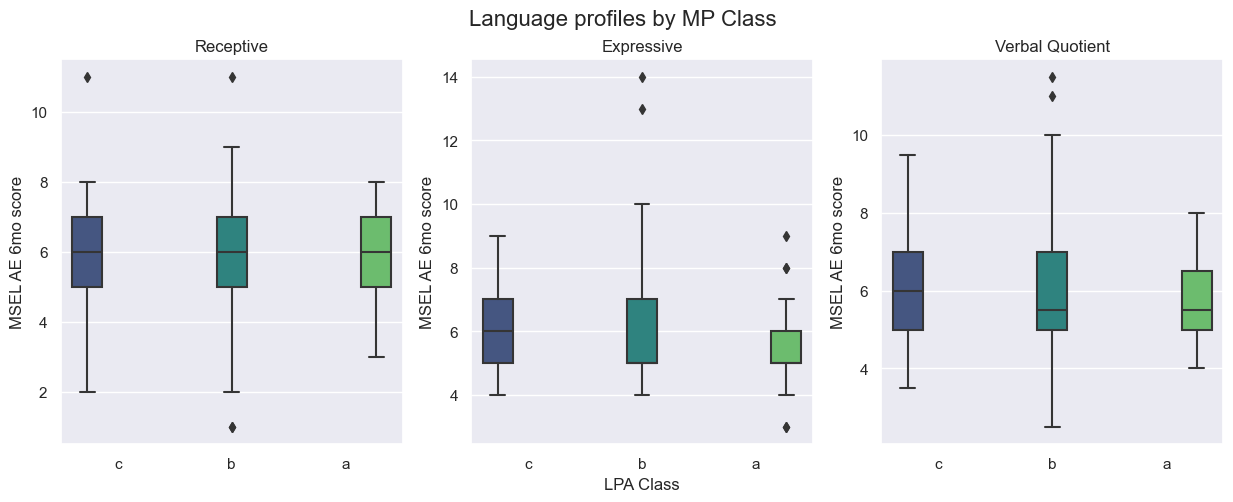

In [228]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# Box plot of receptive language at 6mo by LPA Class

graphing_df = neurosubs_df.copy()

# Remove outliers
graphing_df = graphing_df[(np.abs(stats.zscore(graphing_df["receptive_6"])) < 3)]

# Add overall title
fig.suptitle("Language profiles by MP Class", fontsize=16)

# Plot the distribution of the classes rainplot
sns.boxplot(data=graphing_df, x="lpa_class", y="receptive_6", hue="lpa_class", ax=ax[0], palette="viridis")
ax[0].set_title("Receptive")
ax[0].set_xlabel("")
ax[0].set_ylabel("MSEL AE 6mo score")


# Box plot of receptive language at 12 months by LPA Class
sns.boxplot(data=graphing_df, x="lpa_class", y="expressive_6", hue="lpa_class", ax=ax[1], palette="viridis")
ax[1].set_title("Expressive")
ax[1].set_xlabel("LPA Class")
ax[1].set_ylabel("MSEL AE 6mo score")

# Box plot of verbal quotient at 6 months by LPA Class
sns.boxplot(data=graphing_df, x="lpa_class", y = "verbal_quotient_6", hue="lpa_class", ax=ax[2], palette="viridis")
ax[2].set_title("Verbal Quotient")
ax[2].set_xlabel("")
ax[2].set_ylabel("MSEL AE 6mo score")

# Remove legend
ax[0].legend([],[], frameon=False)
ax[1].legend([],[], frameon=False)
ax[2].legend([],[], frameon=False)

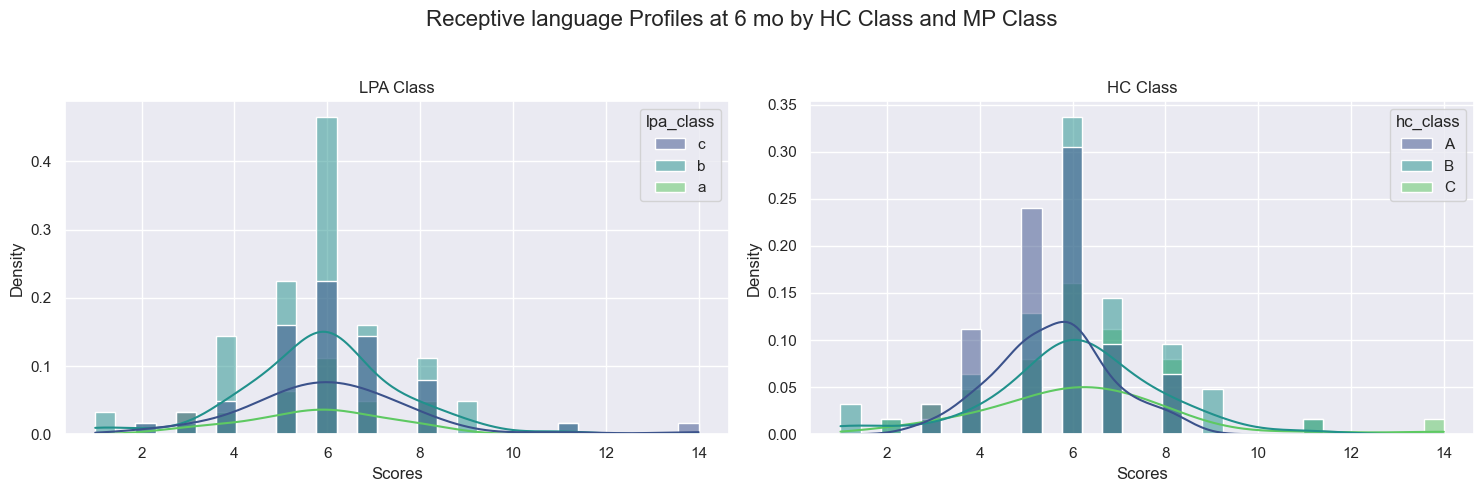

In [229]:
# Plot distribution of language scores at 6mo
# Set the figure size
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Overall title
fig.suptitle("Receptive language Profiles at 6 mo by HC Class and MP Class", fontsize=16)

# Distribution for lpa_class
sns.histplot(data=neurosubs_df, x="receptive_6", hue="lpa_class", kde=True, palette="viridis", ax=ax[0], stat="density", bins=30, alpha=0.5)
ax[0].set_title("LPA Class")
ax[0].set_xlabel("Scores")
ax[0].set_ylabel("Density")

# Distribution for hc_class
sns.histplot(data=neurosubs_df, x="receptive_6", hue="hc_class", kde=True, palette="viridis", ax=ax[1], stat="density", bins=30, alpha=0.5)
ax[1].set_title("HC Class")
ax[1].set_xlabel("Scores")
ax[1].set_ylabel("Density")

# Show the plots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
plt.show()

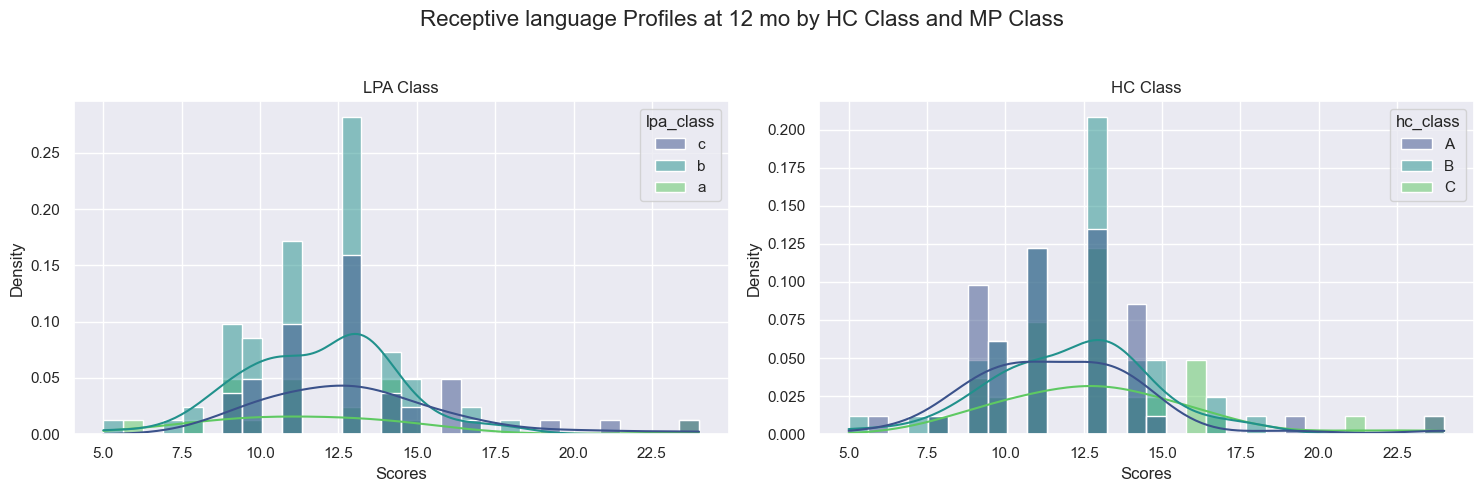

In [230]:
# Plot distribution of language scores for each class using pairplot
# Set the figure size
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Overall title
fig.suptitle("Receptive language Profiles at 12 mo by HC Class and MP Class", fontsize=16)

# Distribution for lpa_class
sns.histplot(data=neurosubs_df, x="receptive_12", hue="lpa_class", kde=True, palette="viridis", ax=ax[0], stat="density", bins=30, alpha=0.5)
ax[0].set_title("LPA Class")
ax[0].set_xlabel("Scores")
ax[0].set_ylabel("Density")

# Distribution for hc_class
sns.histplot(data=neurosubs_df, x="receptive_12", hue="hc_class", kde=True, palette="viridis", ax=ax[1], stat="density", bins=30, alpha=0.5)
ax[1].set_title("HC Class")
ax[1].set_xlabel("Scores")
ax[1].set_ylabel("Density")

# Show the plots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
plt.show()



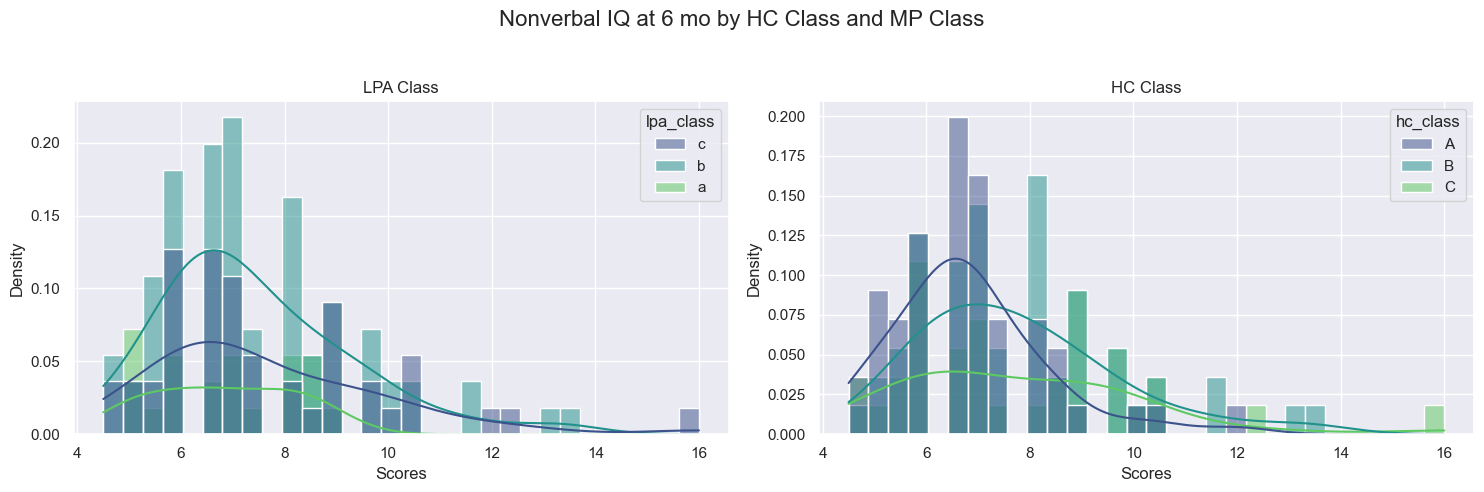

In [231]:
# Plot distribution of language scores at 6mo
# Set the figure size
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Overall title
fig.suptitle("Nonverbal IQ at 6 mo by HC Class and MP Class", fontsize=16)

# Distribution for lpa_class
sns.histplot(data=neurosubs_df, x="nonverbal_iq_6", hue="lpa_class", kde=True, palette="viridis", ax=ax[0], stat="density", bins=30, alpha=0.5)
ax[0].set_title("LPA Class")
ax[0].set_xlabel("Scores")
ax[0].set_ylabel("Density")

# Distribution for hc_class
sns.histplot(data=neurosubs_df, x="nonverbal_iq_6", hue="hc_class", kde=True, palette="viridis", ax=ax[1], stat="density", bins=30, alpha=0.5)
ax[1].set_title("HC Class")
ax[1].set_xlabel("Scores")
ax[1].set_ylabel("Density")

# Show the plots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
plt.show()

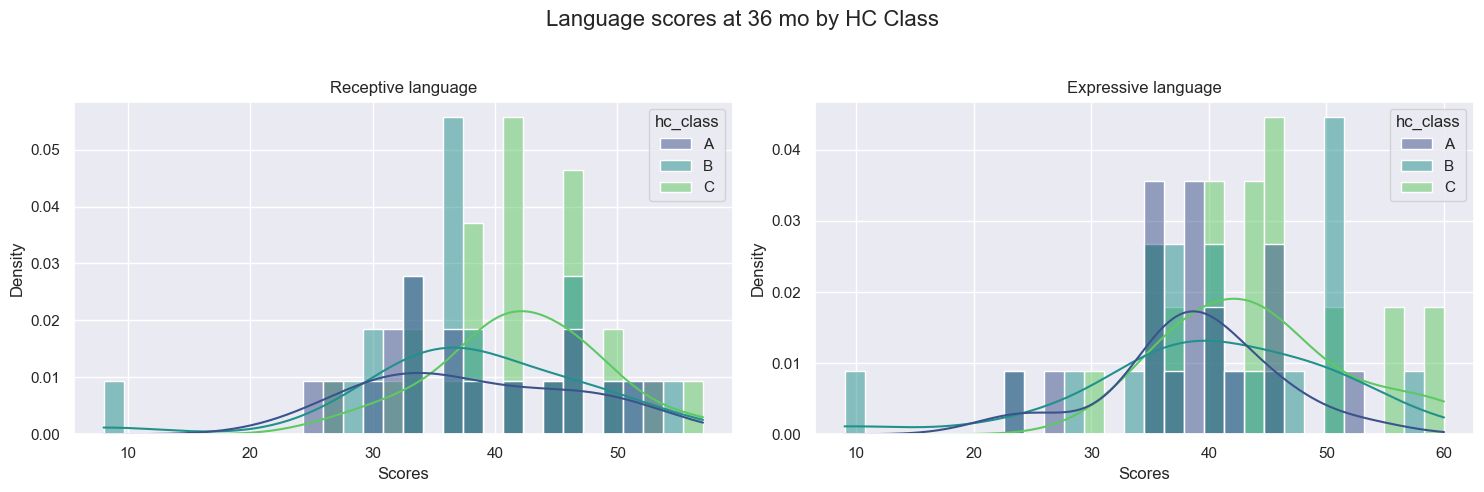

In [232]:
# Plot distribution of language scores at 6mo
# Set the figure size
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Overall title
fig.suptitle("Language scores at 36 mo by HC Class", fontsize=16)

# Distribution for lpa_class
sns.histplot(data=neurosubs_df, x="receptive_36", hue="hc_class", kde=True, palette="viridis", ax=ax[0], stat="density", bins=30, alpha=0.5, hue_order=hc_order)
ax[0].set_title("Receptive language")
ax[0].set_xlabel("Scores")
ax[0].set_ylabel("Density")

# Distribution for hc_class
sns.histplot(data=neurosubs_df, x="expressive_36", hue="hc_class", kde=True, palette="viridis", ax=ax[1], stat="density", bins=30, alpha=0.5, hue_order=hc_order)
ax[1].set_title("Expressive language")
ax[1].set_xlabel("Scores")
ax[1].set_ylabel("Density")

# Show the plots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
plt.show()

ValueError: Could not interpret value `fine_18` for parameter `x`

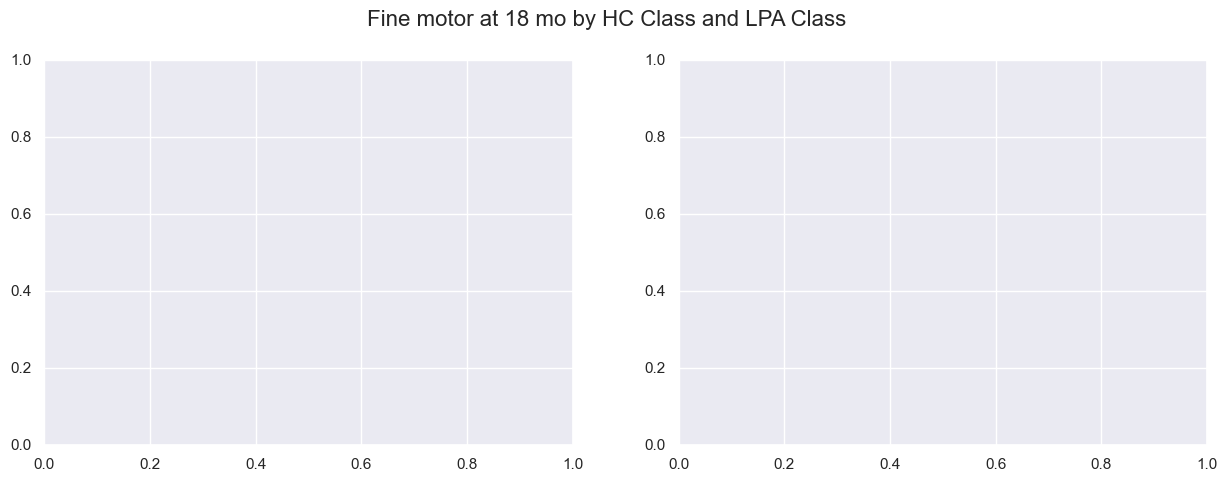

In [233]:
# Plot distribution of language scores at 6mo
# Set the figure size
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Overall title
fig.suptitle("Fine motor at 18 mo by HC Class and LPA Class", fontsize=16)

# Distribution for lpa_class
sns.histplot(data=neurosubs_df, x="fine_18", hue="lpa_class", kde=True, palette="viridis", ax=ax[0], stat="density", bins=30, alpha=0.5)
ax[0].set_title("LPA Class")
ax[0].set_xlabel("Scores")
ax[0].set_ylabel("Density")

# Distribution for hc_class
sns.histplot(data=neurosubs_df, x="fine_18", hue="hc_class", kde=True, palette="viridis", ax=ax[1], stat="density", bins=30, alpha=0.5)
ax[1].set_title("HC Class")
ax[1].set_xlabel("Scores")
ax[1].set_ylabel("Density")

# Show the plots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
plt.show()

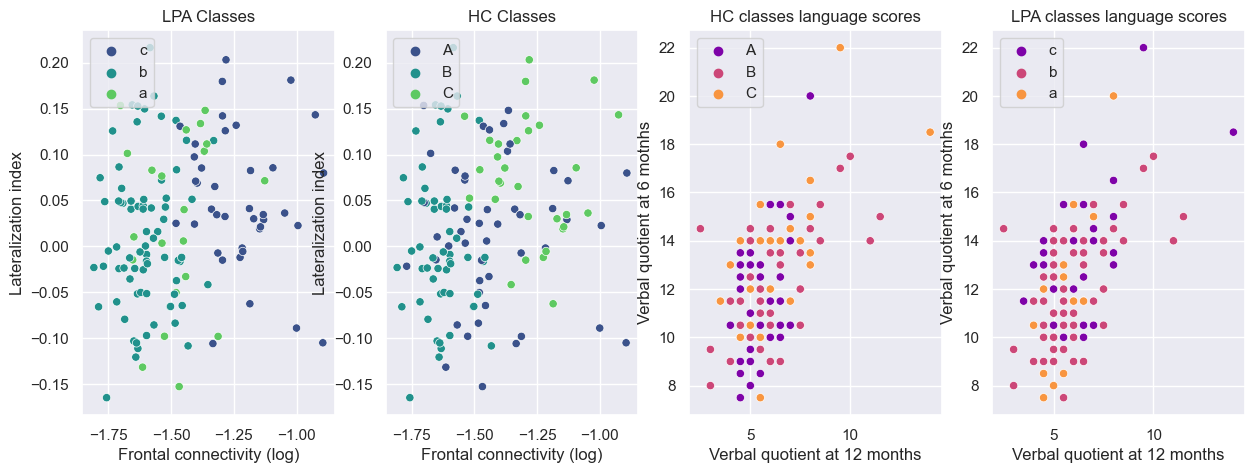

In [234]:
# Plot 2D scatterplot of language measures

fig, ax = plt.subplots(1, 4, figsize=(15, 5))
# Plot the distribution of the classes
sns.scatterplot(data=neurosubs_df, x="speech_con_6_left", y="gamma_lat_6", hue="lpa_class", ax=ax[0], palette="viridis")
ax[0].get_legend().remove()
ax[0].legend(loc='upper left')
ax[0].set_title("LPA Classes")
ax[0].set_ylabel("Lateralization index")
ax[0].set_xlabel("Frontal connectivity (log)")

sns.scatterplot(data=neurosubs_df, x="speech_con_6_left", y="gamma_lat_6", hue="hc_class", ax=ax[1], palette="viridis", legend="full")
ax[1].get_legend().remove()
ax[1].legend(loc='upper left')
ax[1].set_title("HC Classes")
ax[1].set_ylabel("Lateralization index")
ax[1].set_xlabel("Frontal connectivity (log)")


# Plot the distribution of outcomes
sns.scatterplot(data=neurosubs_df, x="verbal_quotient_6", y="verbal_quotient_12", hue="hc_class",ax=ax[2], palette="plasma")
ax[2].legend(loc='upper left')
ax[2].set_title("HC classes language scores")
ax[2].set_ylabel("Verbal quotient at 6 motnhs")
ax[2].set_xlabel("Verbal quotient at 12 months")

sns.scatterplot(data=neurosubs_df, x="verbal_quotient_6", y="verbal_quotient_12", hue="lpa_class", ax=ax[3], palette="plasma")
ax[3].legend(loc='upper left')
ax[3].set_title("LPA classes language scores")
ax[3].set_ylabel("Verbal quotient at 6 motnhs")
ax[3].set_xlabel("Verbal quotient at 12 months")

plt.show()

In [235]:
# Create quartile columns for verbal quotient at 6 and 12 months
neurosubs_df["receptive_6_quartile"] = pd.qcut(neurosubs_df["receptive_6"], q=4, labels=["Q1", "Q2", "Q3", "Q4"])

# Create a contingency table of percentile ranks
contingency_table = pd.crosstab(neurosubs_df["receptive_6_quartile"], neurosubs_df["lpa_class"], normalize="columns")  
print(contingency_table)

# Perform Chi-Squared test
chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)
print(f"Chi-Squared test for verbal quotient at 6 months and HC Class: p-value = {p_value}")


lpa_class                    a         b         c
receptive_6_quartile                              
Q1                    0.380952  0.350649  0.347826
Q2                    0.333333  0.376623  0.304348
Q3                    0.142857  0.129870  0.195652
Q4                    0.142857  0.142857  0.152174
Chi-Squared test for verbal quotient at 6 months and HC Class: p-value = 0.9999996519068508


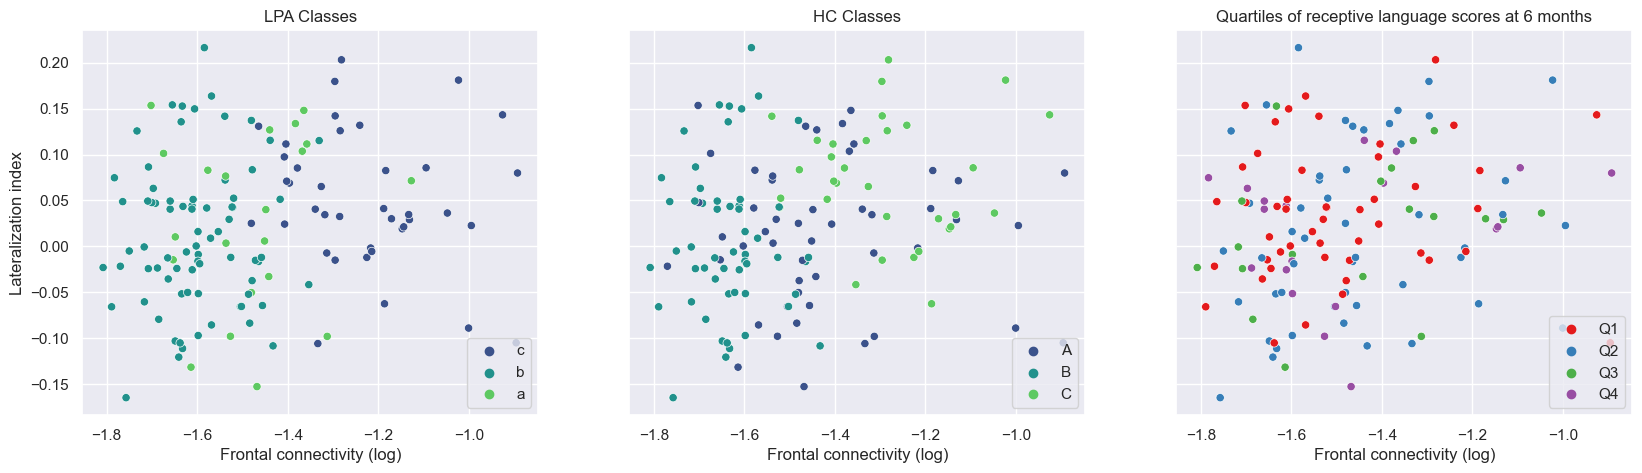

In [236]:
# Plot 2D scatterplot of language measures

fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=True, sharey=True)
# Plot the distribution of the classes
sns.scatterplot(data=neurosubs_df, x="speech_con_6_left", y="gamma_lat_6", hue="lpa_class", ax=ax[0], palette="viridis")
ax[0].get_legend().remove()
ax[0].legend(loc='lower right')
ax[0].set_title("LPA Classes")
ax[0].set_ylabel("Lateralization index")
ax[0].set_xlabel("Frontal connectivity (log)")

sns.scatterplot(data=neurosubs_df, x="speech_con_6_left", y="gamma_lat_6", hue="hc_class", ax=ax[1], palette="viridis", legend="full")
ax[1].get_legend().remove()
ax[1].legend(loc='lower right')
ax[1].set_title("HC Classes")
ax[1].set_ylabel("Lateralization index")
ax[1].set_xlabel("Frontal connectivity (log)")


# Plot the distribution of outcomes
sns.scatterplot(data=neurosubs_df,
                 x="speech_con_6_left", y="gamma_lat_6", hue="receptive_6_quartile",ax=ax[2], palette="Set1")
ax[2].legend(loc='lower right')
ax[2].set_title("Quartiles of receptive language scores at 6 months")
ax[2].set_ylabel("Lateralization index")
ax[2].set_xlabel("Frontal connectivity (log)")


plt.show()

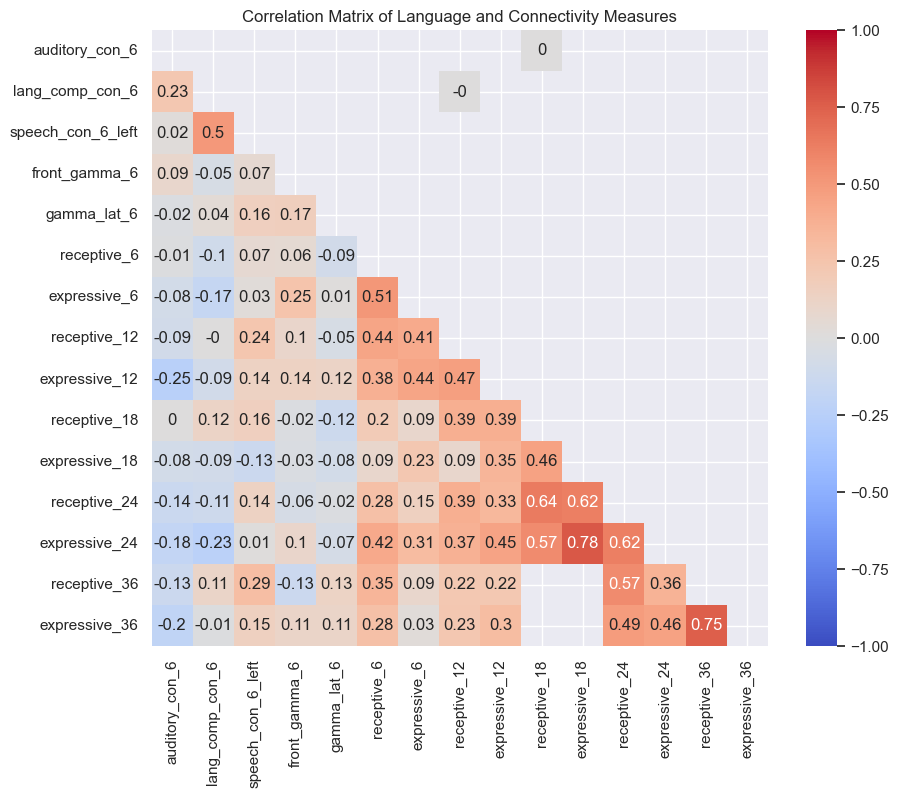

In [238]:
# Create correlation matrix of language measures and connectivity measures

# Select the columns to include in the correlation matrix
columns = eeg_vars
columns += language_vars

# Create the correlation matrix
corr_matrix = neurosubs_df[columns].corr().round(2)

# Plot the correlation matrix (only the lower tri)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, vmin=-1, vmax=1, square=True, mask=np.triu(corr_matrix))
plt.title("Correlation Matrix of Language and Connectivity Measures")
plt.show()

